In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
import os
import sys
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
import time
from collections import Counter
tqdm.pandas(tqdm_notebook)
import lightgbm as lgb
import gc
%matplotlib inline
import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.gridspec as gridspec
pd.set_option('display.float_format', '{:.5f}'.format)
np.random.seed(51)

In [2]:
train = dd.read_csv('train_last.csv')
train = train.compute()
train = train.reset_index(drop=True)
test = dd.read_csv('test_last.csv')
test = test.compute()
test = test.reset_index(drop=True)

In [65]:
useful_columns = ['feature_1', 'feature_3', 'active_year', 'h_af_std', 'h_af_mean', 'h_most_common_category_1', 'h_second_most_common_category_1', 'h_num_second_most_common_category_1', 'h_ins_sum', 'h_ins_mean', 'h_how_many_merchant_category_id_visited', 'h_num_most_common_merchant_category_id', 'h_how_many_merchant_id_visited', 'h_num_most_common_merchant_id', 'h_num_second_most_common_merchant_id', 'h_binned_purchase_amount_sum', 'h_binned_purchase_amount_mean', 'h_month_lag_sum', 'h_month_lag_min', 'h_month_lag_max', 'h_month_lag_std', 'h_month_lag_mean', 'h_month_lag_median', 'h_purchase_amount_sum', 'h_purchase_amount_median', 'h_max_25_percentile_diff', 'h_max_min_diff', 'h_75_percentile_min_diff', 'h_50_percentile_min_diff', 'h_how_many_unique_subsector_id', 'h_most_common_subsector_id', 'h_num_most_common_subsector_id', 'n_af_sum', 'n_num_most_visited_city', 'n_most_common_category_1', 'n_ins_sum', 'n_ins_min', 'n_ins_max', 'n_ins_median', 'n_num_most_common_category_3', 'n_how_many_merchant_category_id_visited', 'n_how_many_merchant_id_visited', 'n_binned_purchase_amount_sum', 'n_binned_purchase_amount_max', 'n_month_lag_min', 'n_month_lag_max', 'n_month_lag_std', 'n_month_lag_mean', 'n_month_lag_median', 'n_purchase_amount_sum', 'n_purchase_amount_max', 'n_purchase_amount_std', 'n_purchase_amount_mean', 'n_max_25_percentile_diff', 'n_max_min_diff', 'elapsed_time', 'h_transactions_count', 'h_category_1_sum', 'h_month_diff_mean', 'a_category_1_sum', 'a_category_1_mean', 'a_category_3_B_mean', 'a_purchase_month_max', 'a_purchase_month_min', 'a_purchase_month_std', 'a_month_diff_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_category_3_A_mean', 'new_category_3_B_mean', 'new_purchase_month_mean', 'new_purchase_month_max', 'new_purchase_month_min', 'new_month_diff_mean', 'month_lag_mean', 'month_lag_std', 'purchase_amount_count_mean', 'purchase_amount_mean_mean', 'purchase_amount_max_mean', 'purchase_amount_max_std', 'purchase_amount_std_mean', 'installments_count_mean', 'installments_sum_mean', 'installments_mean_std', 'category_1_purchase_amount_mean', 'category_1_purchase_amount_max', 'installments_purchase_amount_max', 'city_id_purchase_amount_max', 'category_1_installments_std']

In [3]:
train.head()

first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-06-01  C_ID_92a2005557          5          2          1   
1         2017-01-01  C_ID_3d0044924f          4          1          0   
2         2016-08-01  C_ID_d639edf6cd          2          2          0   
3         2017-09-01  C_ID_186d6a6901          4          3          0   
4         2017-11-01  C_ID_cdbd2c0db2          1          3          0   

    target  active_year  active_month  h_af_sum  h_af_count  h_af_min  \
0 -0.82028         2017             6       247         260         0   
1  0.39291         2017             1       339         350         0   
2  0.68806         2016             8        41          43         0   
3  0.14250         2017             9        77          77         1   
4 -0.15975         2017            11       128         133         0   

   h_af_max  h_af_std  h_af_mean  h_af_median  h_how_many_city_visited  \
0         1   0.21837    0.95000      1.00000                        7   
1         1   0.17472    0.96857      1.00000                        9   
2         1   0.21308    0.95349      1.00000                        5   
3         1   0.00000    1.00000      1.00000                        7   
4         1   0.19093    0.96241      1.00000                        6   

   h_most_visited_city  h_num_most_visited_city  h_second_most_visited_city  \
0                   69                      248                   131.00000   
1                   69                      289                    -1.00000   
2                  143                       39                   209.00000   
3                   17                       52                    -1.00000   
4                   17                      100                    -1.00000   

   h_num_second_most_visited_city  h_third_most_visited_city  \
0                         4.00000                  231.00000   
1                        31.00000                   19.00000   
2                         1.00000                  233.00000   
3                        12.00000                   69.00000   
4                        15.00000                   69.00000   

   h_num_third_most_visited_city h_most_common_category_1  \
0                        3.00000                        N   
1                        7.00000                        N   
2                        1.00000                        N   
3                        8.00000                        N   
4                        8.00000                        N   

   h_num_most_common_category_1 h_second_most_common_category_1  \
0                           260                             NaN   
1                           319                               Y   
2                            43                             NaN   
3                            65                               Y   
4                           118                               Y   

   h_num_second_most_common_category_1  h_ins_sum  h_ins_count  h_ins_min  \
0                                  nan          4          260          0   
1                             31.00000        543          350         -1   
2                                  nan          0           43          0   
3                             12.00000         84           77         -1   
4                             15.00000        182          133          1   

   h_ins_max  h_ins_std  h_ins_mean  h_ins_median h_most_common_category_3  \
0          1    0.12331     0.01538       0.00000                        A   
1         10    1.51078     1.55143       1.00000                        B   
2          0    0.00000     0.00000       0.00000                        A   
3          3    0.58897     1.09091       1.00000                        B   
4         12    1.89686     1.36842       1.00000                        B   

   h_num_most_common_category_3 h_second_most_common_category_3  \
0                           256             

In [4]:
temp = train.dtypes.reset_index(drop=False)
temp.columns = ['column','type']
for i in [x for x in list(temp[temp['type'] == 'object']['column']) if x not in ['card_id', 'first_active_month']]:
    le = preprocessing.LabelEncoder()
    le.fit(list(train[i].values) + list(test[i].values ) )
    train[i] = le.transform( list(train[i].values) )
    test[i] = le.transform( list(test[i].values) )
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]

In [5]:
target = train['target']
del train['target']

In [6]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
#features = [f for f in features if f not in unimportant_features]
#categorical_feats = ['feature_2', 'feature_3']

In [7]:
train.head()

first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-06-01  C_ID_92a2005557          5          2          1   
1         2017-01-01  C_ID_3d0044924f          4          1          0   
2         2016-08-01  C_ID_d639edf6cd          2          2          0   
3         2017-09-01  C_ID_186d6a6901          4          3          0   
4         2017-11-01  C_ID_cdbd2c0db2          1          3          0   

   active_year  active_month  h_af_sum  h_af_count  h_af_min  h_af_max  \
0         2017             6       247         260         0         1   
1         2017             1       339         350         0         1   
2         2016             8        41          43         0         1   
3         2017             9        77          77         1         1   
4         2017            11       128         133         0         1   

   h_af_std  h_af_mean  h_af_median  h_how_many_city_visited  \
0   0.21837    0.95000      1.00000                        7   
1   0.17472    0.96857      1.00000                        9   
2   0.21308    0.95349      1.00000                        5   
3   0.00000    1.00000      1.00000                        7   
4   0.19093    0.96241      1.00000                        6   

   h_most_visited_city  h_num_most_visited_city  h_second_most_visited_city  \
0                   69                      248                   131.00000   
1                   69                      289                    -1.00000   
2                  143                       39                   209.00000   
3                   17                       52                    -1.00000   
4                   17                      100                    -1.00000   

   h_num_second_most_visited_city  h_third_most_visited_city  \
0                         4.00000                  231.00000   
1                        31.00000                   19.00000   
2                         1.00000                  233.00000   
3                        12.00000                   69.00000   
4                        15.00000                   69.00000   

   h_num_third_most_visited_city  h_most_common_category_1  \
0                        3.00000                         0   
1                        7.00000                         0   
2                        1.00000                         0   
3                        8.00000                         0   
4                        8.00000                         0   

   h_num_most_common_category_1  h_second_most_common_category_1  \
0                           260                                2   
1                           319                                1   
2                            43                                2   
3                            65                                1   
4                           118                                1   

   h_num_second_most_common_category_1  h_ins_sum  h_ins_count  h_ins_min  \
0                                  nan          4          260          0   
1                             31.00000        543          350         -1   
2                                  nan          0           43          0   
3                             12.00000         84           77         -1   
4                             15.00000        182          133          1   

   h_ins_max  h_ins_std  h_ins_mean  h_ins_median  h_most_common_category_3  \
0          1    0.12331     0.01538       0.00000                         0   
1         10    1.51078     1.55143       1.00000                         1   
2          0    0.00000     0.00000       0.00000                         0   
3          3    0.58897     1.09091       1.00000                         1   
4         12    1.89686     1.36842       1.00000                         1   

   h_num_most_common_category_3  h_second_most_common_category_3  \
0                           256                                1   
1          

In [8]:
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 51,
         "verbosity": -1}

In [9]:
folds = KFold(n_splits=5, shuffle=True, random_state=51)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features].values,
                           label=target.iloc[trn_idx].values,
                           #categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features].values,
                           label=target.iloc[val_idx].values,
                           #categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.62572	valid_1's rmse: 3.7893
[200]	training's rmse: 3.54934	valid_1's rmse: 3.75066
[300]	training's rmse: 3.50262	valid_1's rmse: 3.73654
[400]	training's rmse: 3.4679	valid_1's rmse: 3.73002
[500]	training's rmse: 3.43943	valid_1's rmse: 3.72668
[600]	training's rmse: 3.41313	valid_1's rmse: 3.7255
[700]	training's rmse: 3.38847	valid_1's rmse: 3.72413
[800]	training's rmse: 3.36443	valid_1's rmse: 3.72434
[900]	training's rmse: 3.34175	valid_1's rmse: 3.72493
Early stopping, best iteration is:
[734]	training's rmse: 3.38064	valid_1's rmse: 3.724
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.66437	valid_1's rmse: 3.63619
[200]	training's rmse: 3.58606	valid_1's rmse: 3.60262
[300]	training's rmse: 3.54154	valid_1's rmse: 3.5927
[400]	training's rmse: 3.50838	valid_1's rmse: 3.58819
[500]	training's rmse: 3.48071	valid_1's rmse: 3.58575
[6

In [10]:
def get_feature_importances(data, shuffle):
    # Gather real features
    #train_features = [f for f in data if f not in ['target', 'object_id']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = target.copy()

    if shuffle:
        y = target.copy().sample(frac=1.0)
        y = pd.Series(y)
    
    dtrain = lgb.Dataset(data[features], y, free_raw_data=False, silent=True)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    param = {'num_leaves': 111,
             'min_data_in_leaf': 149, 
             'objective':'regression',
             'max_depth': 9,
             'learning_rate': 0.01,
             "boosting": "gbdt",
             "feature_fraction": 0.7522,
             "bagging_freq": 1,
             "bagging_fraction": 0.7083 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.2634,
             "random_state": 51,
             "verbosity": -1}
    clf = lgb.train(params=param, train_set=dtrain, num_boost_round=200)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    #imp_df['trn_score'] = roc_auc_score(pd.get_dummies(y), clf.predict_proba(data[train_features]))
    
    return imp_df

In [11]:
actual_imp_df = get_feature_importances(data=train, shuffle=False)

In [12]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with    1 of   80 (Spent   0.3 miDone with    2 of   80 (Spent   0.6 miDone with    3 of   80 (Spent   1.0 miDone with    4 of   80 (Spent   1.8 miDone with    5 of   80 (Spent   2.1 miDone with    6 of   80 (Spent   2.5 miDone with    7 of   80 (Spent   2.8 miDone with    8 of   80 (Spent   3.1 miDone with    9 of   80 (Spent   3.5 miDone with   10 of   80 (Spent   3.9 miDone with   11 of   80 (Spent   4.2 miDone with   12 of   80 (Spent   4.6 miDone with   13 of   80 (Spent   5.2 miDone with   14 of   80 (Spent   5.8 miDone with   15 of   80 (Spent   6.4 miDone with   16 of   80 (Spent   7.0 miDone with   17 of   80 (Spent   7.8 miDone with   18 of   80 (Spent   8.3 miDone with   19 of   80 (Spent   8.8 miDone with   20 of   80 (Spent   9.2 miDone with   21 of   80 (Spent   9.5 miDone with   22 of   80 (Spent   9.8 miDone with   23 of   80 (Spent  10.2 miDone with   24 of   80 (Spent  10.6 miDone with   25 of   80 (Spent  11.1 miDone with   26 of   80 (Spent  11.5 miDone with   

In [20]:
actual_imp_df.head()

feature  importance_gain  importance_split
0     feature_1      20069.31926                45
1     feature_2      12403.57319                27
2     feature_3       9518.51228                19
3   active_year      15950.74120                30
4  active_month      22557.84478                56

In [21]:
null_imp_df.head()

feature  importance_gain  importance_split  run
0     feature_1       4608.45756                39    1
1     feature_2       2143.49891                16    1
2     feature_3       1019.24981                11    1
3   active_year       3229.08267                16    1
4  active_month       5131.08961                44    1

In [49]:
temp = null_imp_df.groupby('feature')['importance_gain','importance_split'].agg(['mean','std']).reset_index(drop=False)
temp.columns = ['feature','gain_mean','gain_std','split_mean','split_std']
temp['gain_2_sigma'] = temp['gain_mean'] + temp['gain_std']*2
temp['split_2_sigma'] = temp['split_mean'] + temp['split_std']*2
temp2 = actual_imp_df.merge(temp[['feature','gain_2_sigma','split_2_sigma']],how='left',on = 'feature')

In [64]:
temp2[(temp2['importance_gain'] > temp2['gain_2_sigma']) & (temp2['importance_split'] > temp2['split_2_sigma'] ) ]['feature']

['feature_1', 'feature_3', 'active_year', 'h_af_std', 'h_af_mean', 'h_most_common_category_1', 'h_second_most_common_category_1', 'h_num_second_most_common_category_1', 'h_ins_sum', 'h_ins_mean', 'h_how_many_merchant_category_id_visited', 'h_num_most_common_merchant_category_id', 'h_how_many_merchant_id_visited', 'h_num_most_common_merchant_id', 'h_num_second_most_common_merchant_id', 'h_binned_purchase_amount_sum', 'h_binned_purchase_amount_mean', 'h_month_lag_sum', 'h_month_lag_min', 'h_month_lag_max', 'h_month_lag_std', 'h_month_lag_mean', 'h_month_lag_median', 'h_purchase_amount_sum', 'h_purchase_amount_median', 'h_max_25_percentile_diff', 'h_max_min_diff', 'h_75_percentile_min_diff', 'h_50_percentile_min_diff', 'h_how_many_unique_subsector_id', 'h_most_common_subsector_id', 'h_num_most_common_subsector_id', 'n_af_sum', 'n_num_most_visited_city', 'n_most_common_category_1', 'n_ins_sum', 'n_ins_min', 'n_ins_max', 'n_ins_median', 'n_num_most_common_category_3', 'n_how_many_merchant_c

In [18]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(14, 5))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
    plt.show()

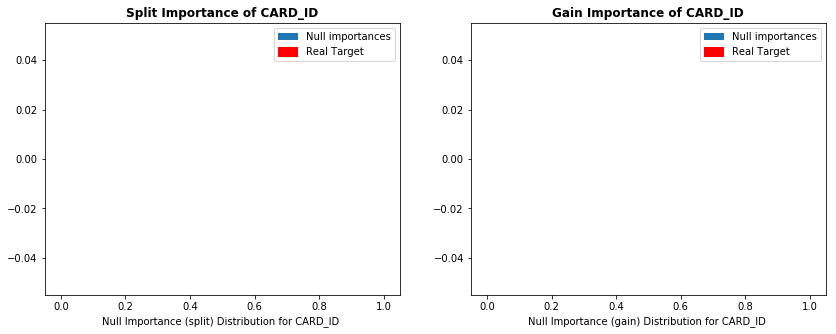

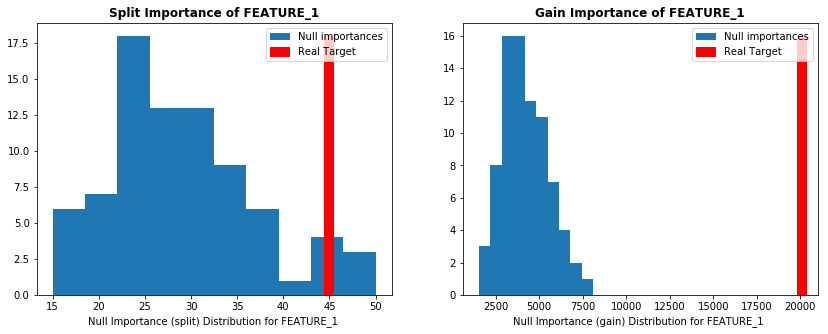

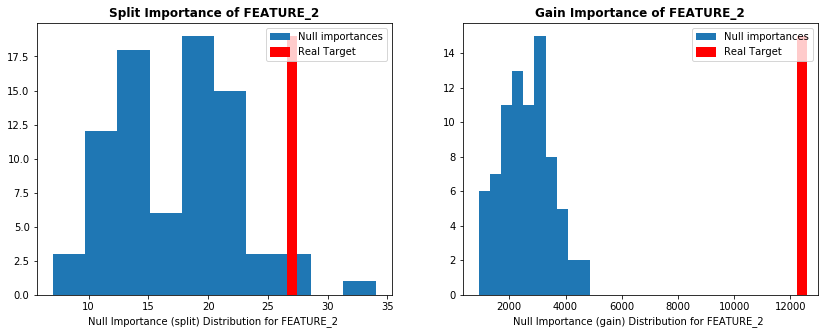

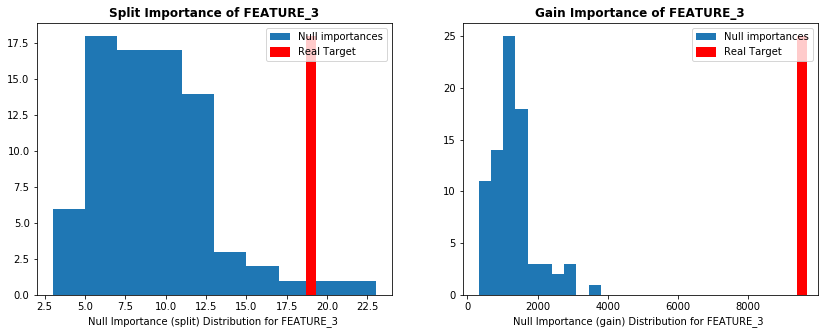

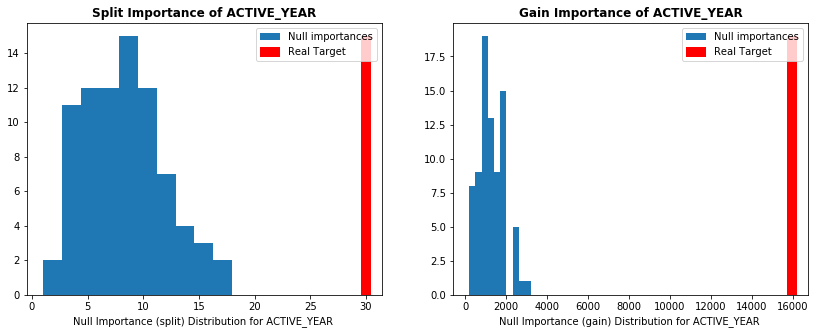

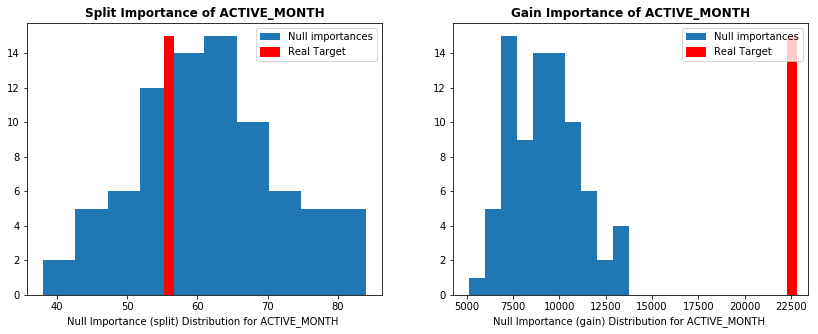

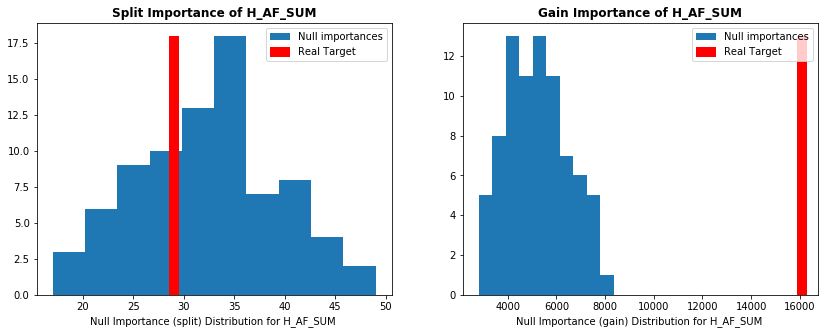

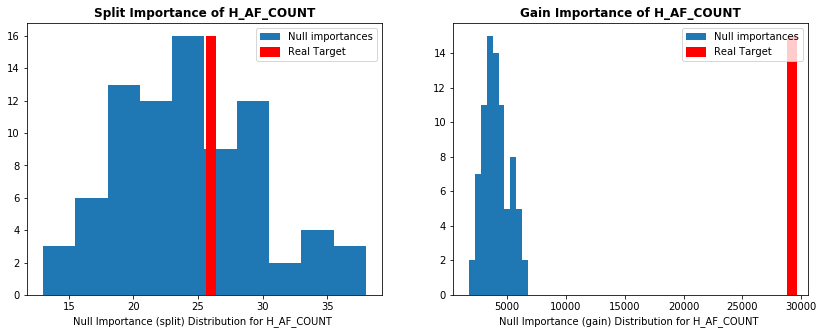

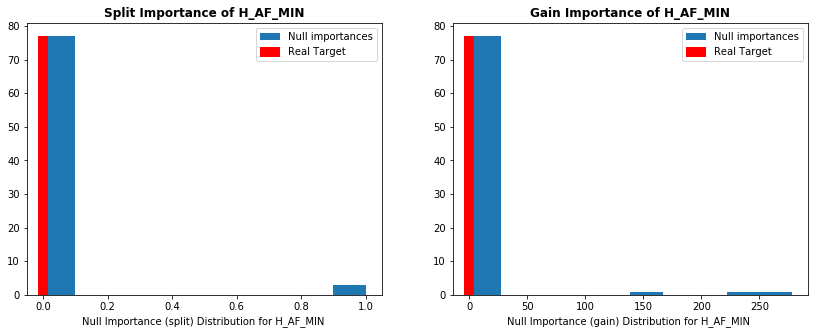

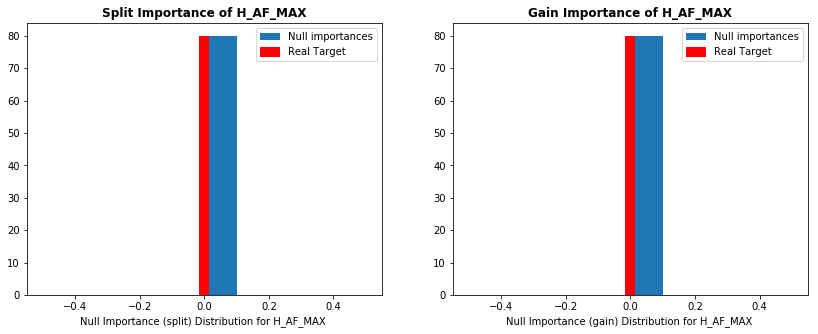

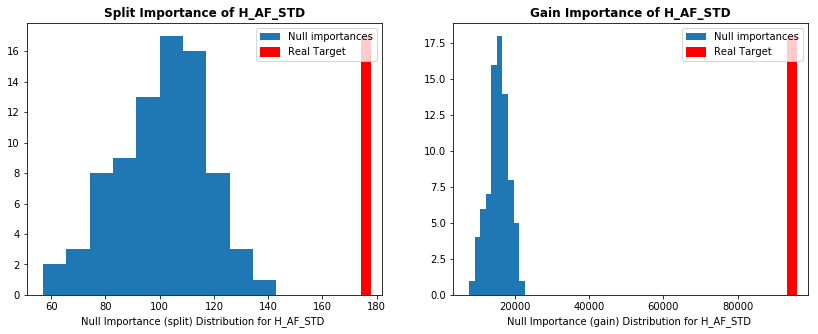

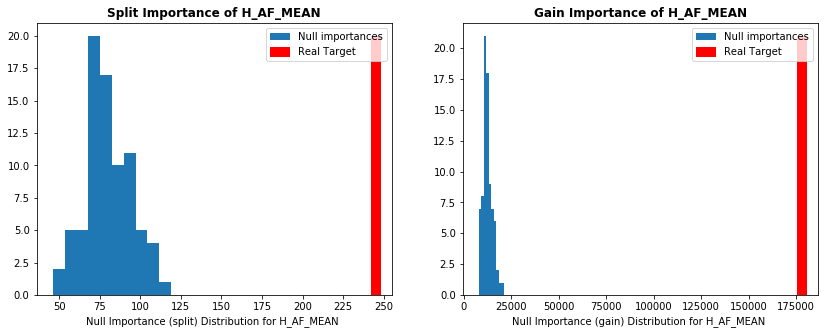

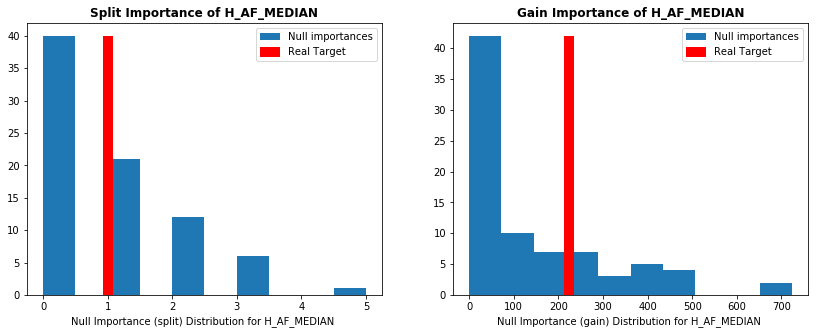

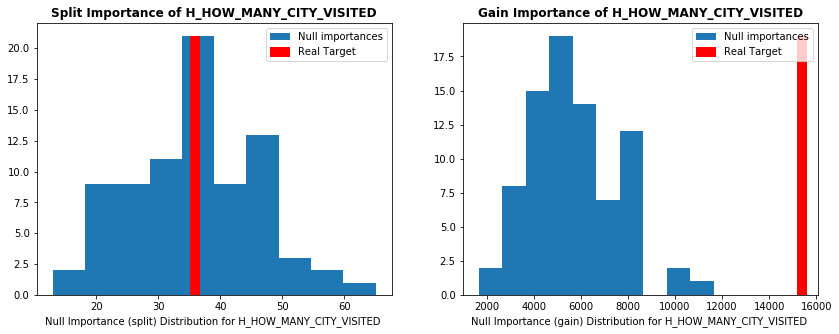

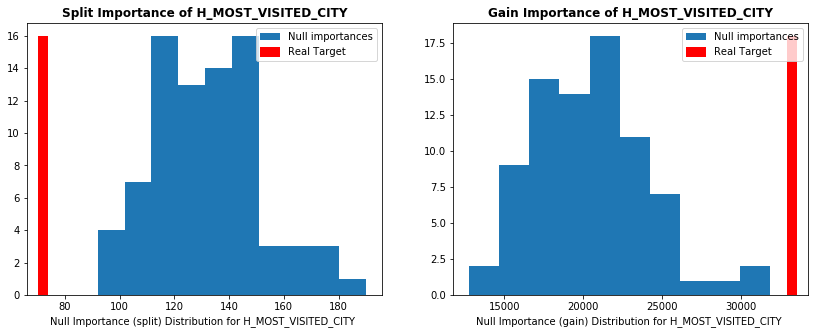

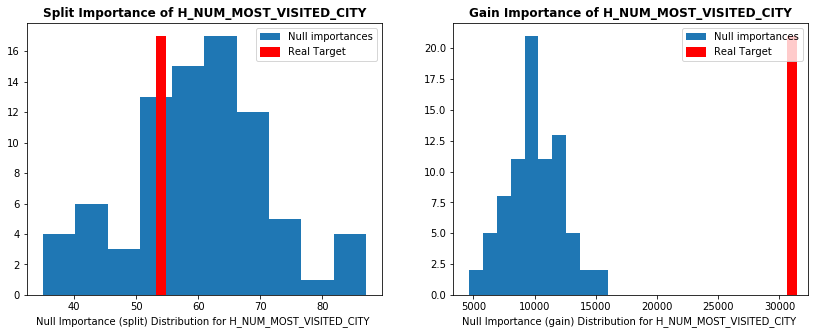

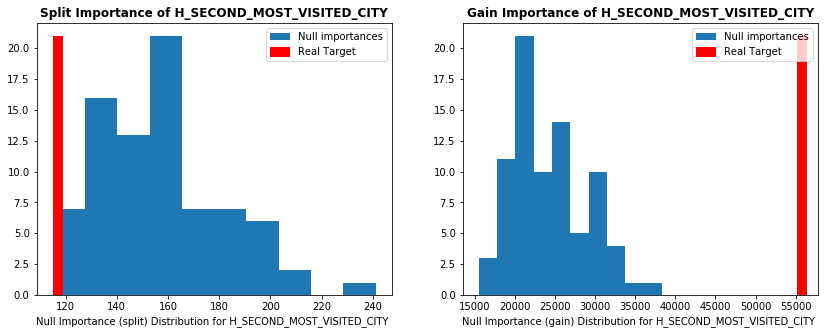

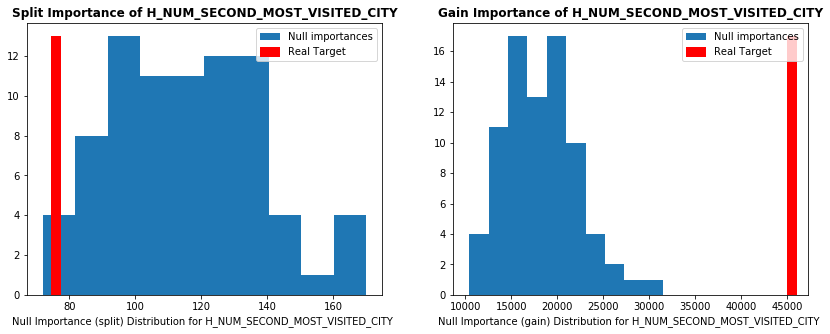

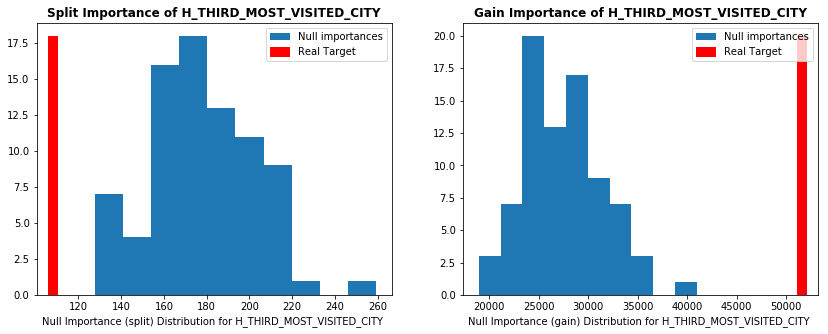

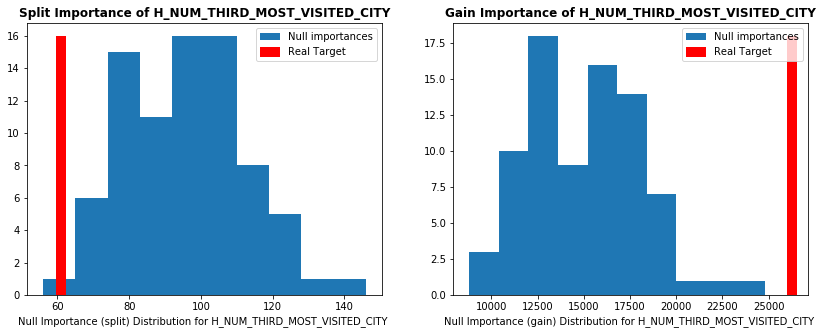

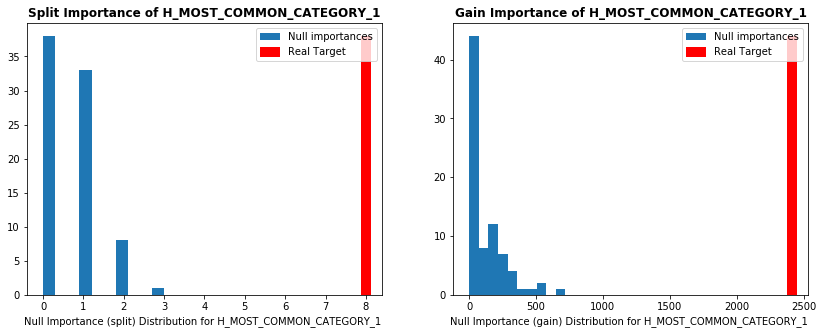

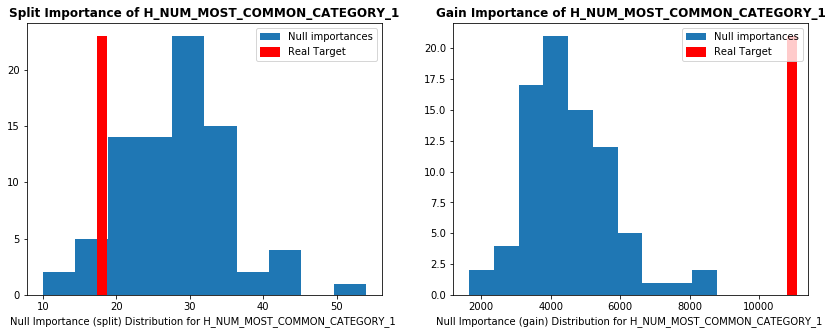

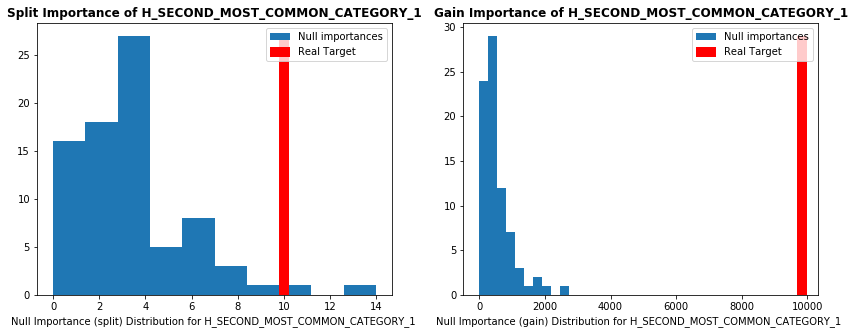

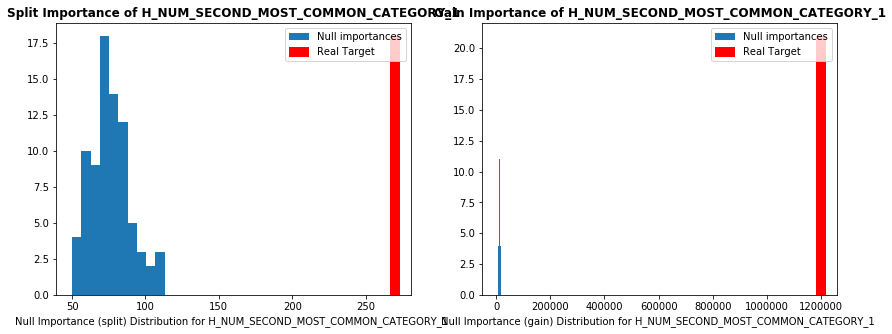

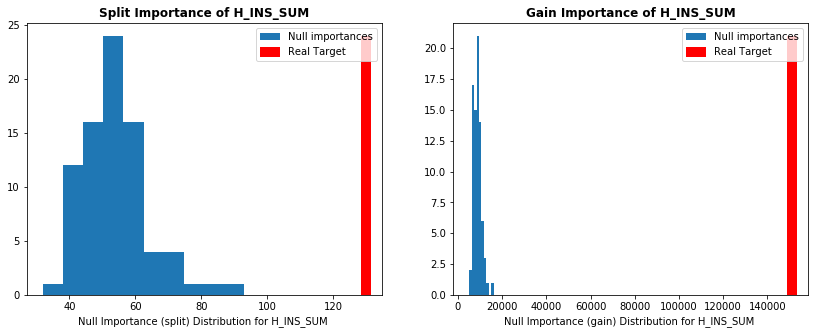

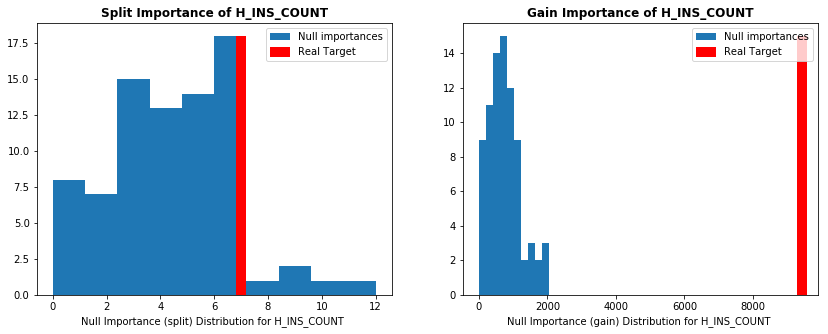

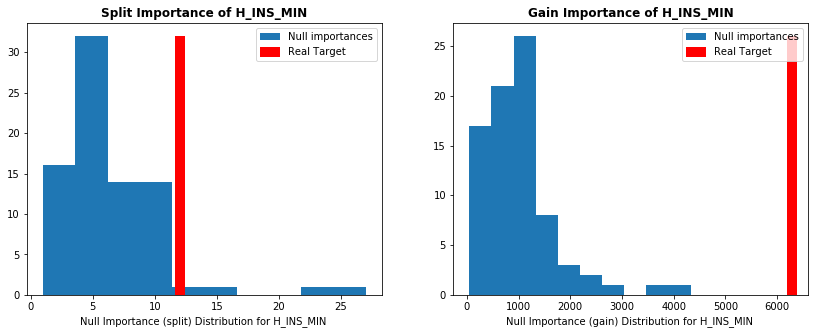

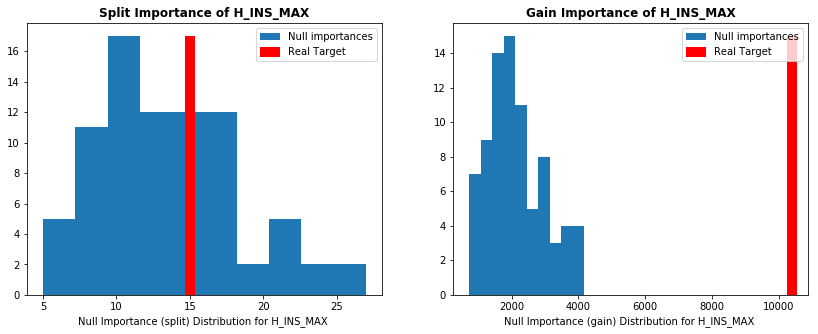

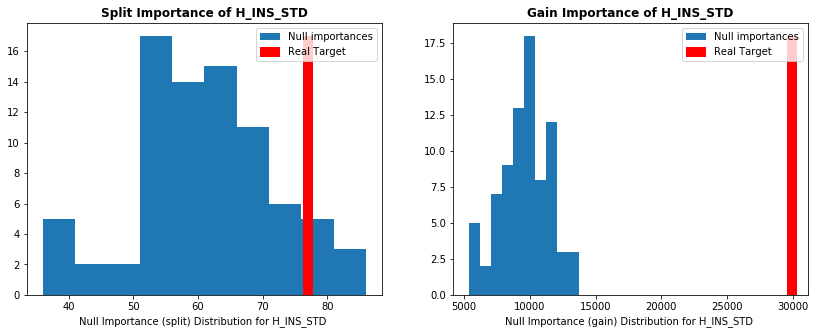

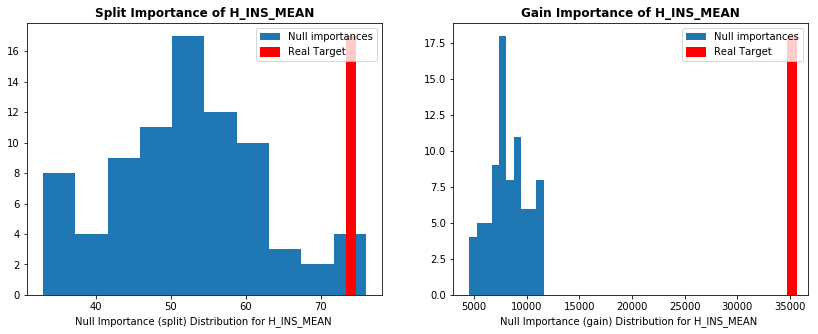

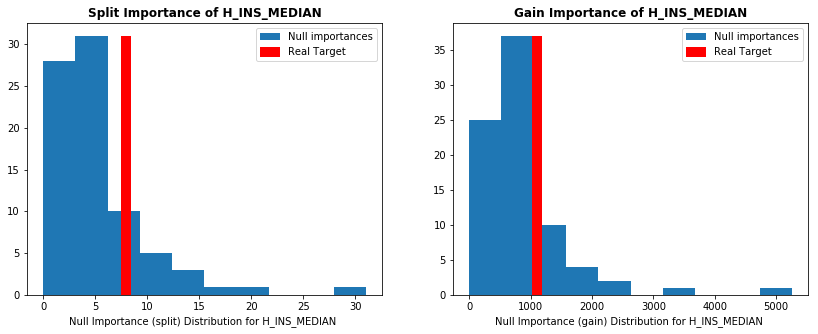

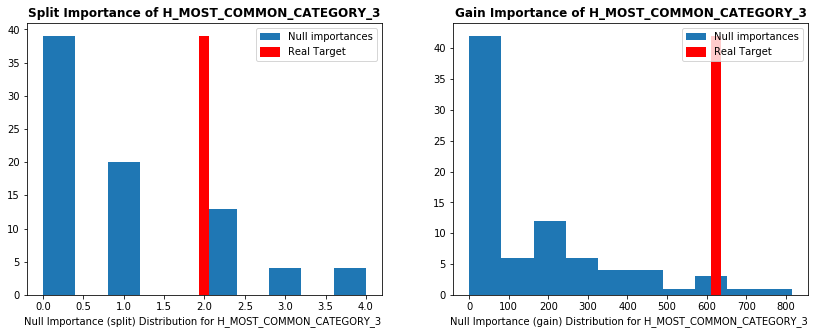

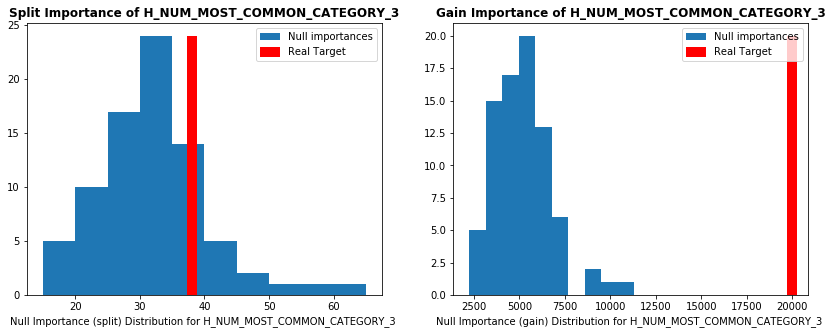

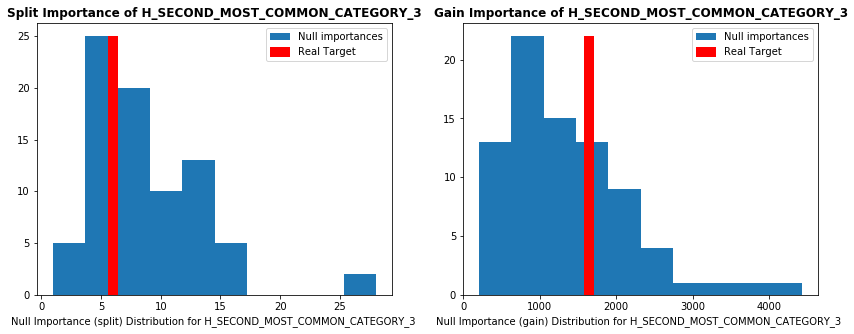

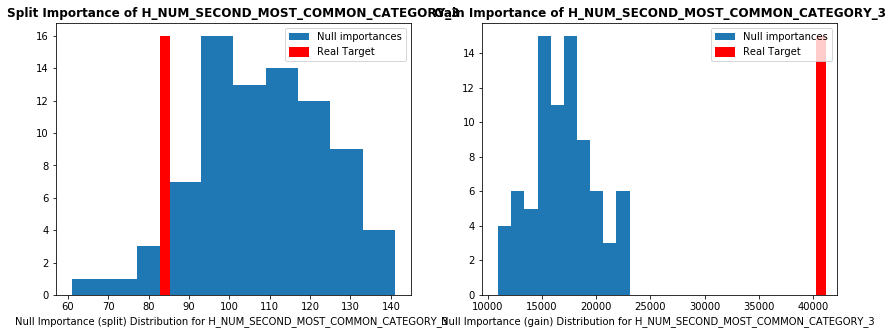

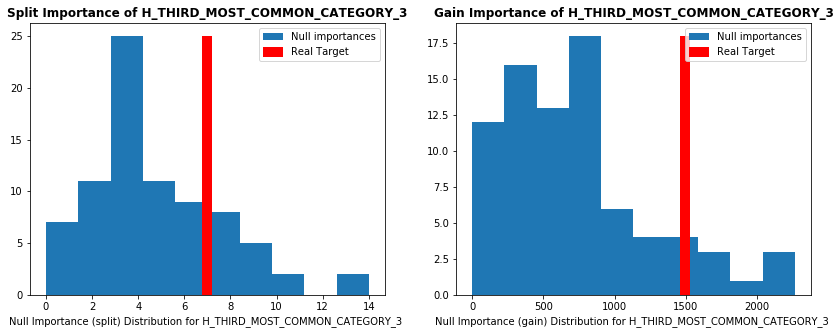

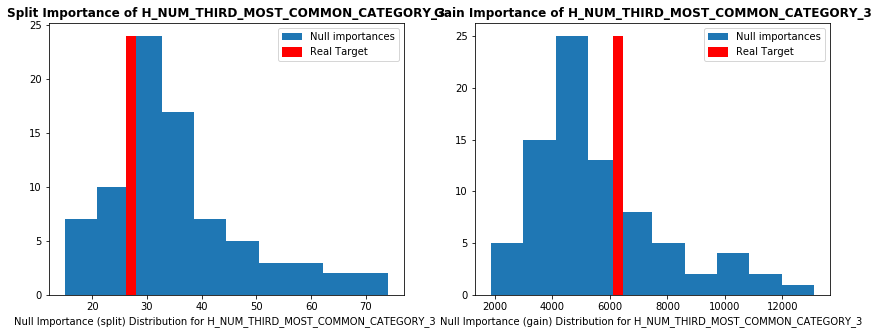

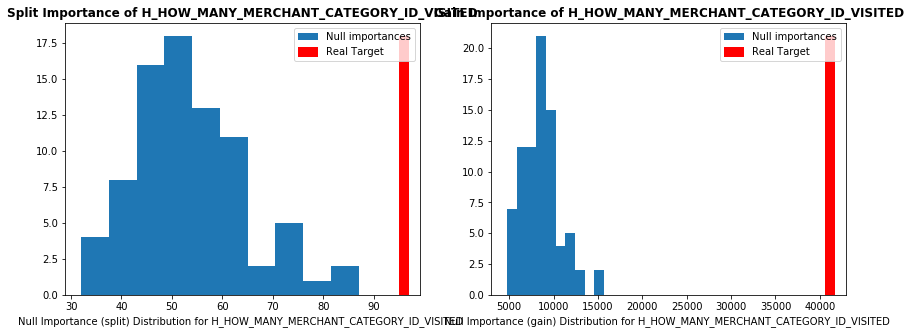

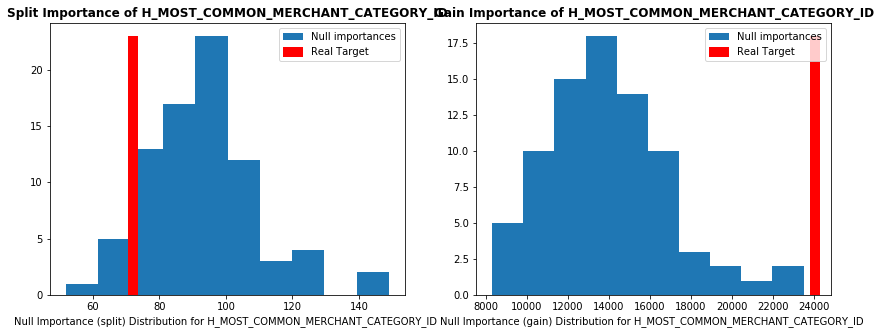

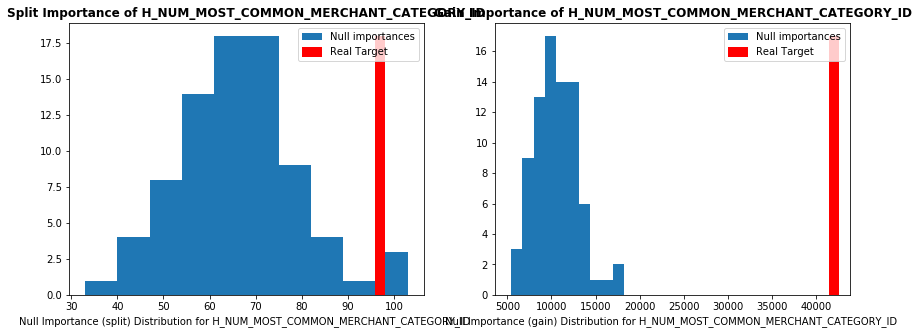

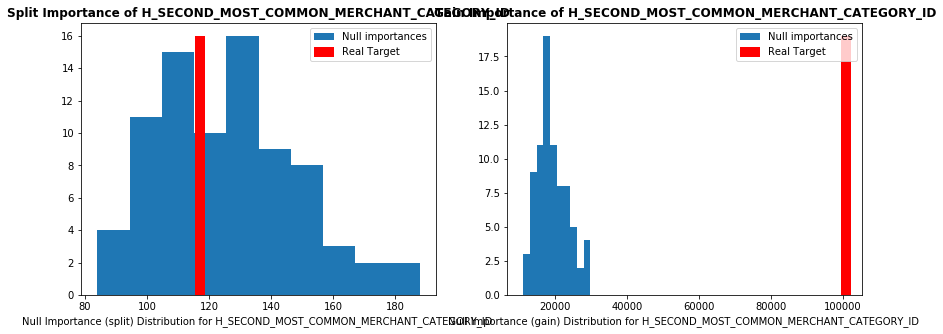

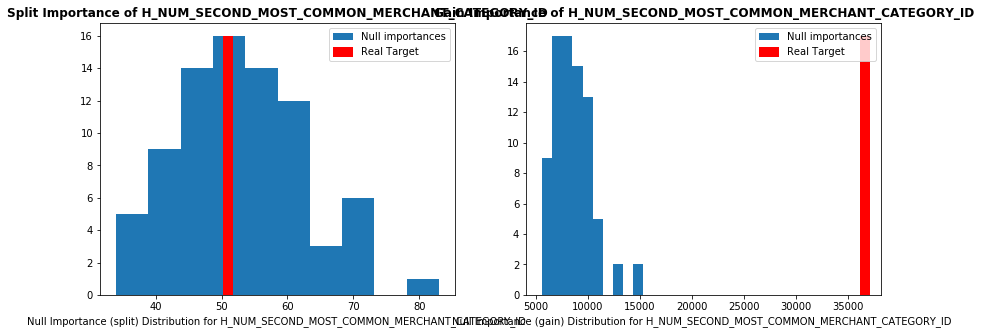

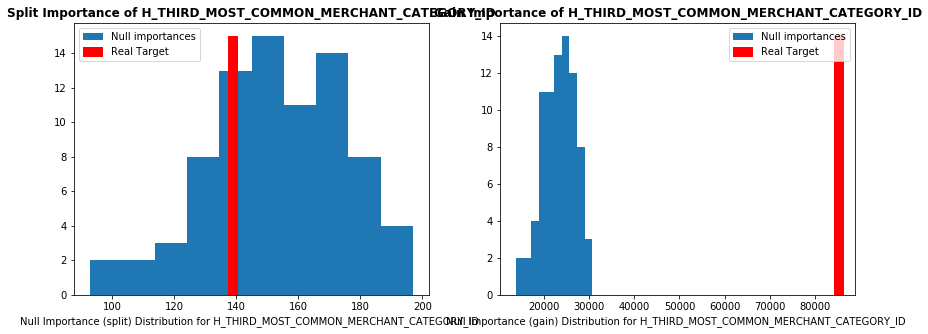

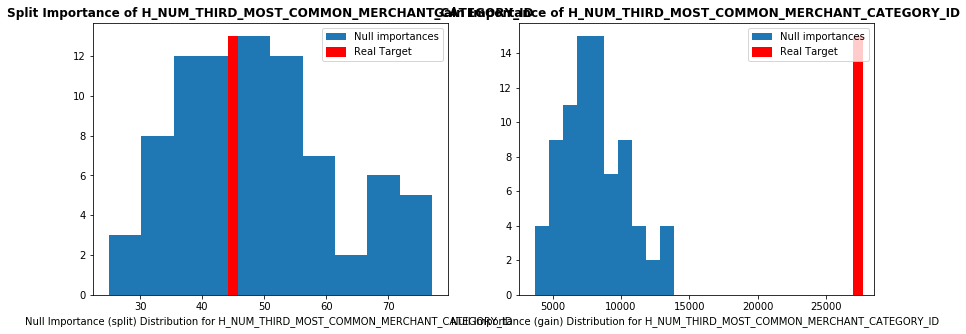

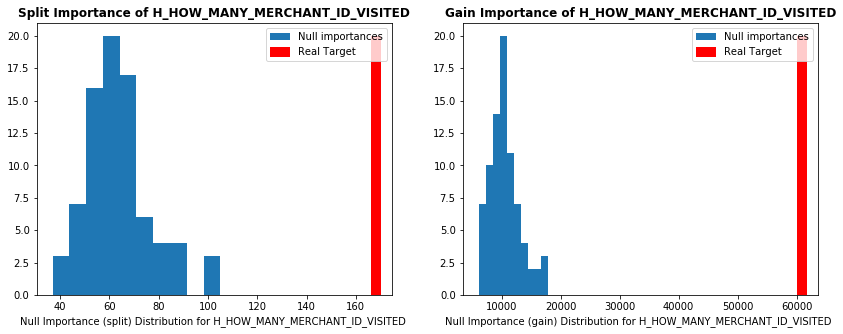

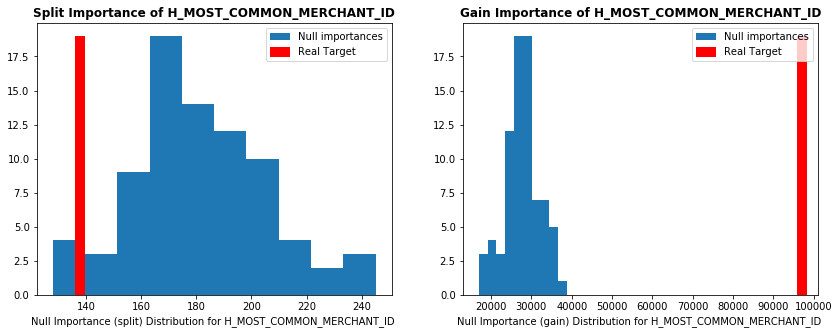

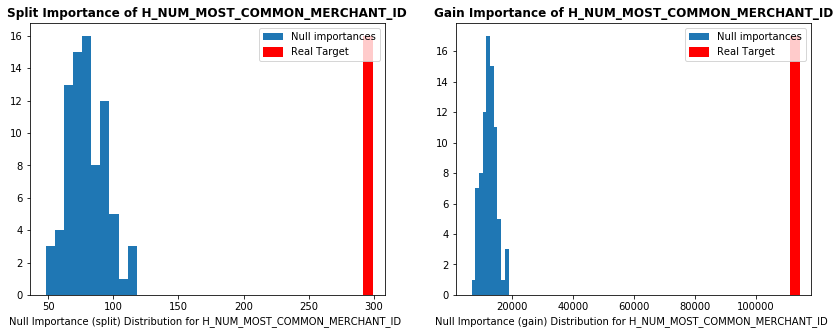

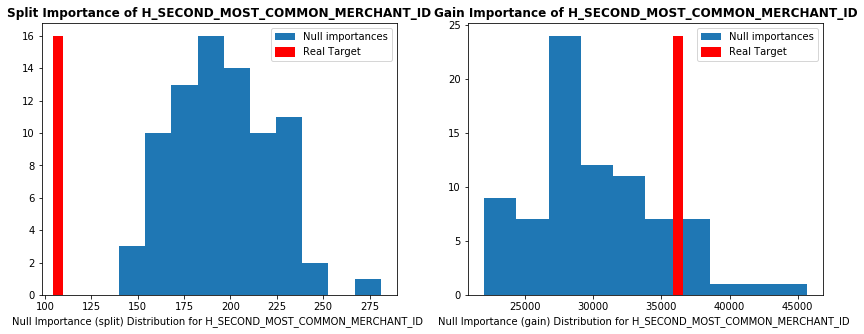

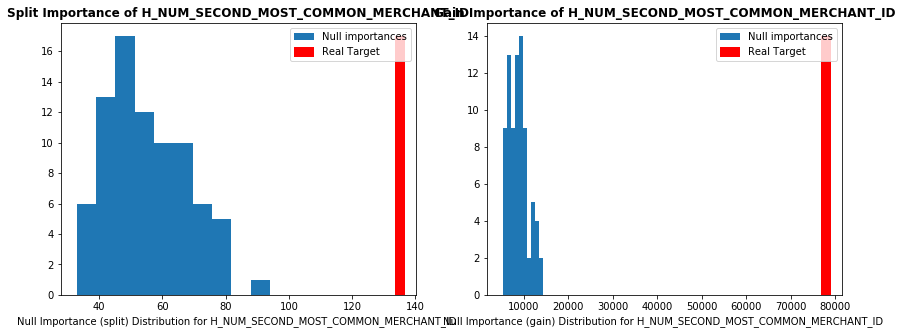

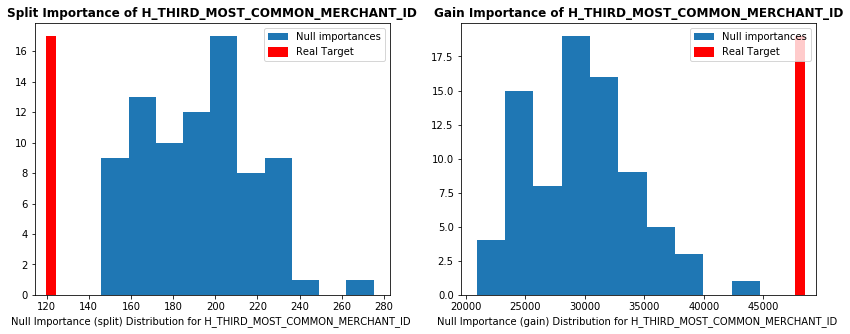

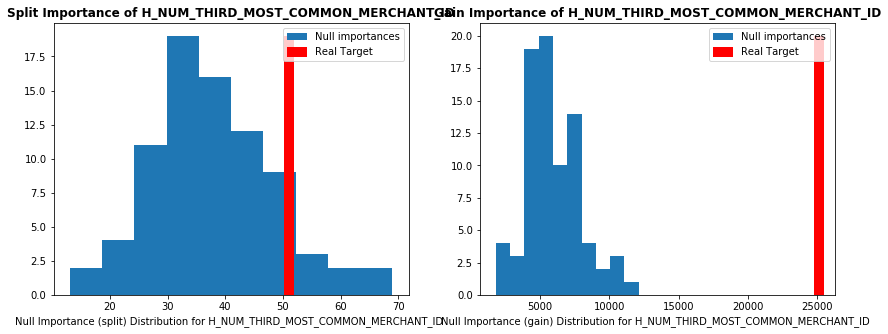

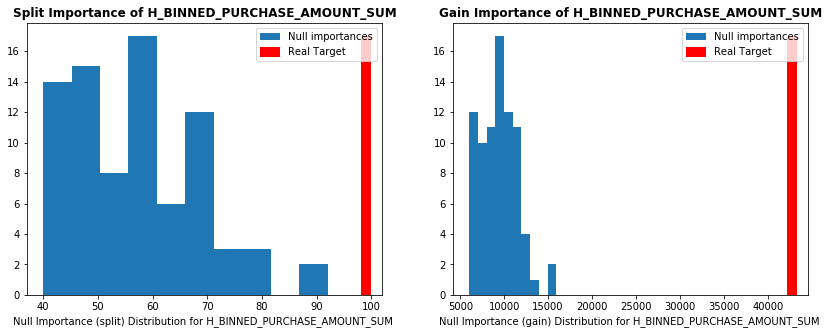

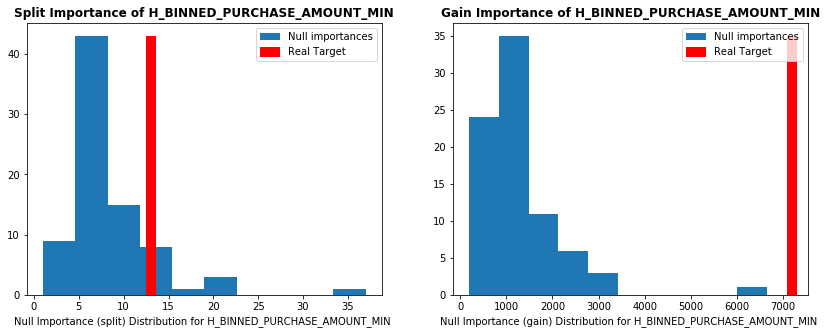

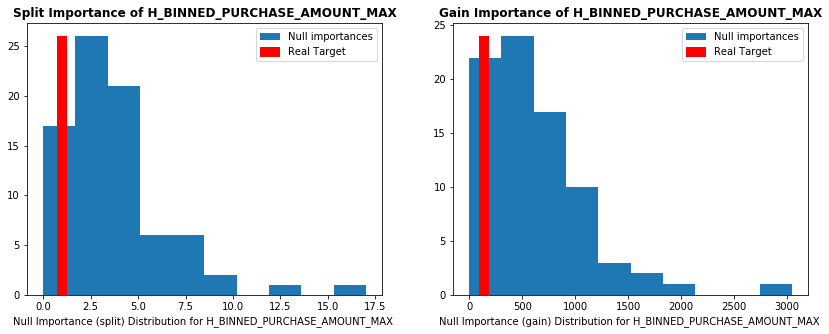

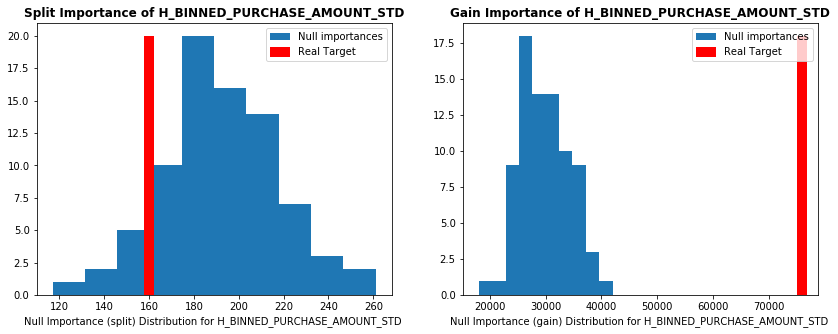

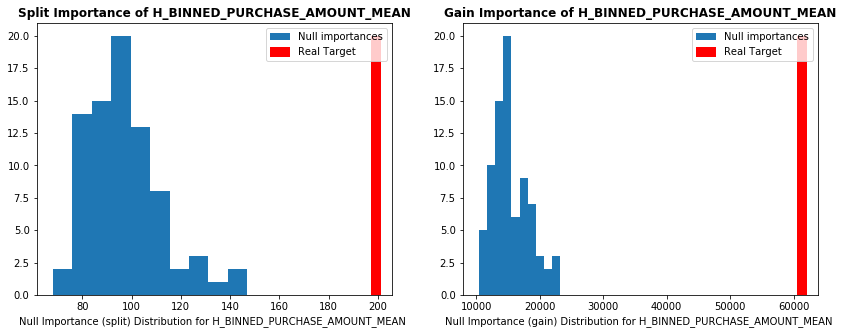

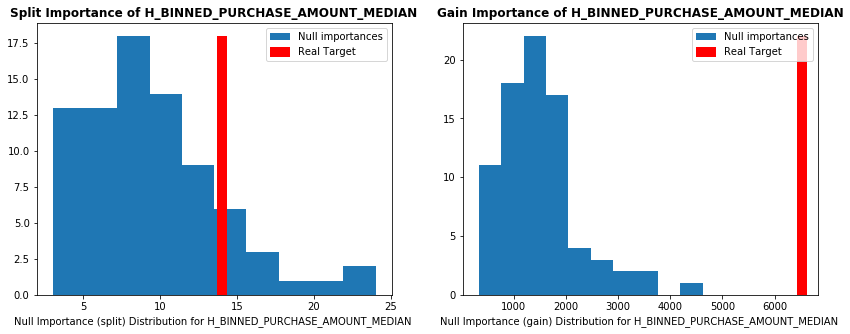

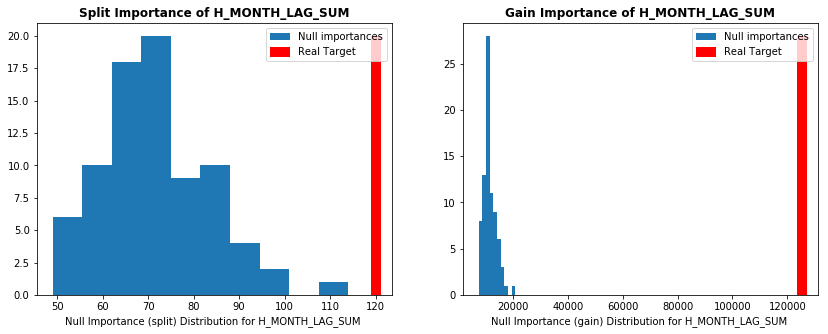

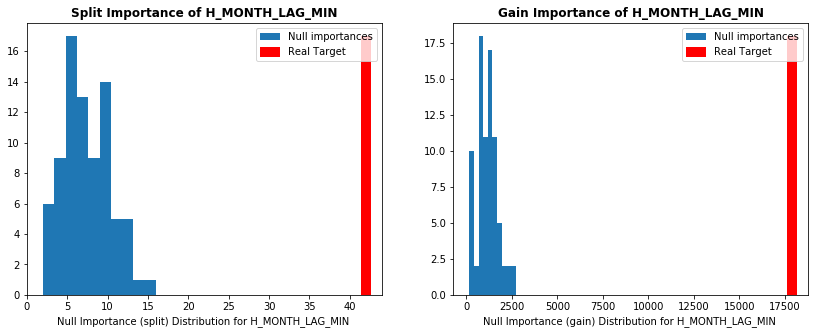

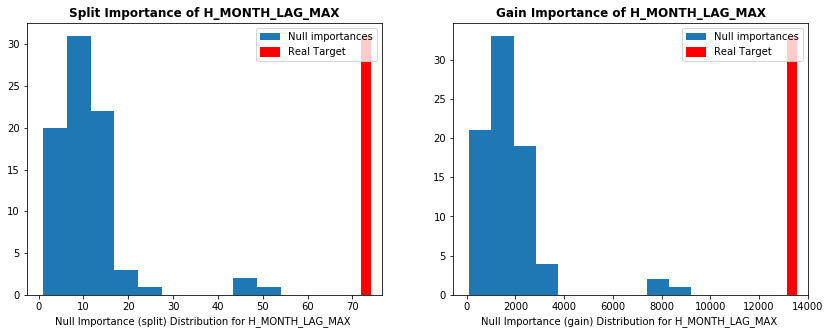

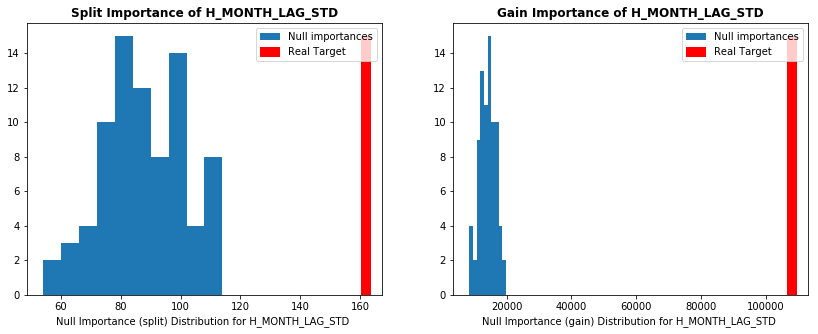

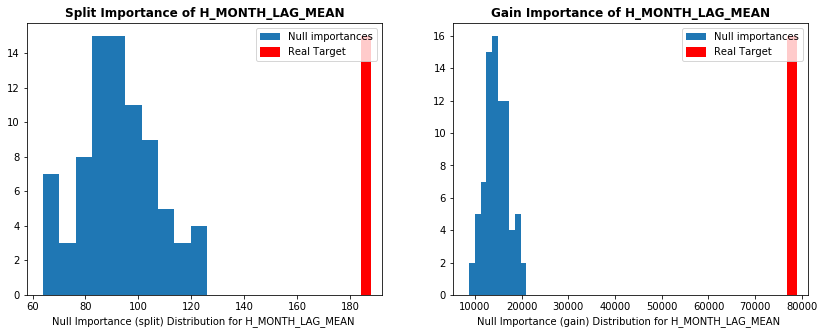

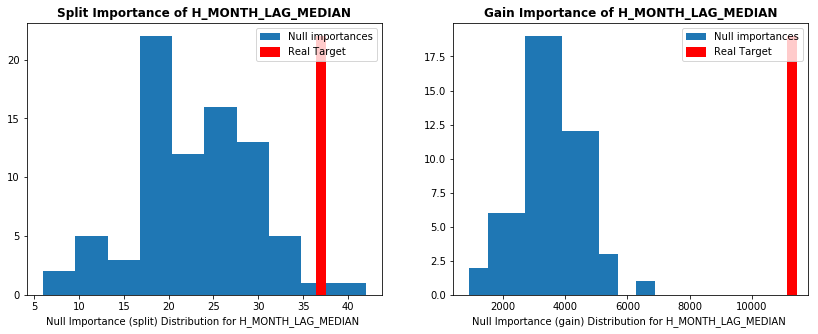

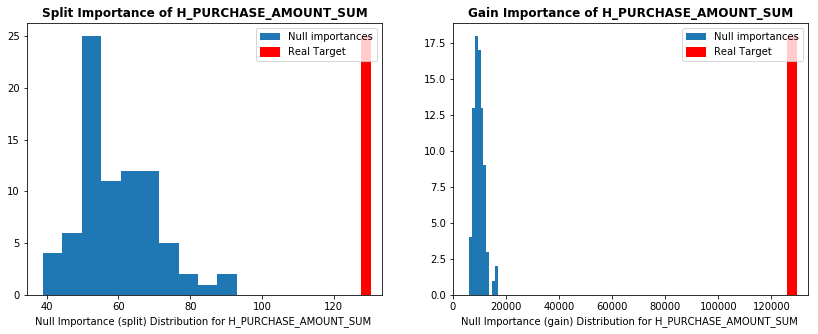

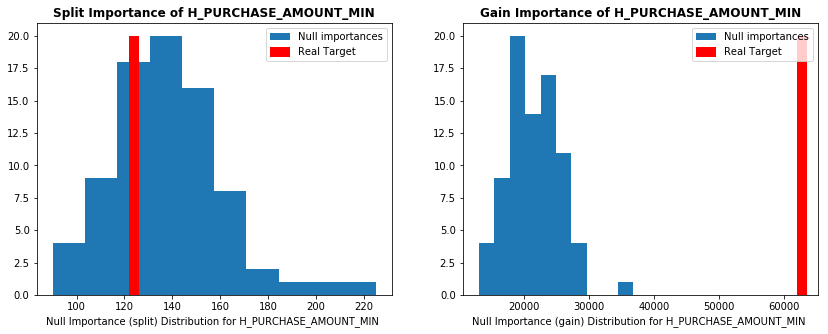

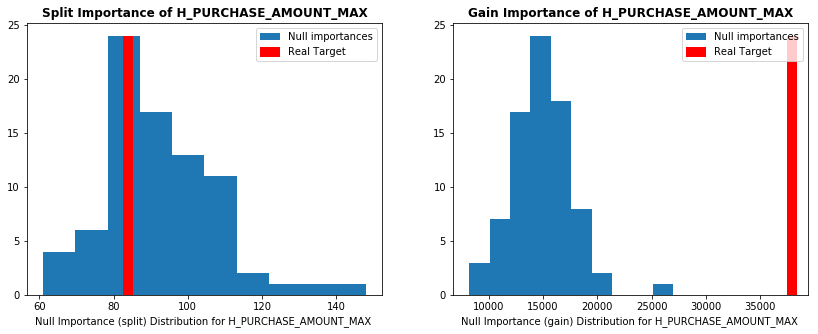

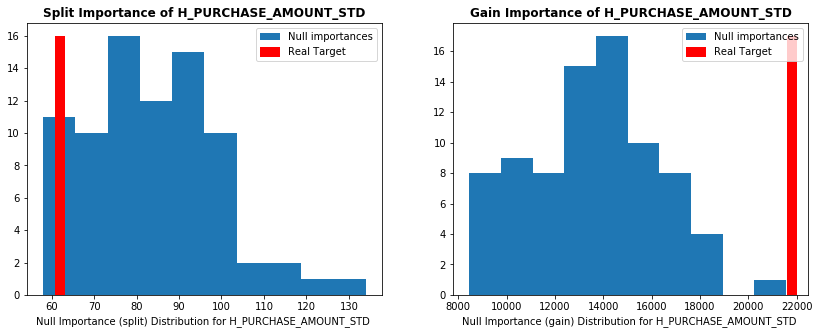

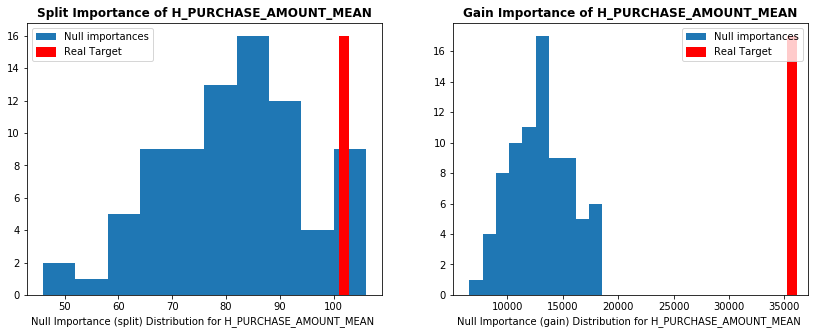

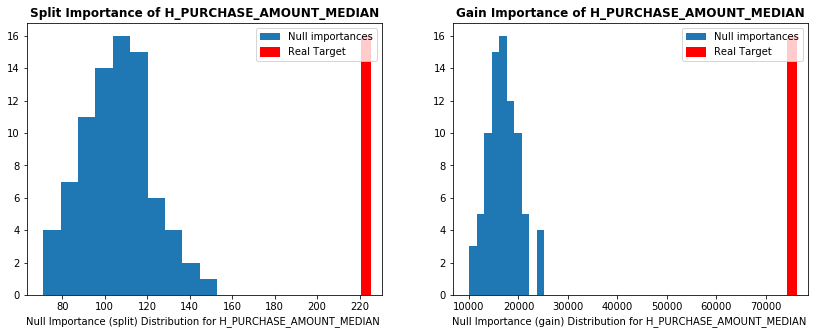

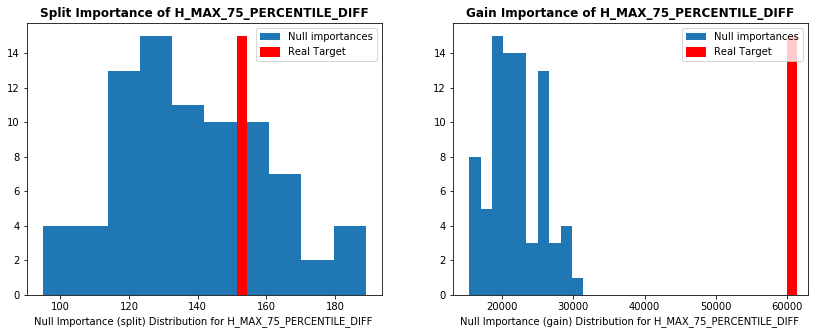

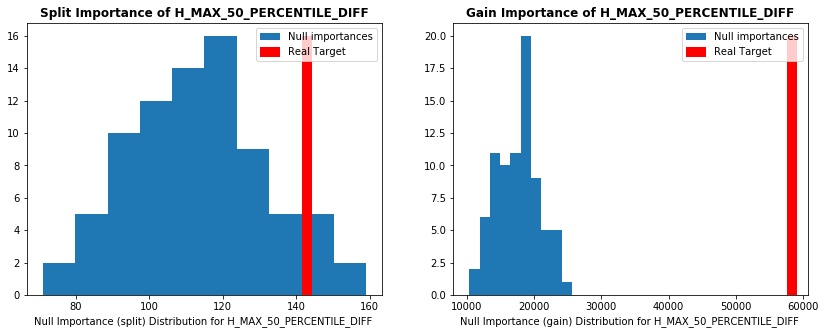

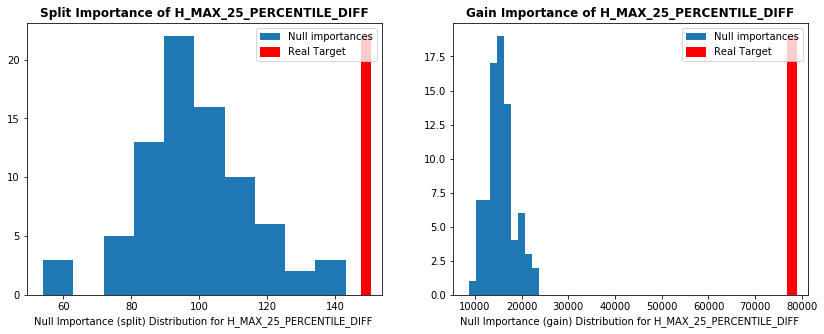

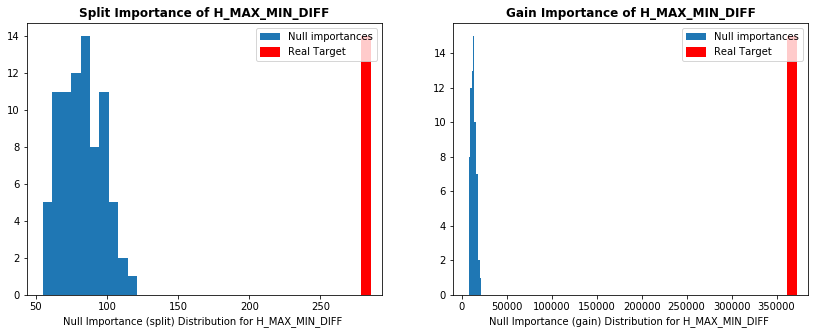

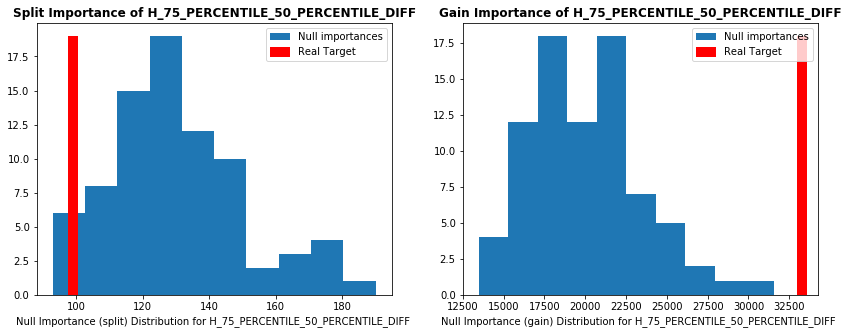

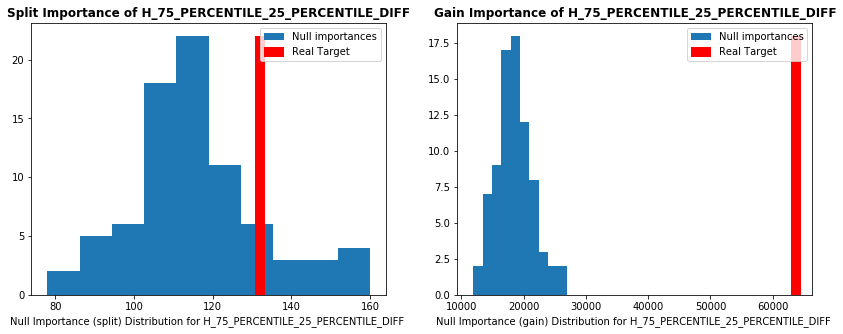

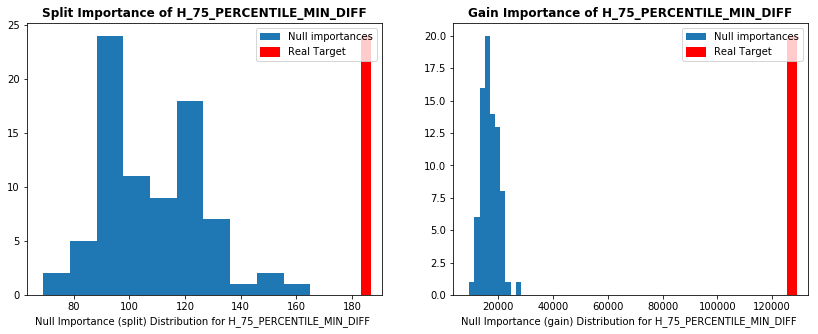

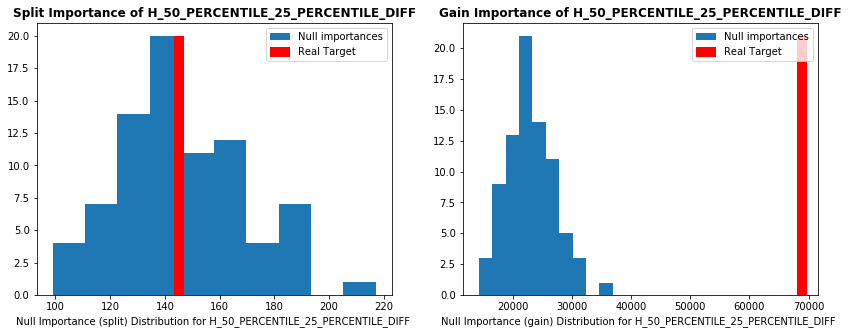

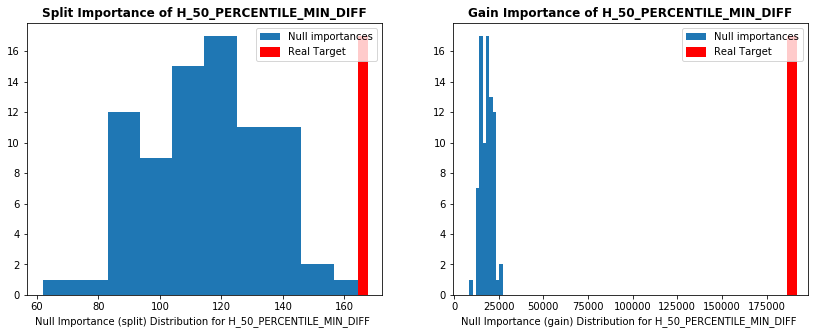

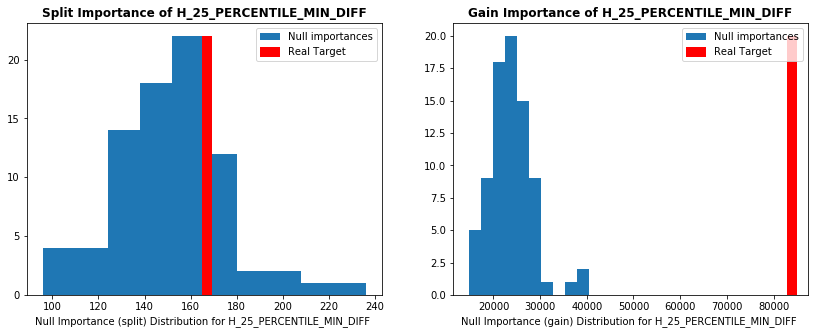

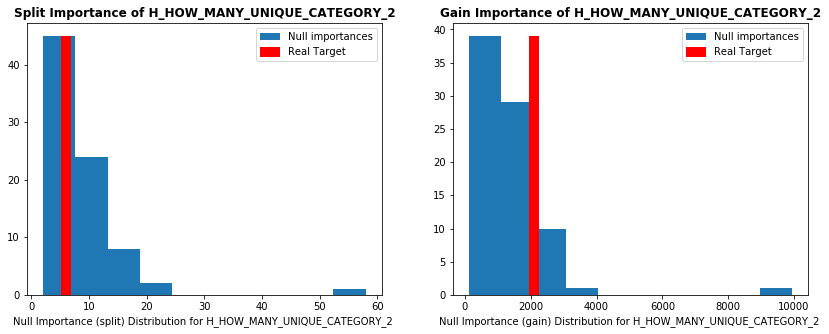

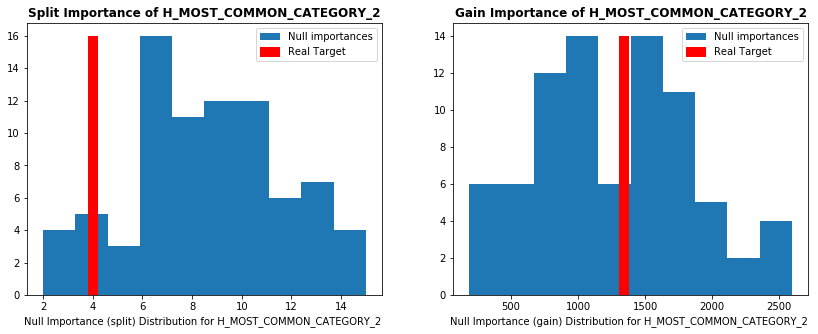

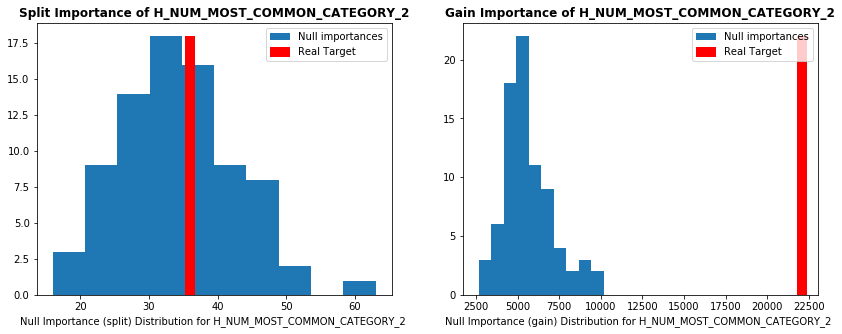

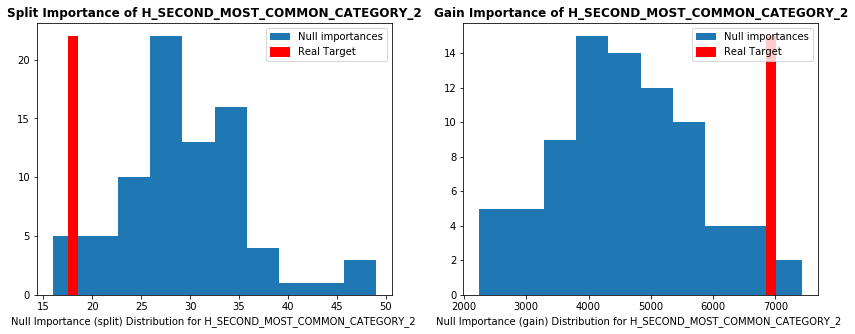

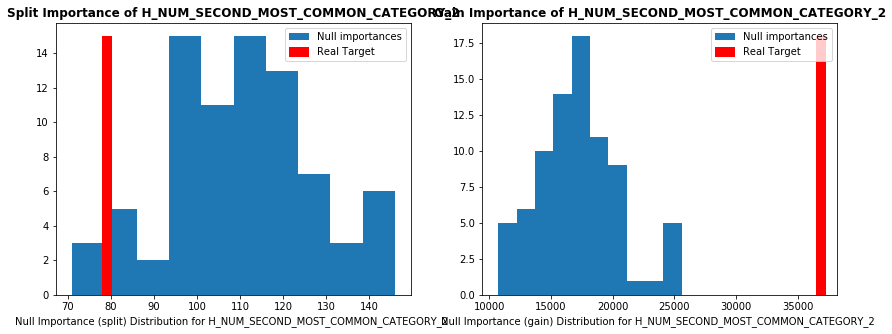

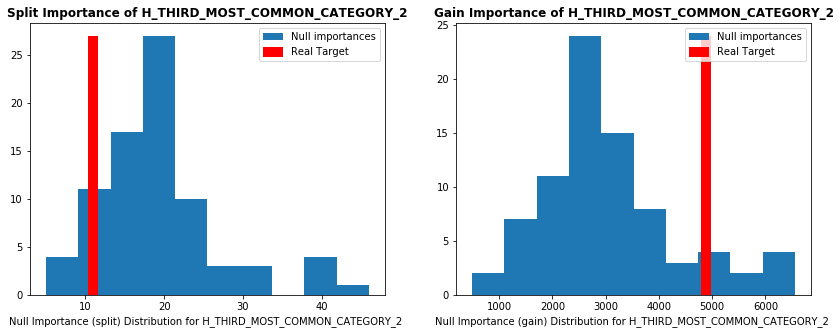

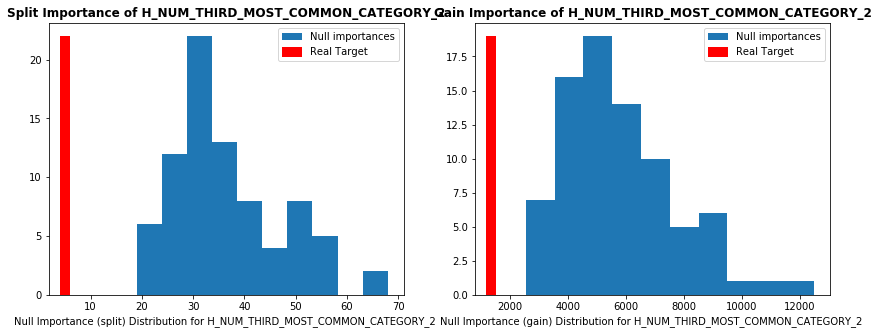

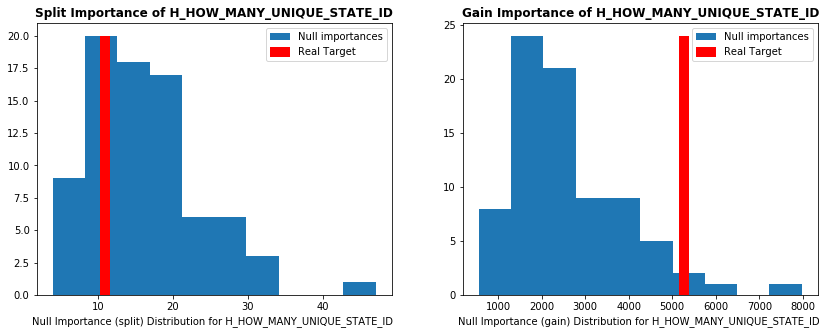

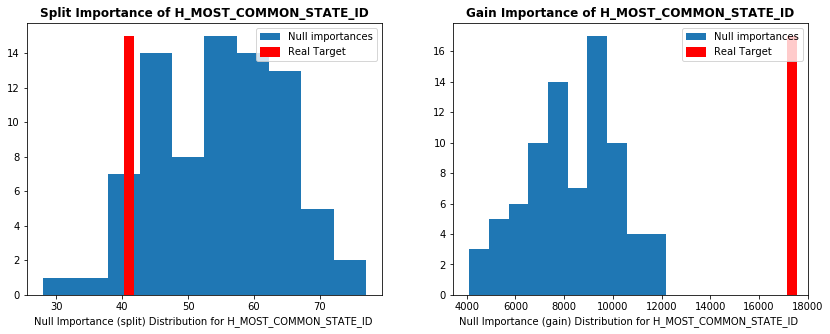

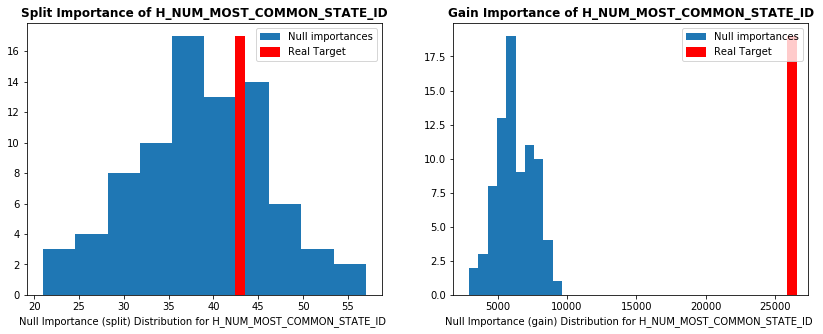

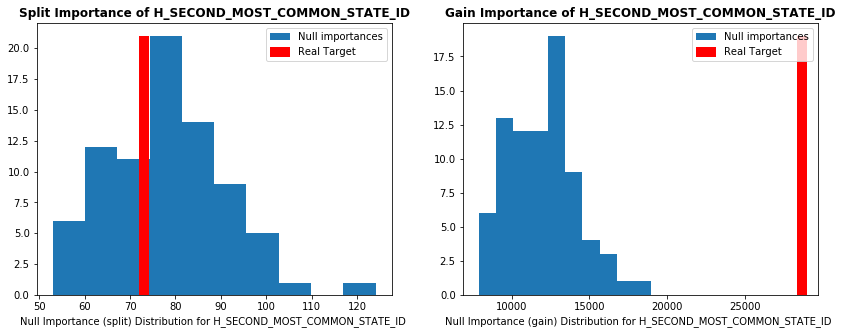

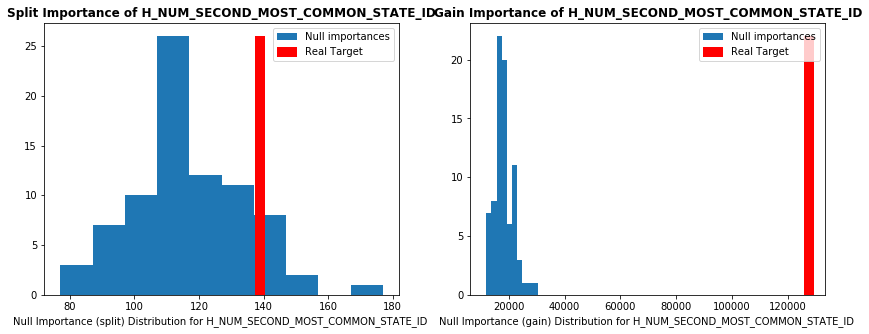

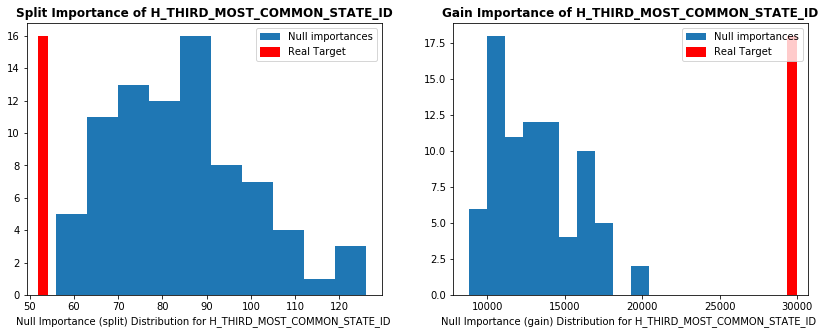

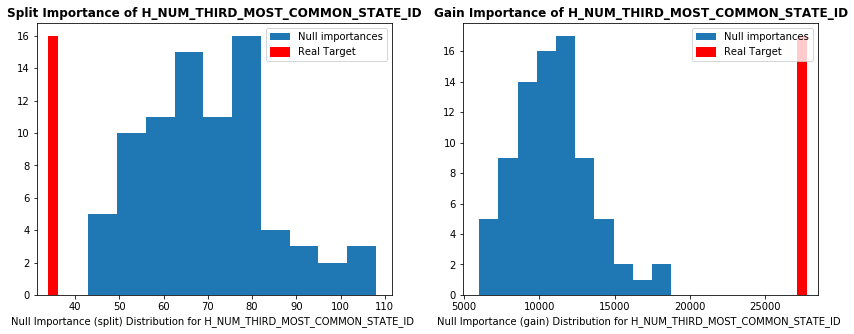

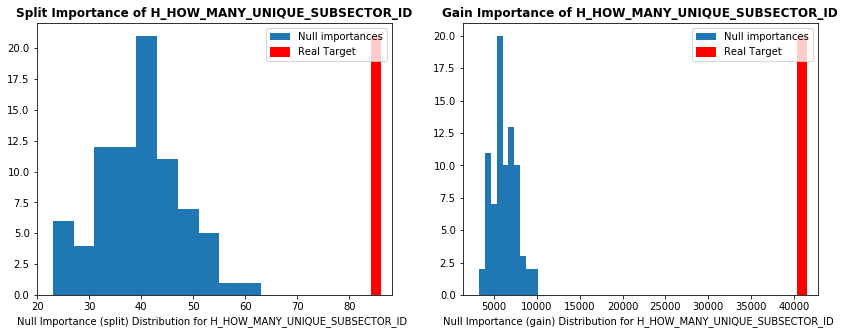

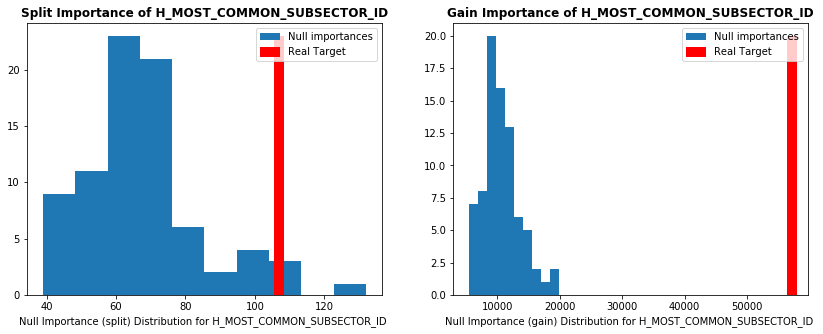

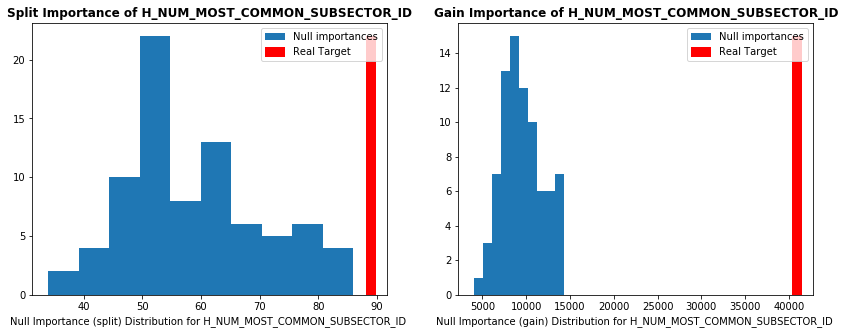

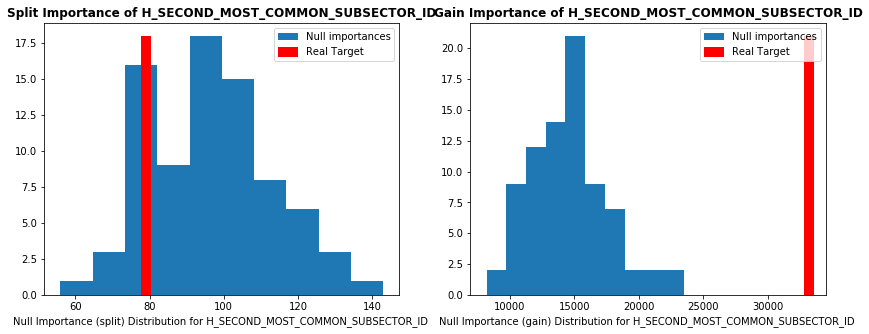

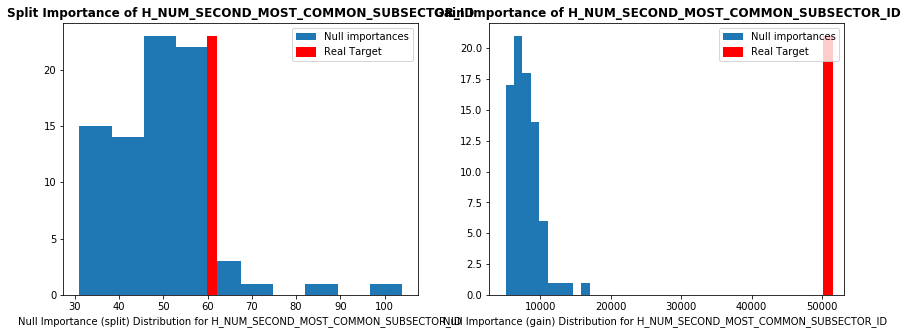

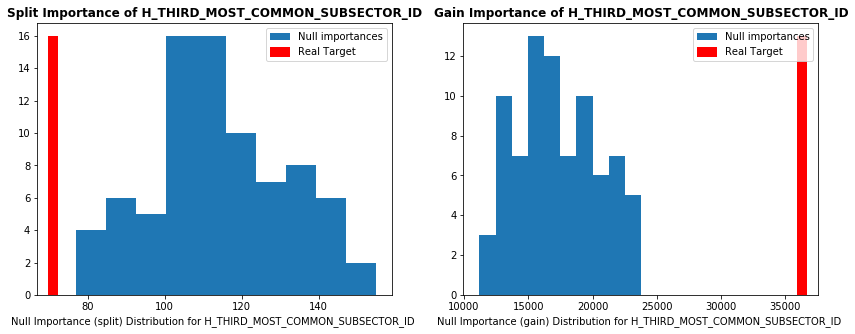

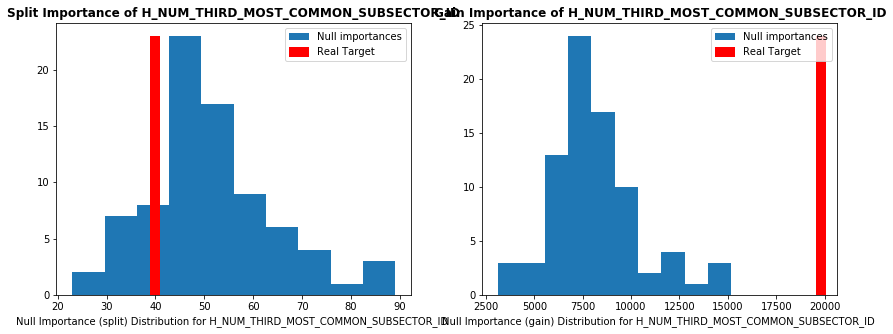

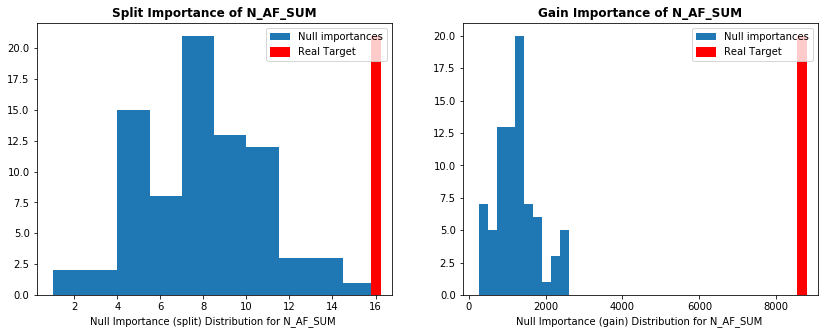

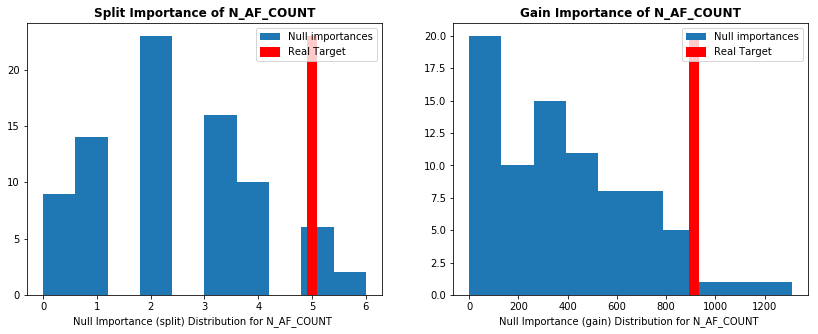

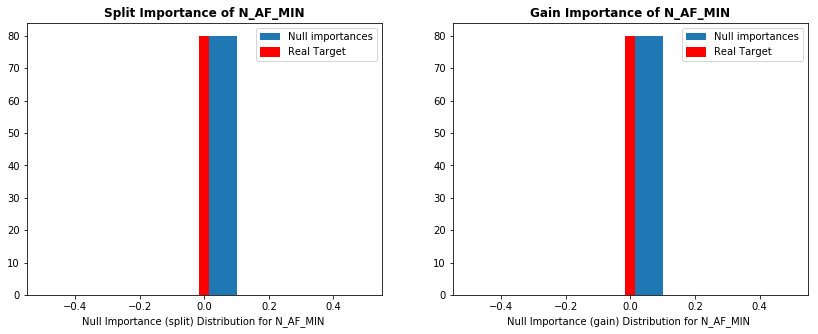

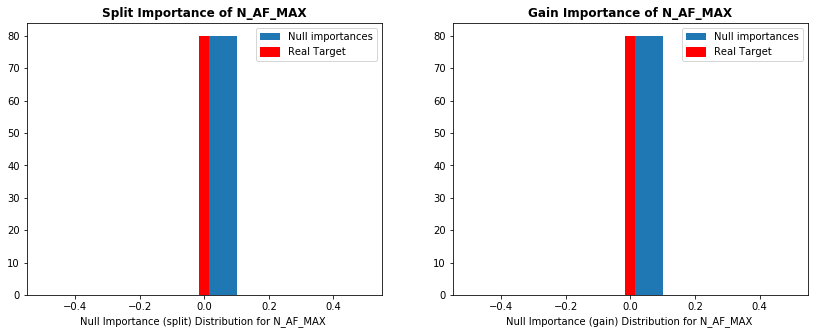

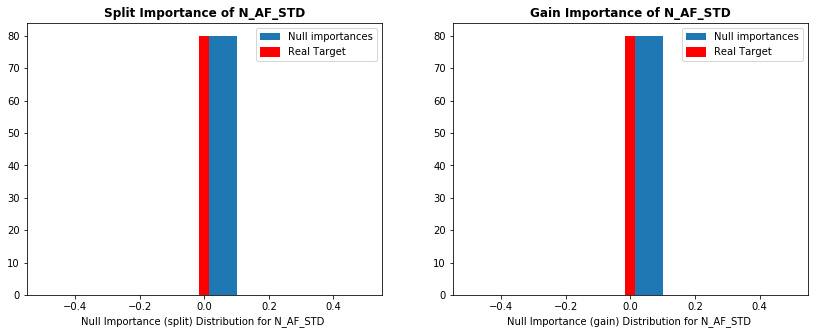

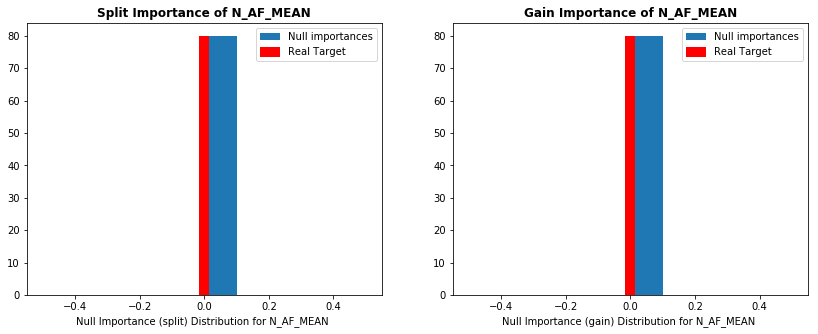

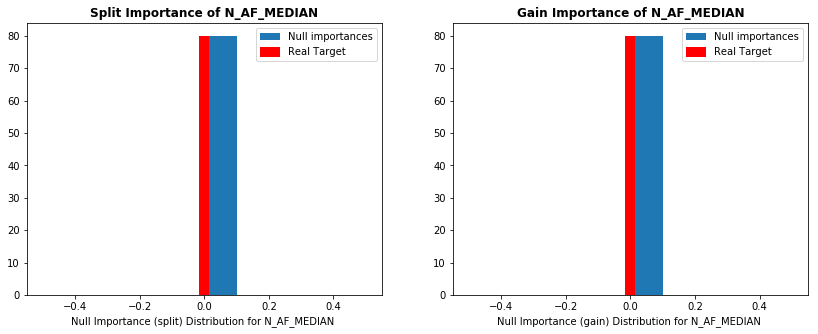

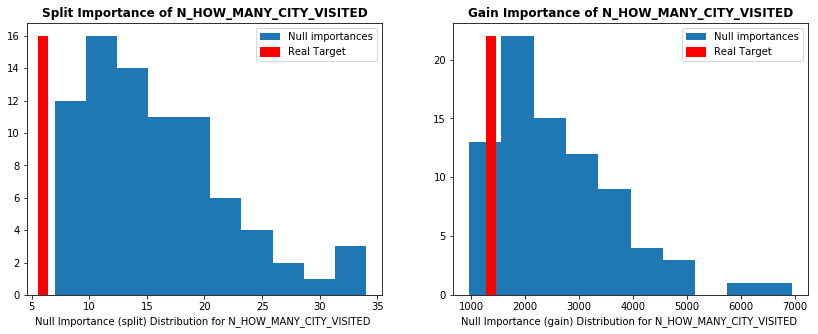

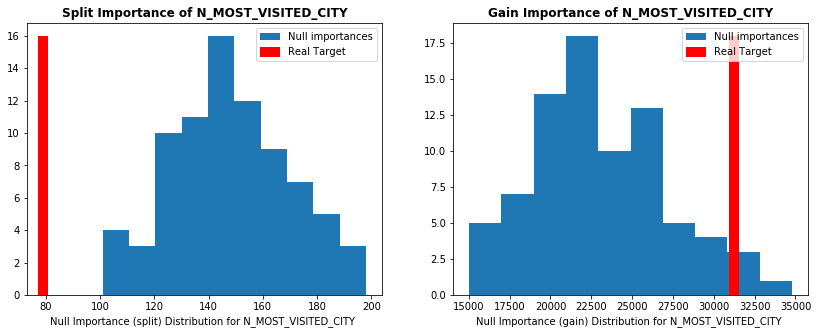

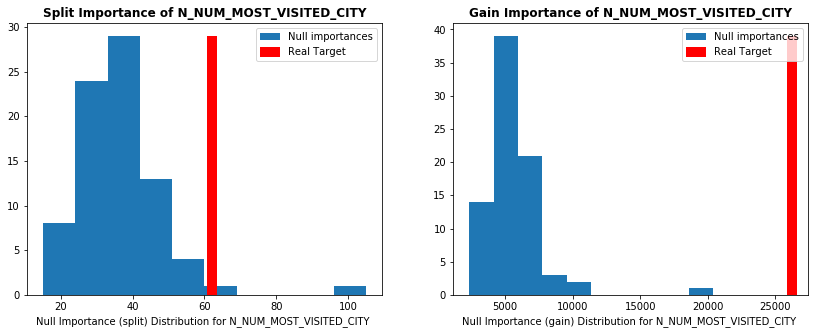

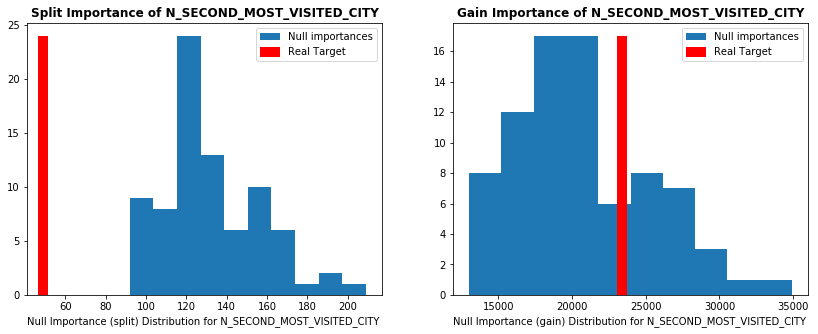

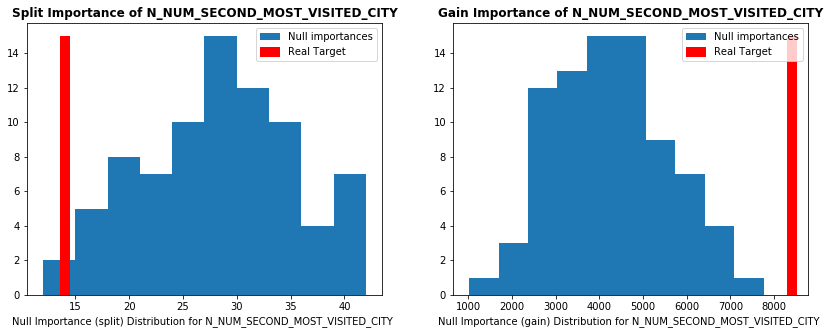

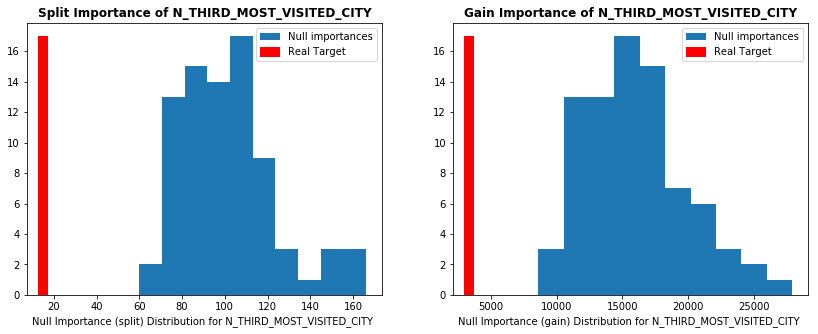

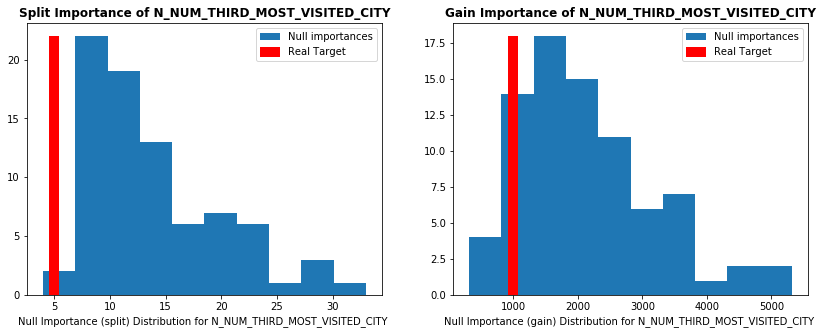

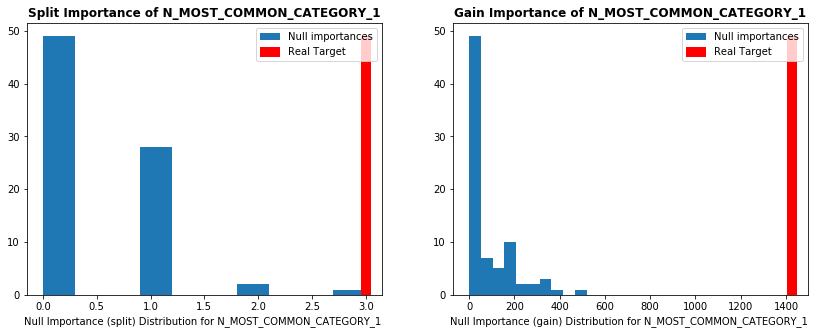

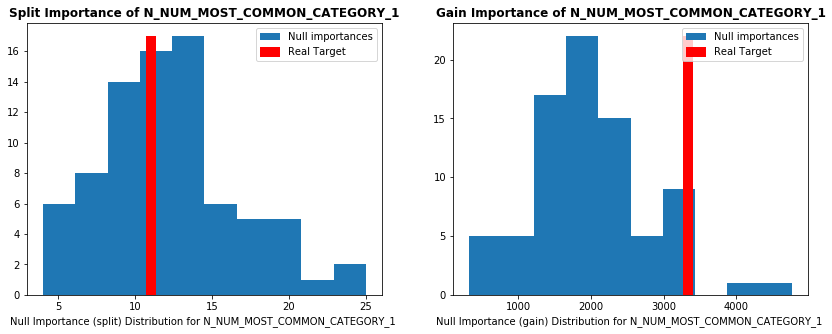

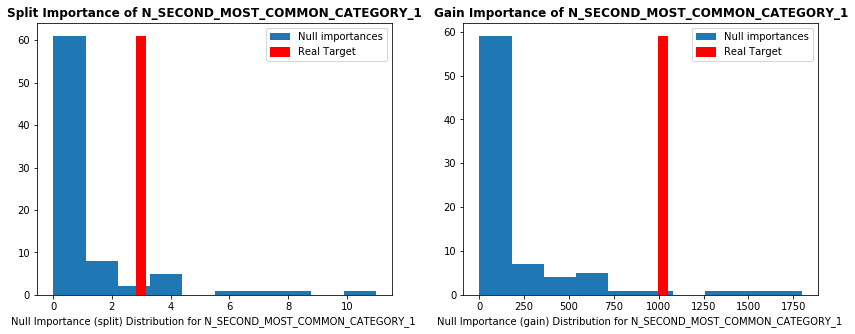

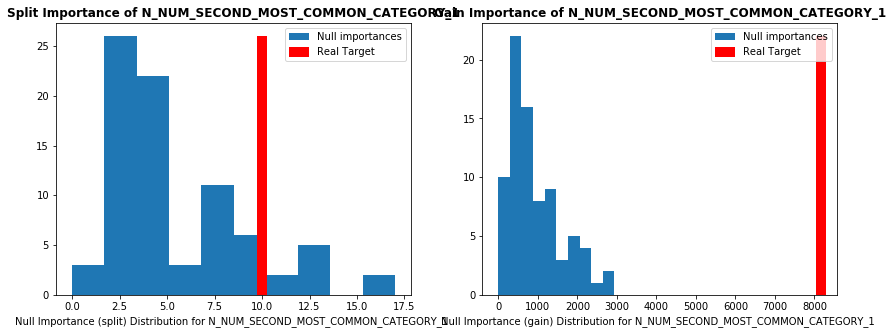

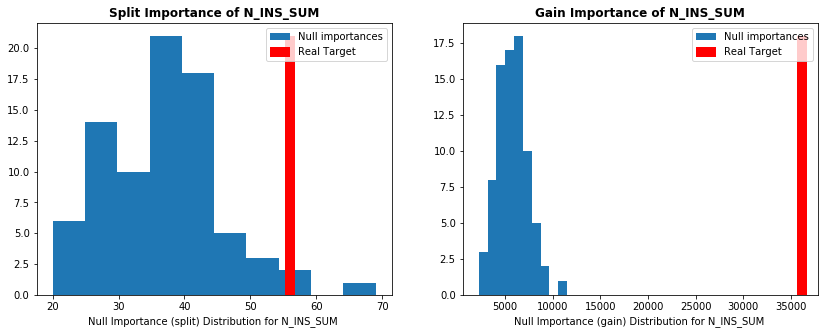

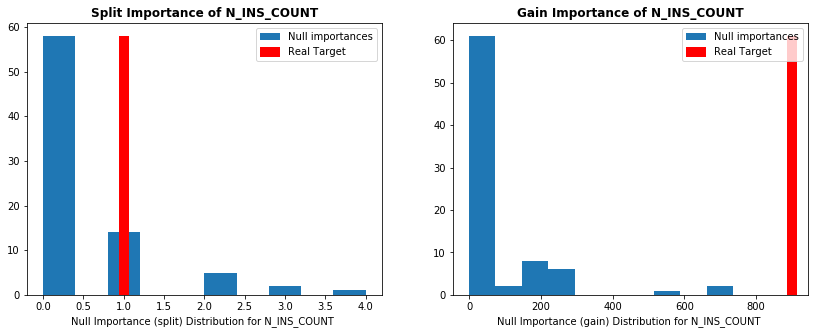

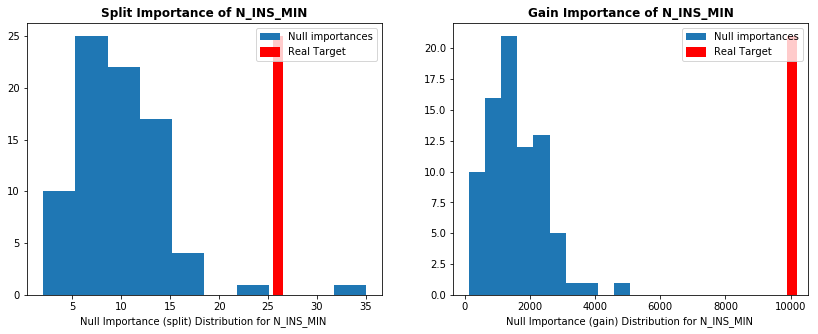

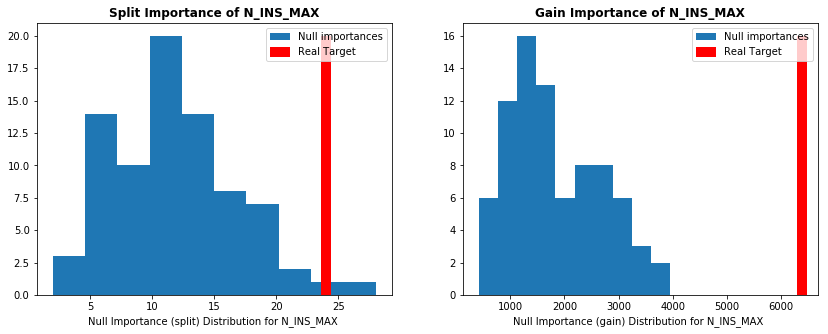

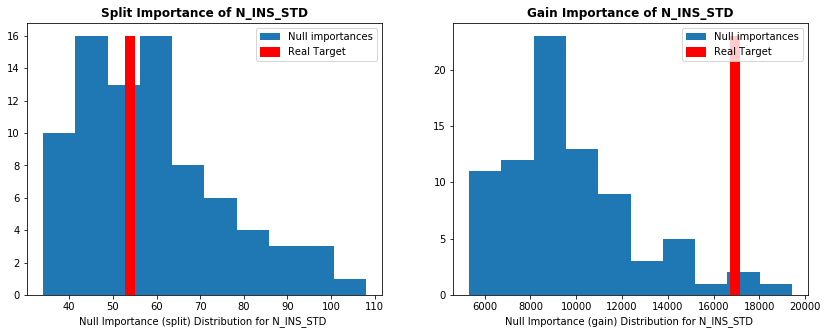

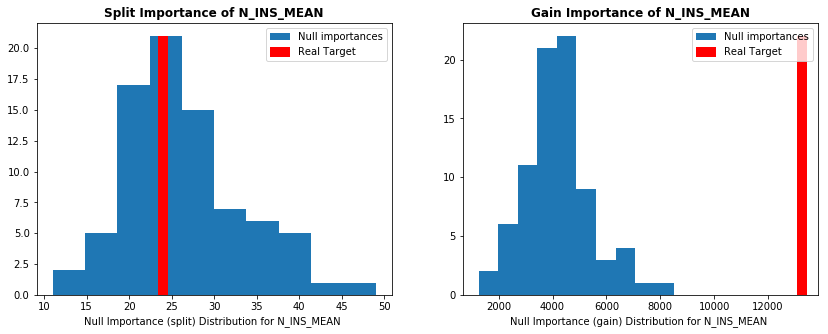

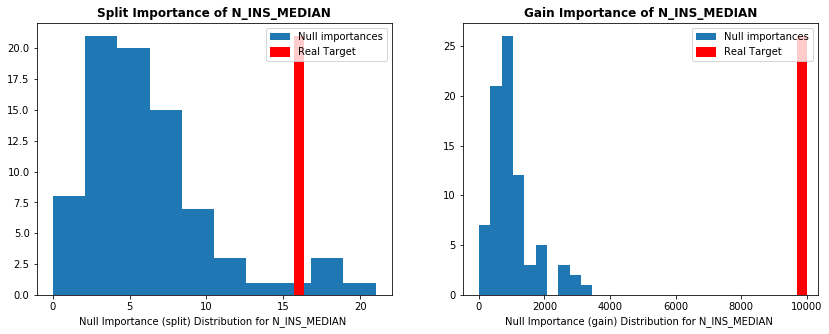

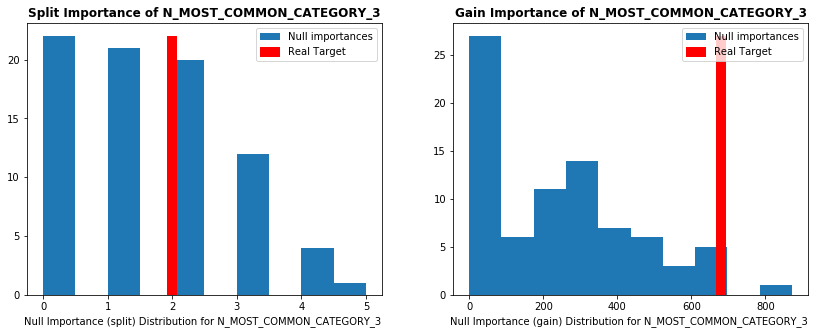

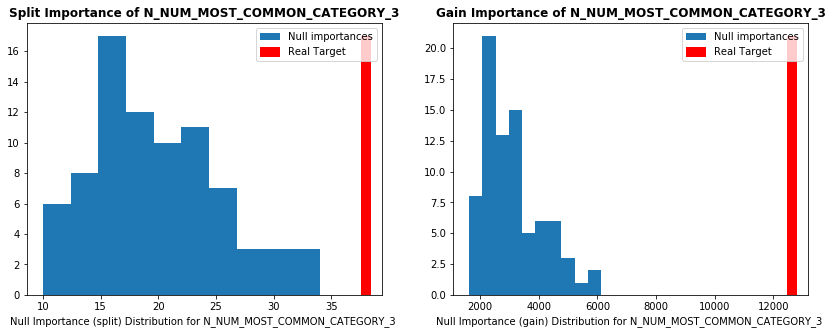

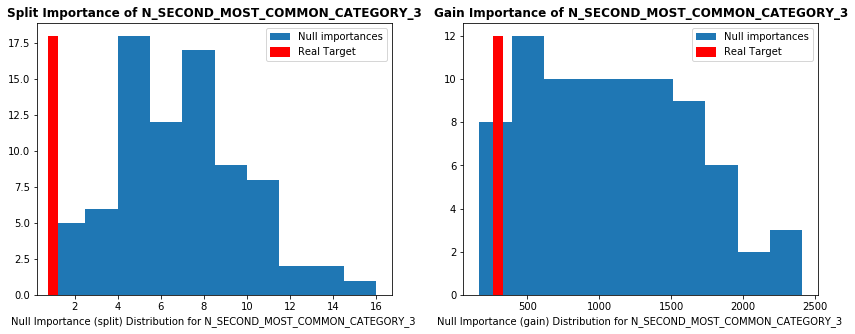

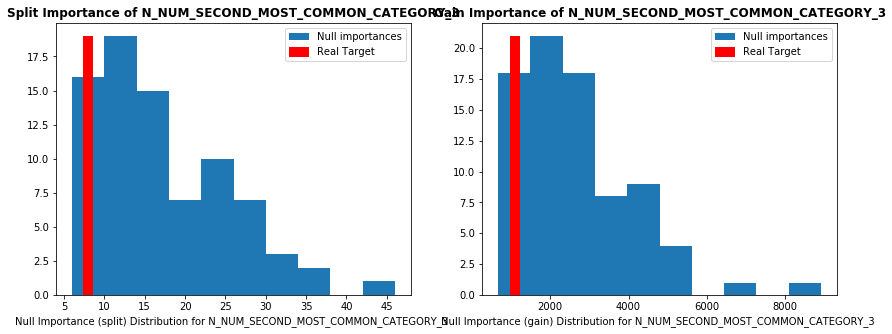

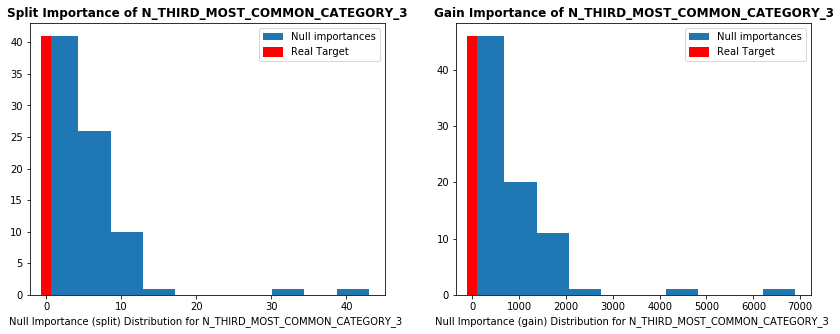

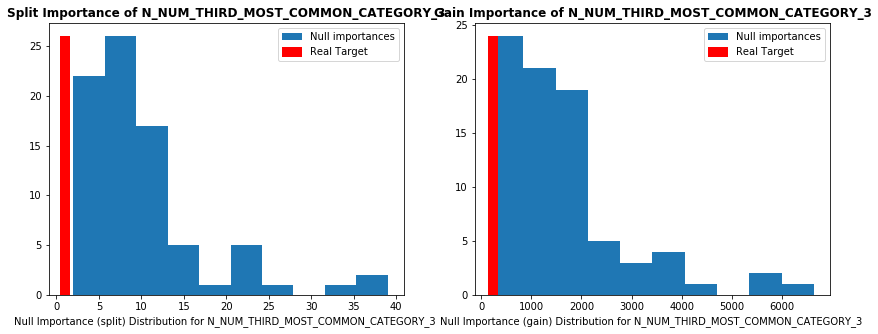

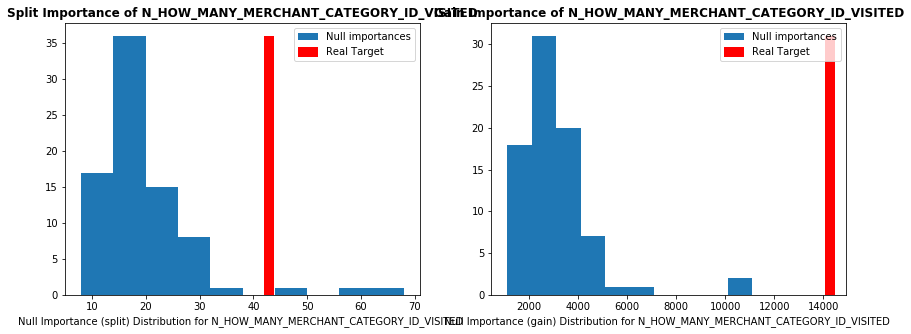

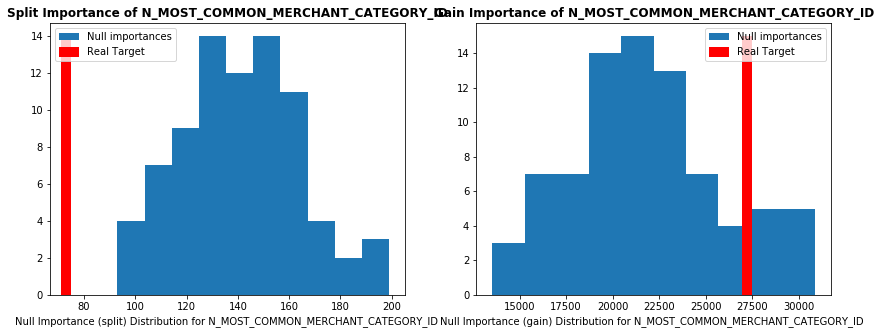

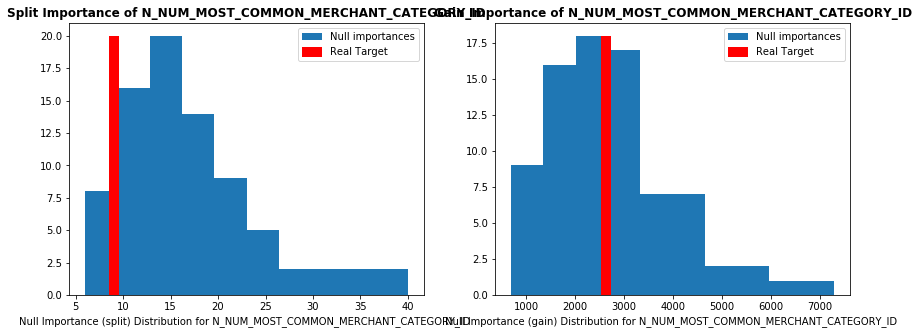

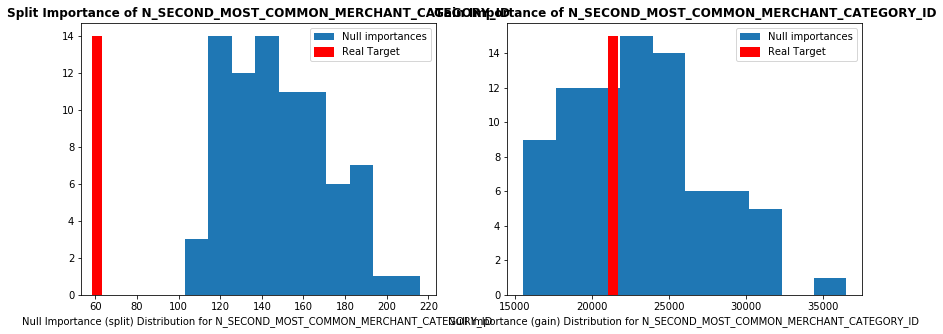

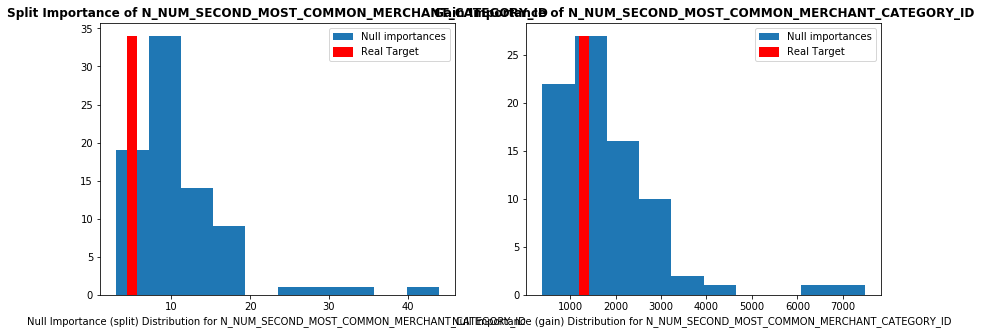

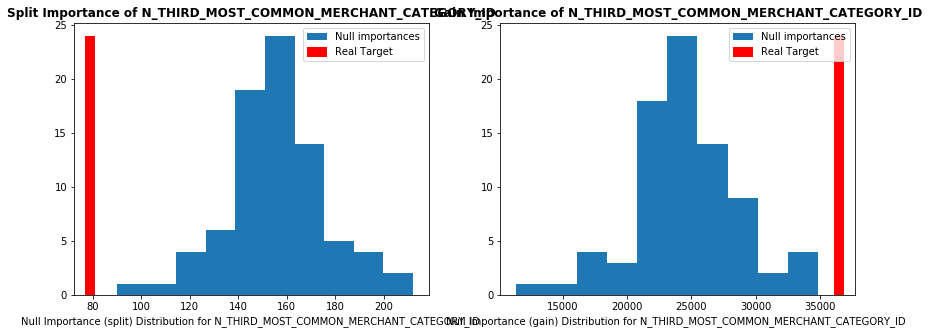

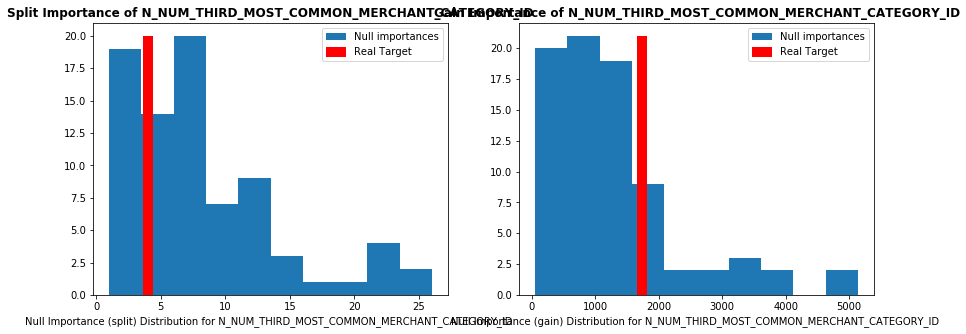

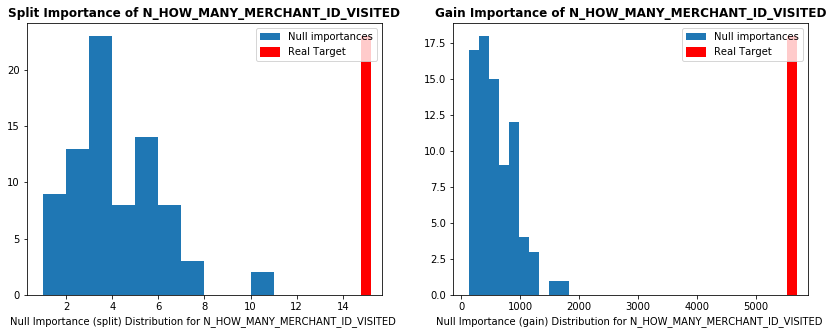

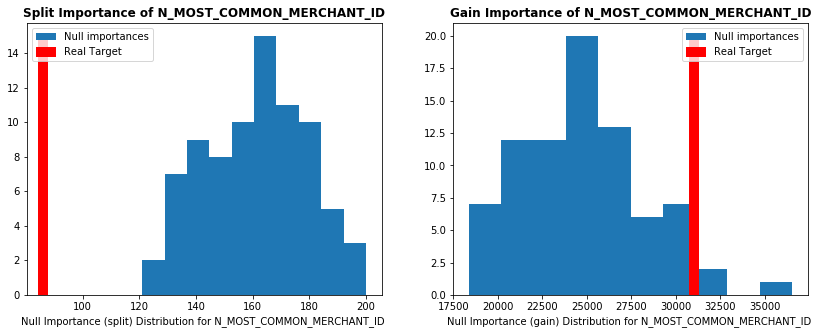

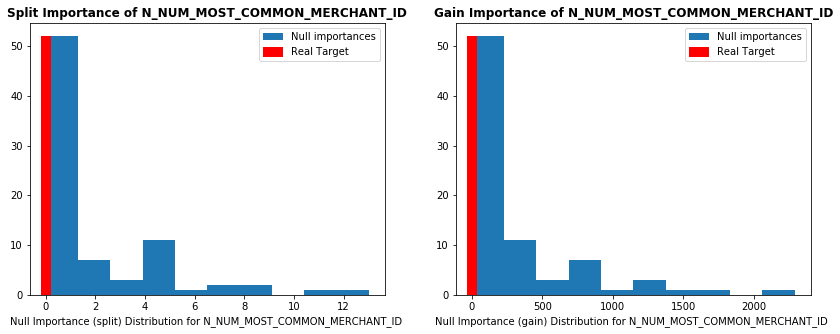

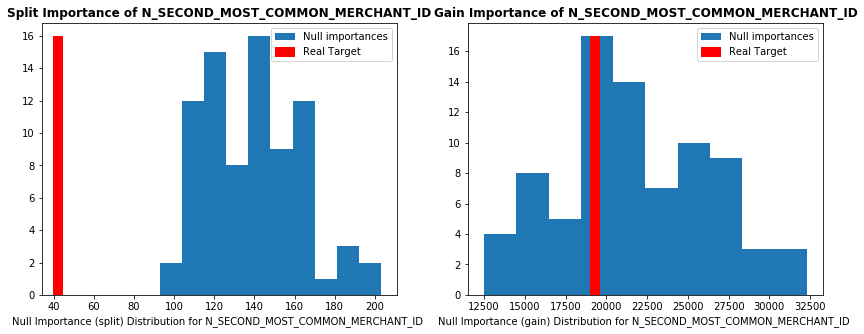

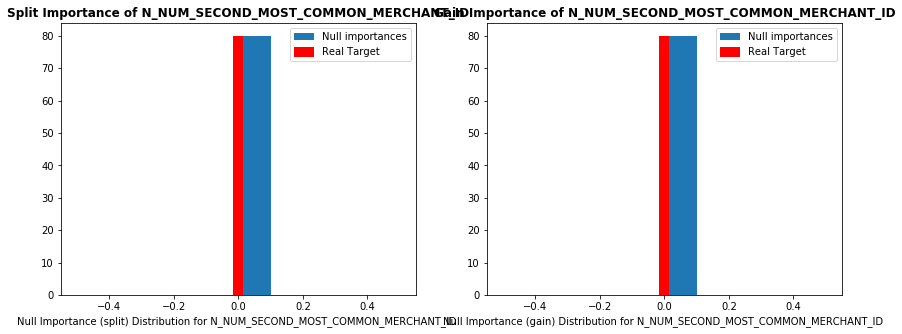

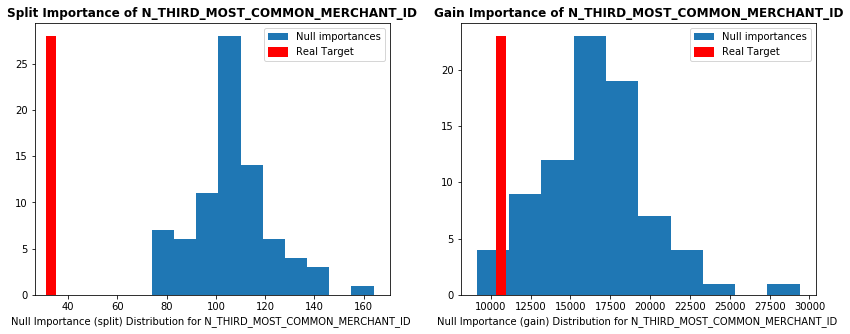

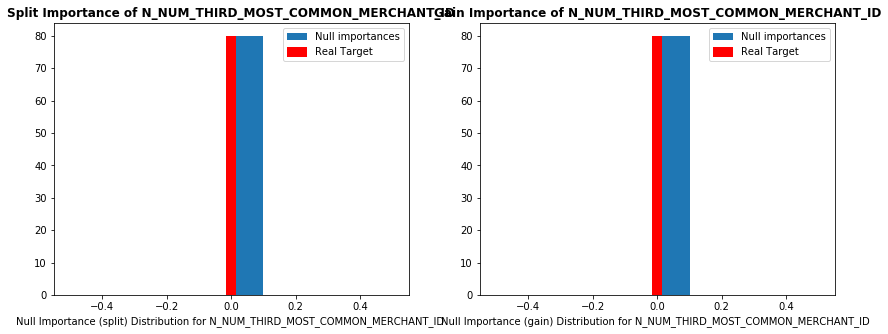

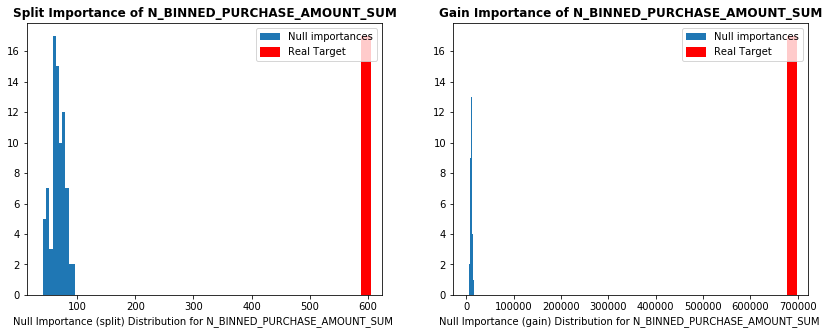

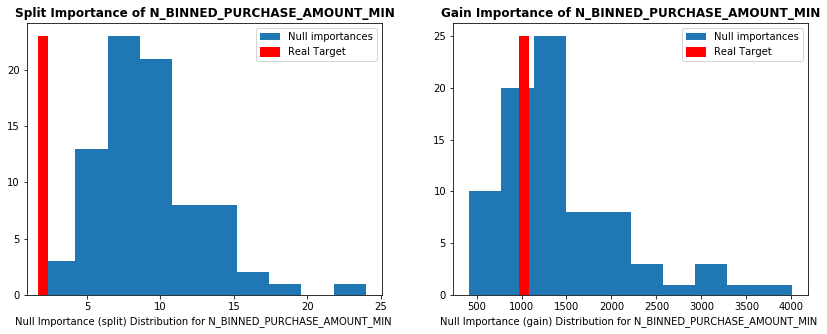

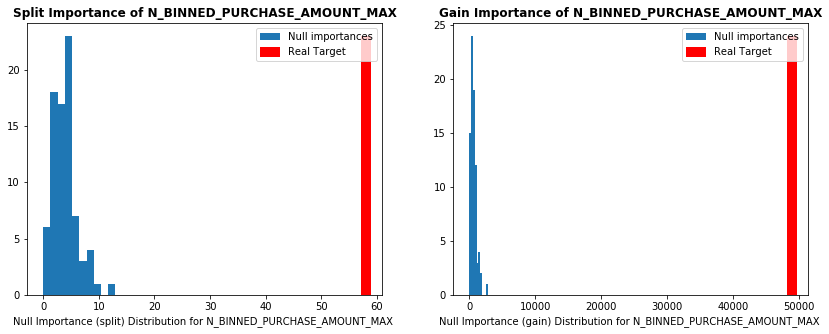

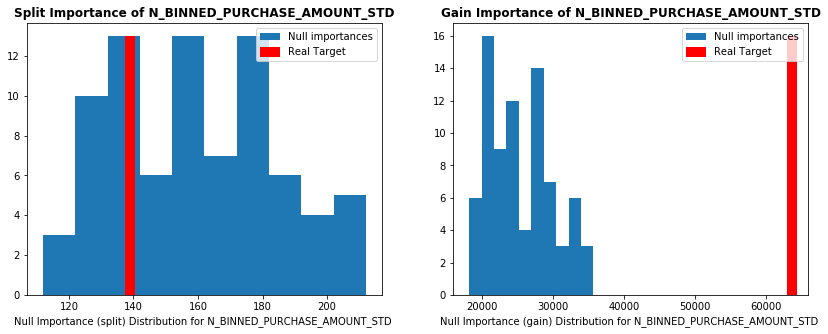

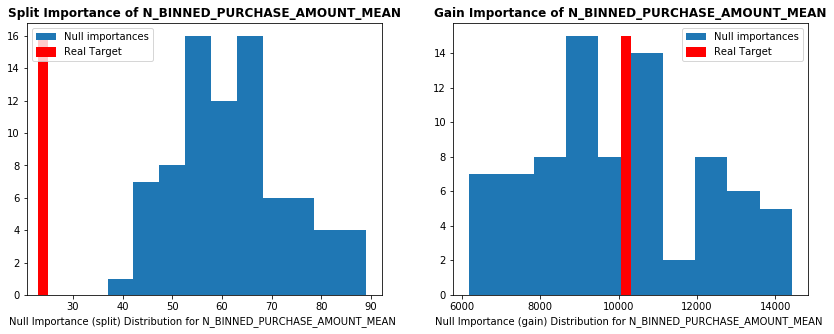

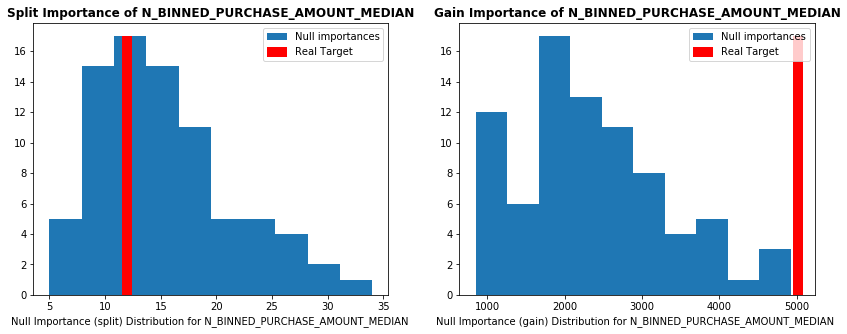

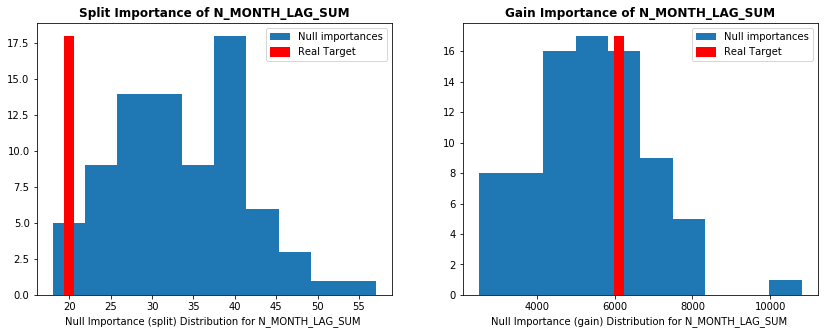

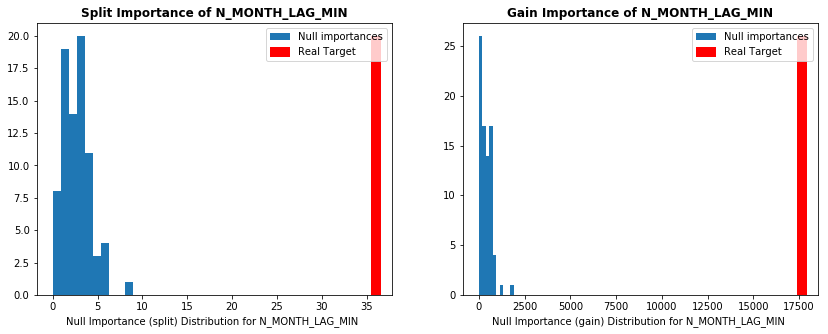

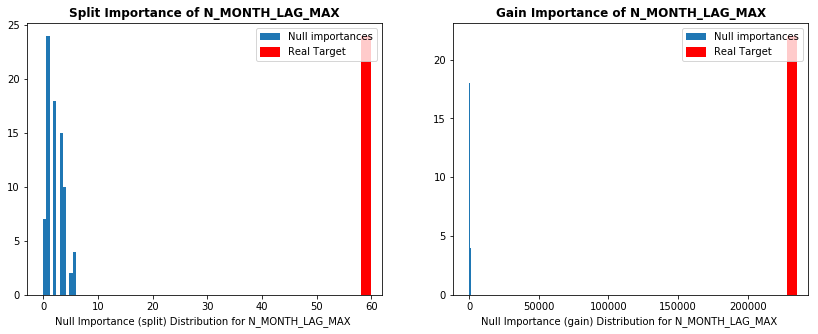

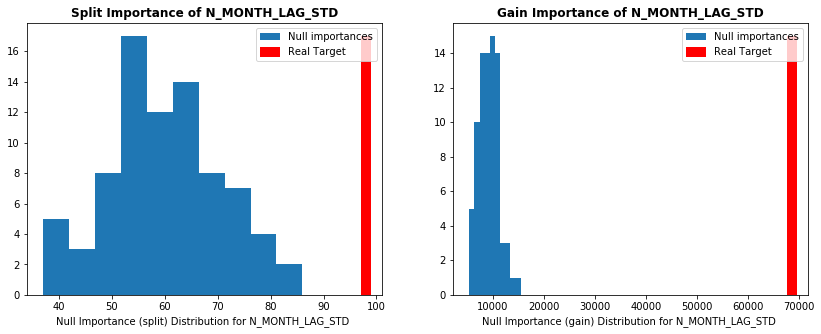

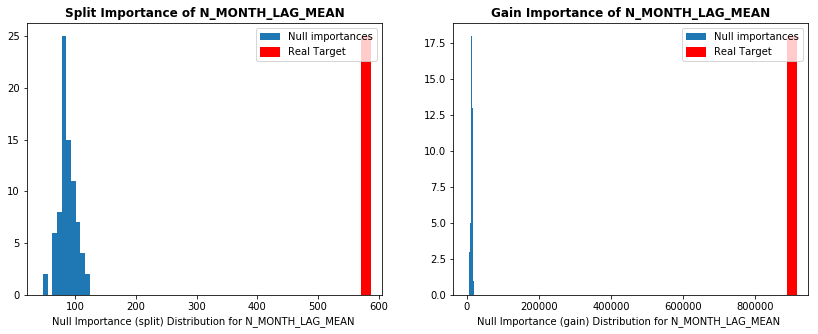

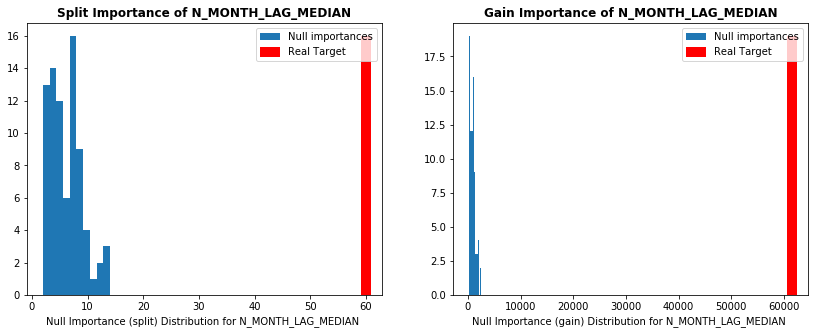

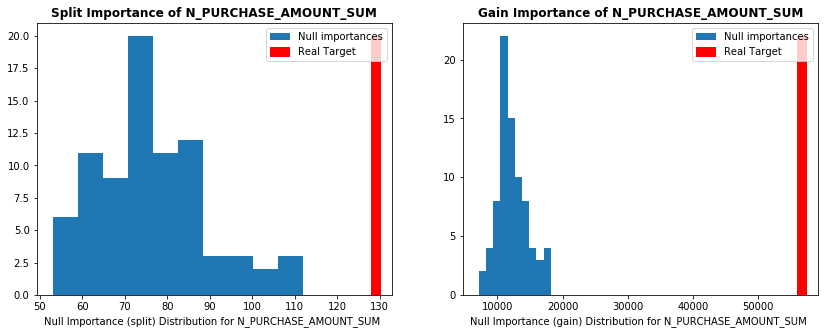

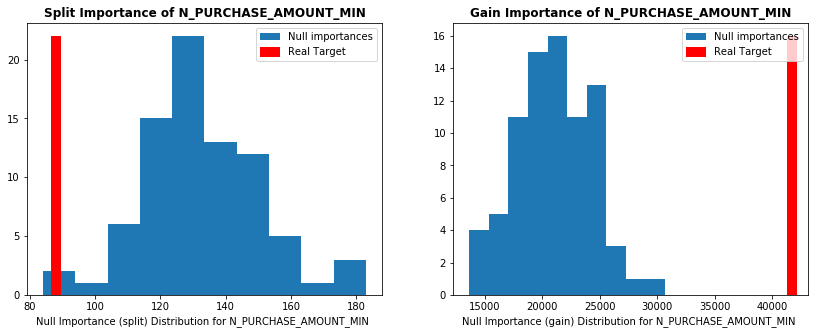

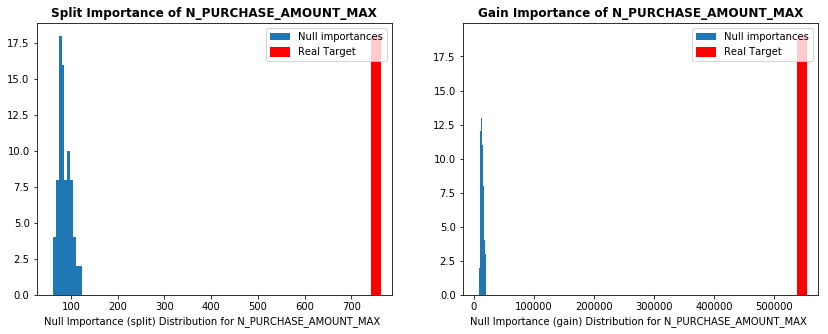

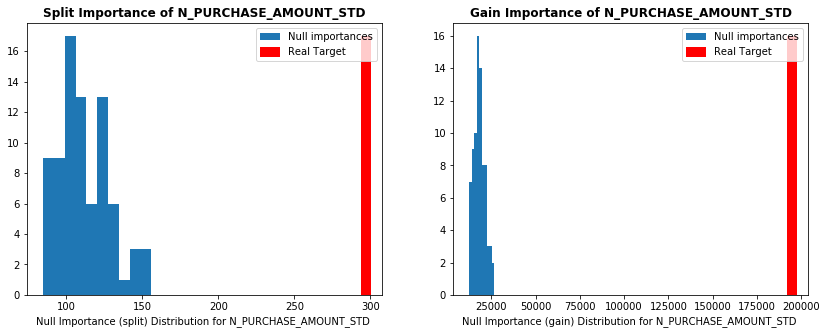

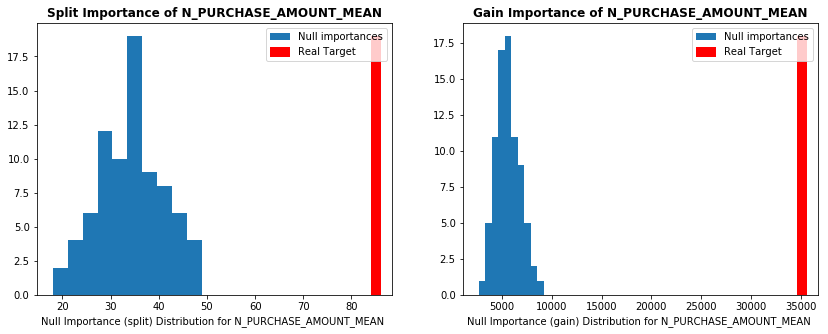

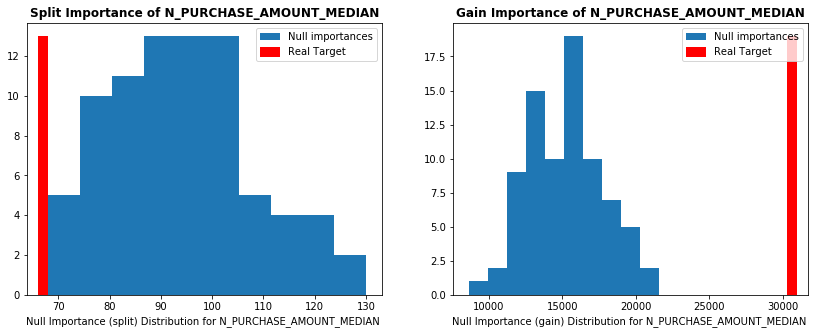

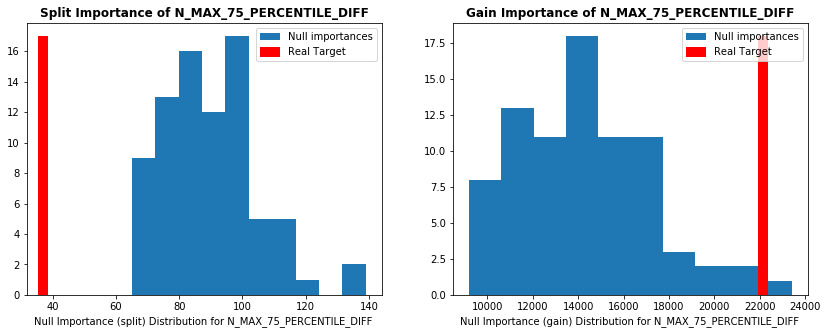

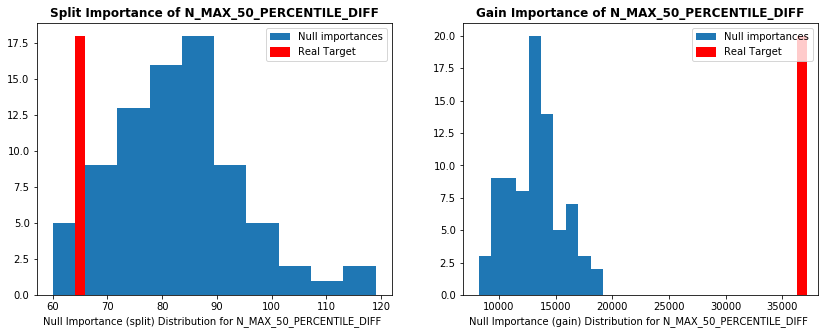

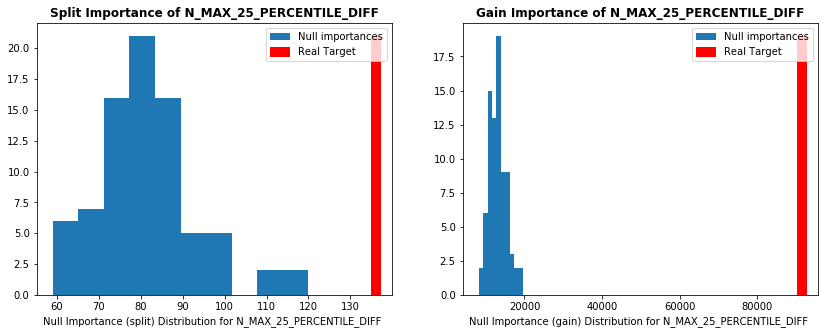

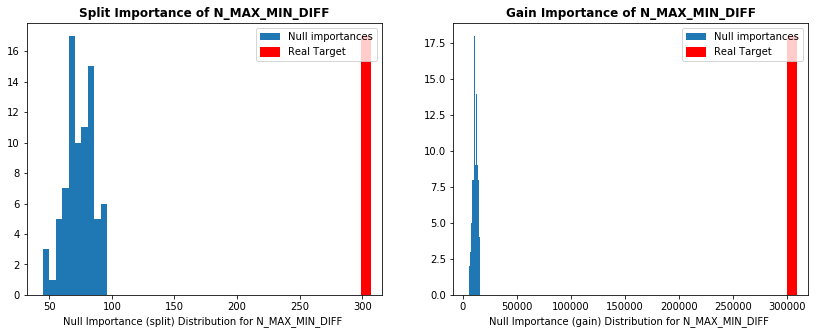

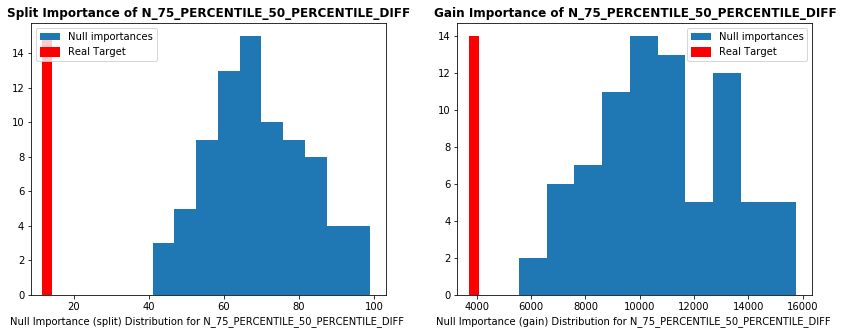

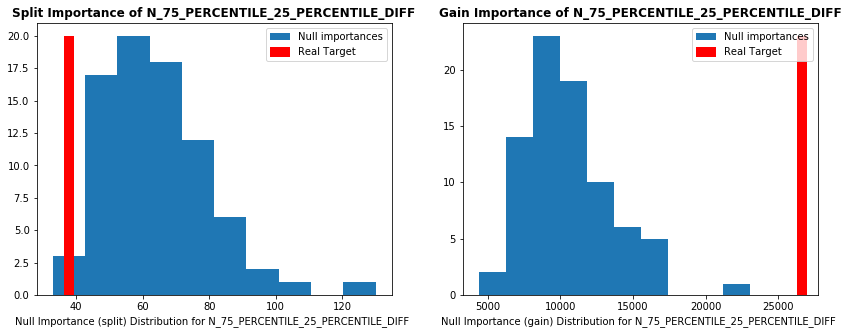

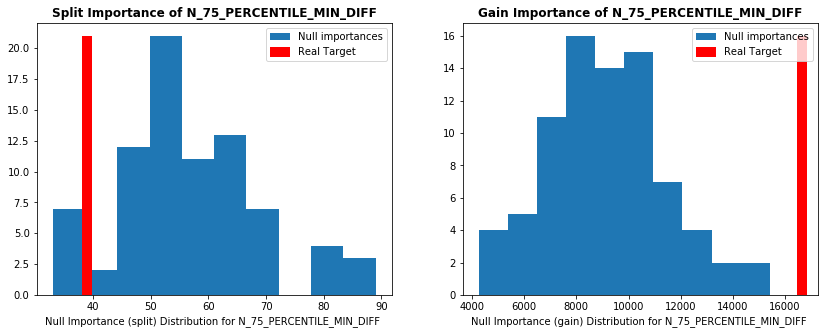

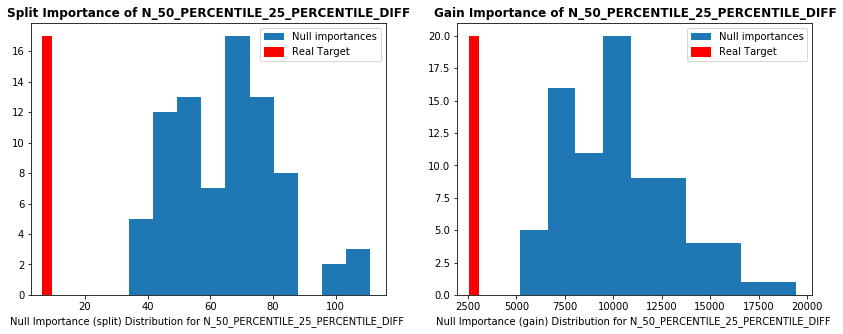

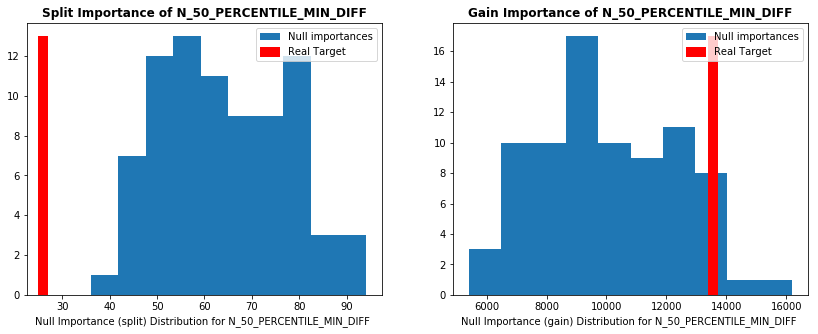

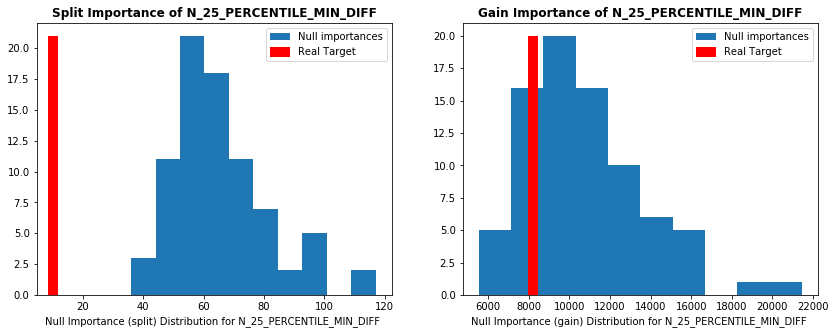

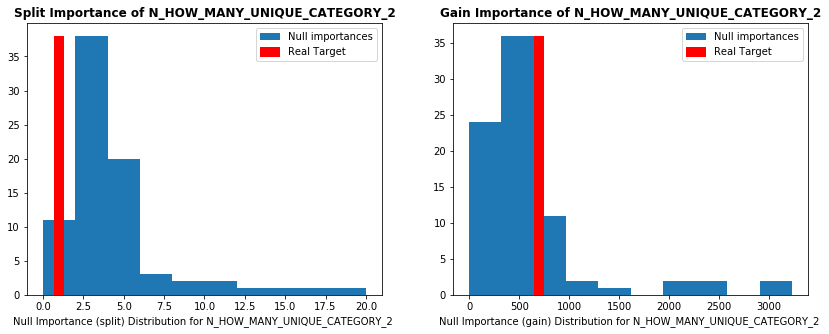

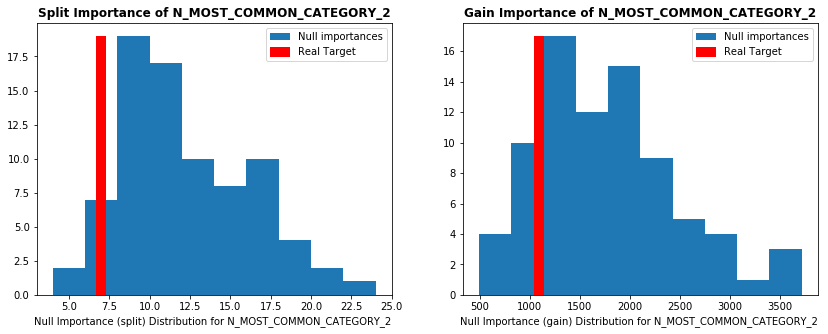

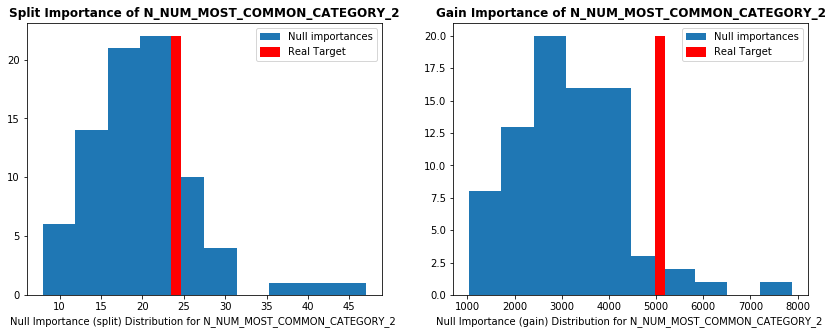

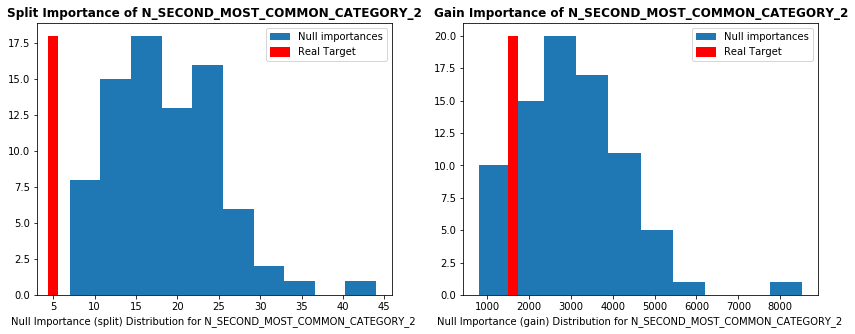

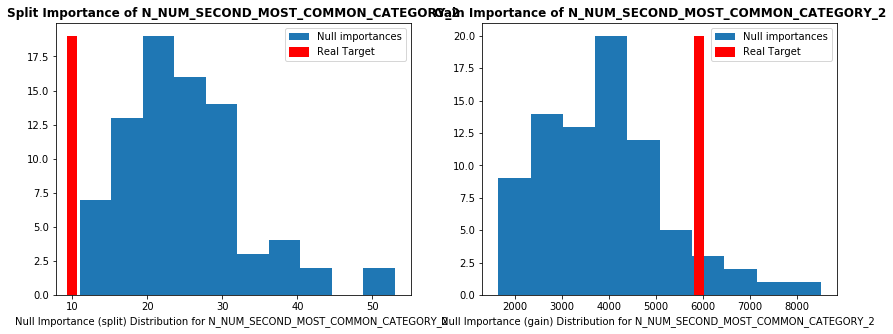

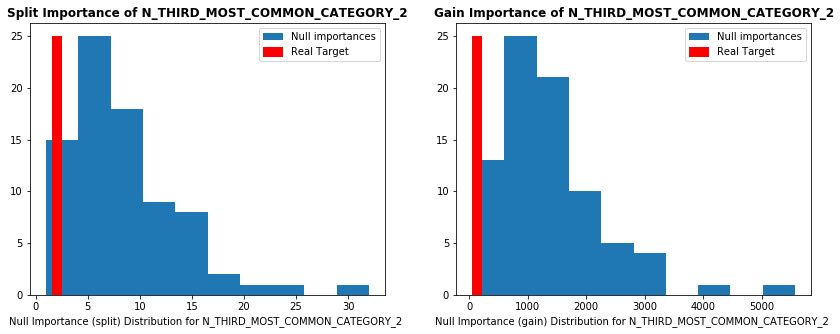

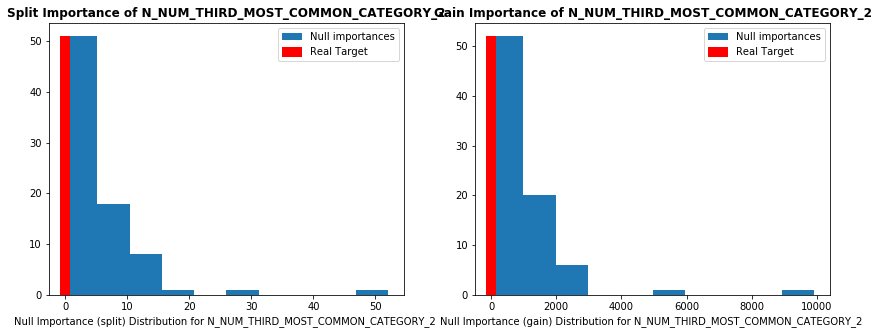

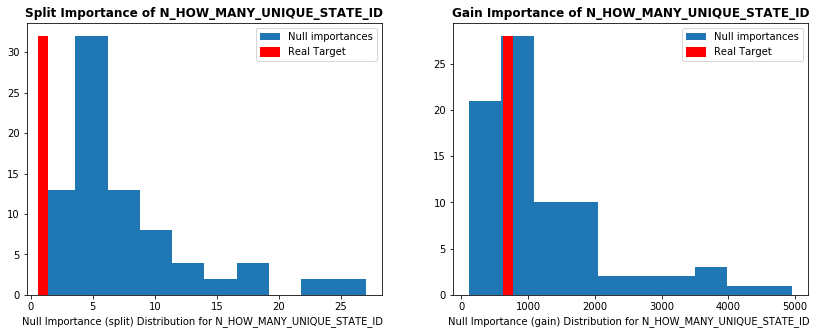

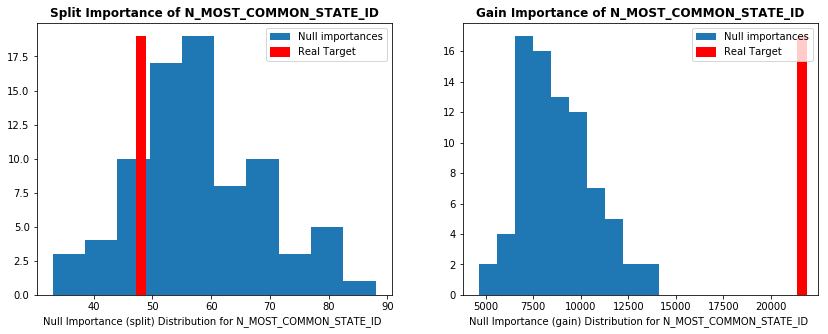

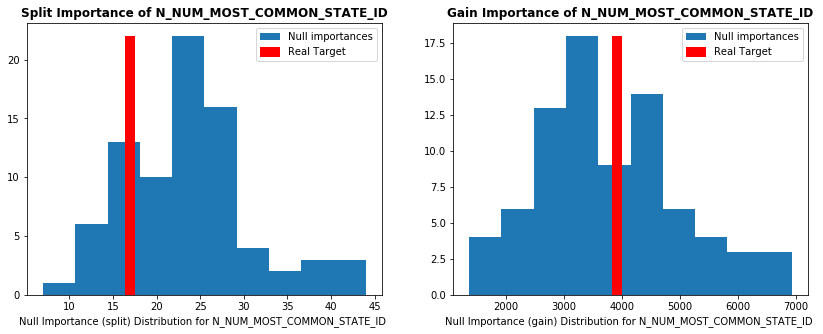

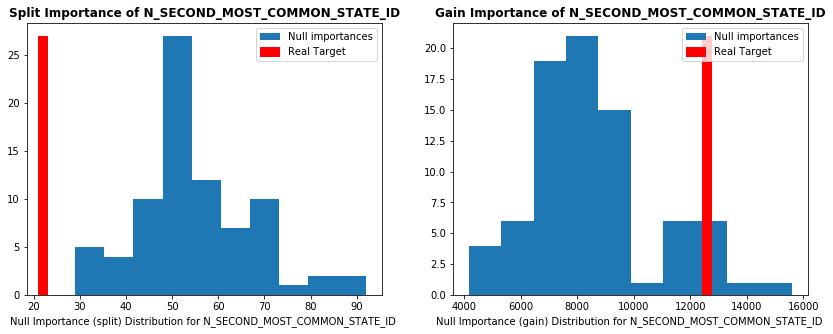

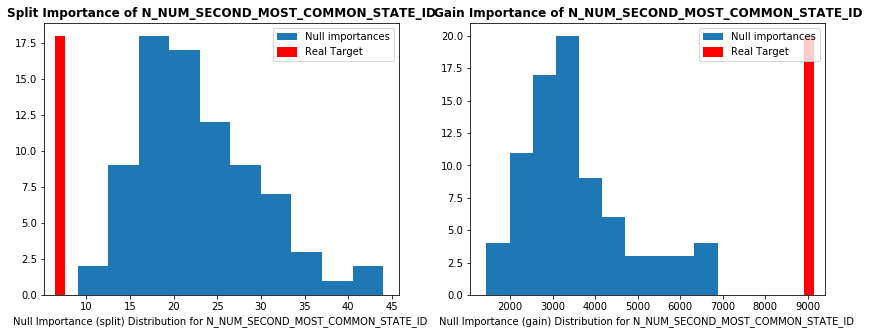

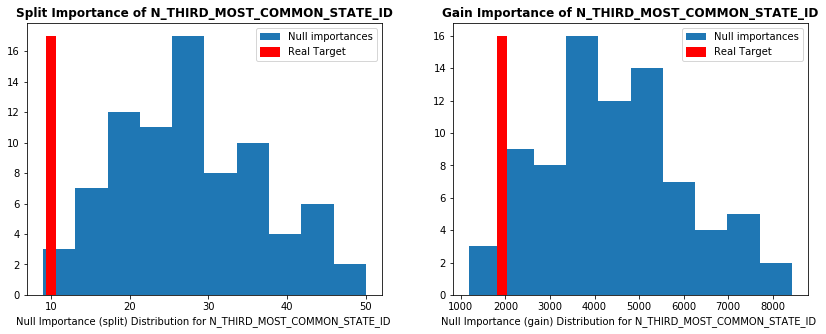

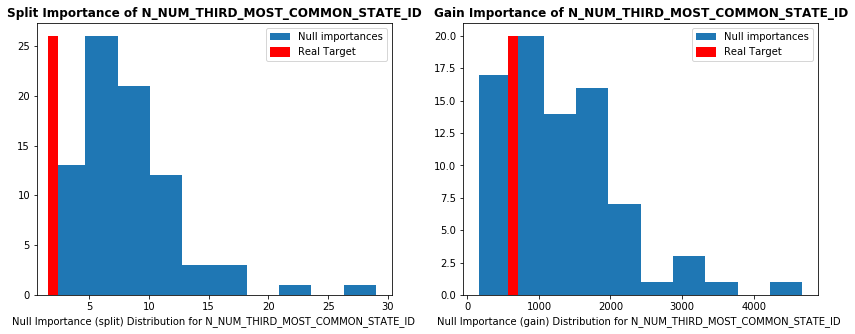

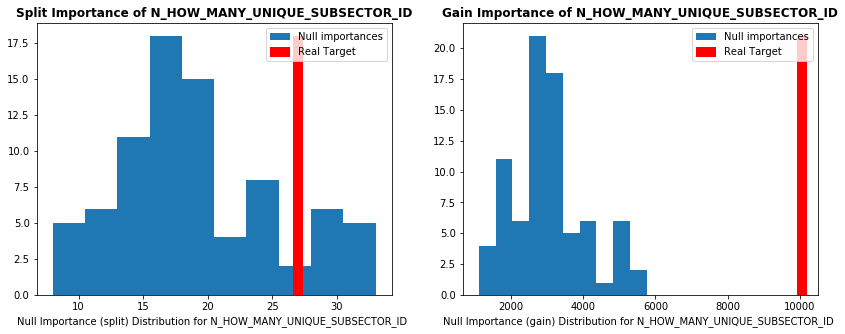

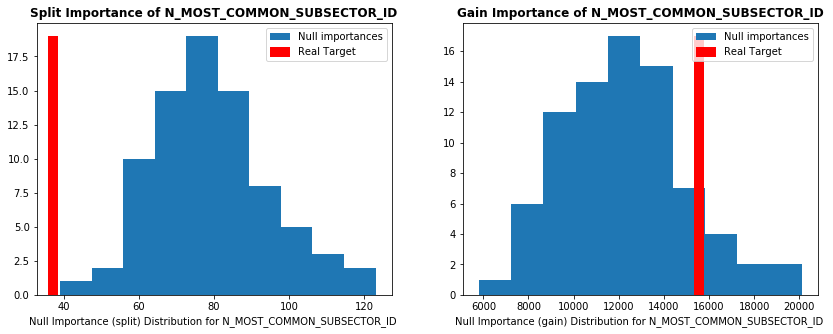

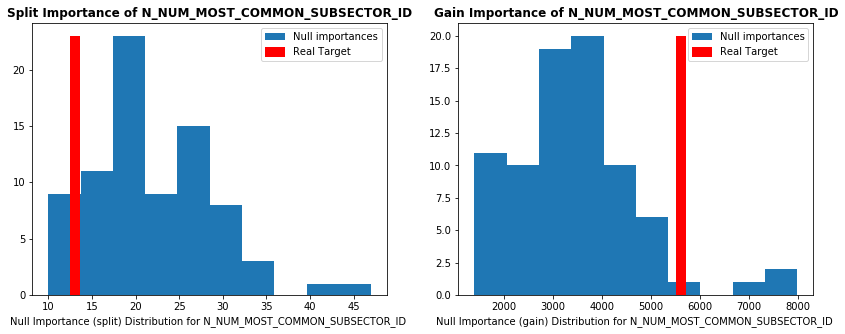

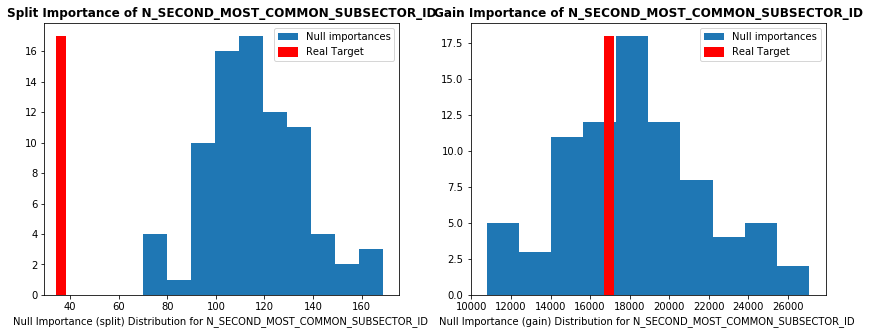

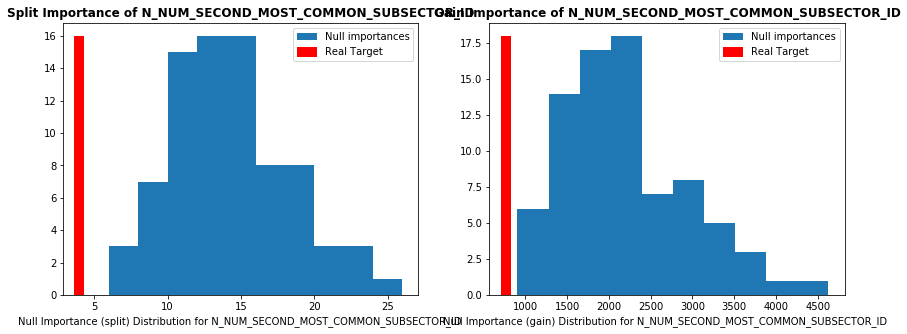

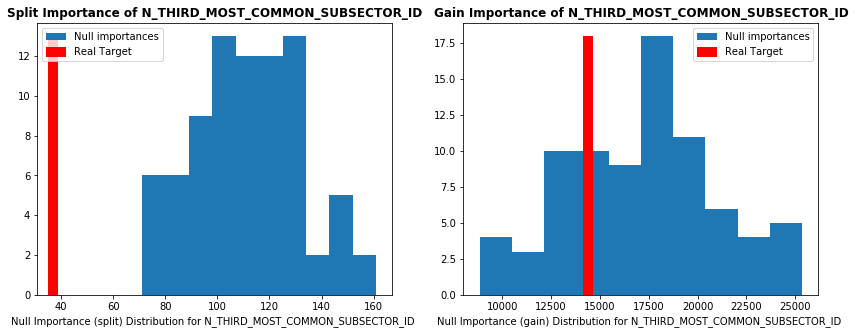

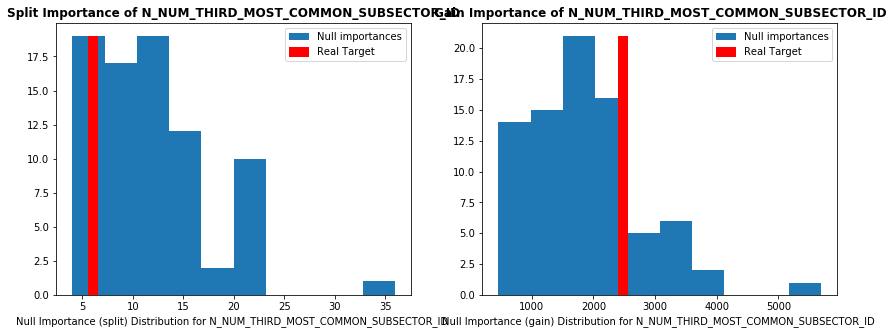

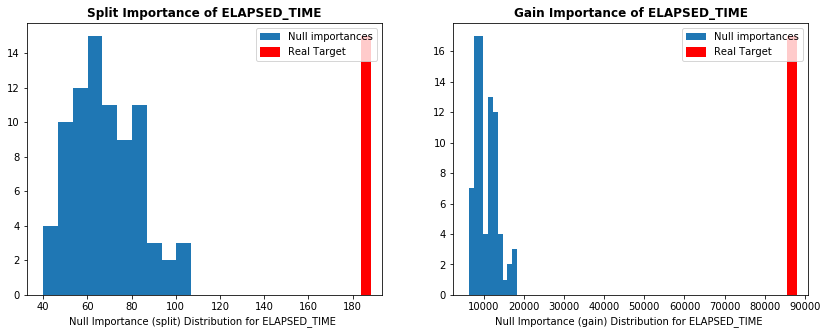

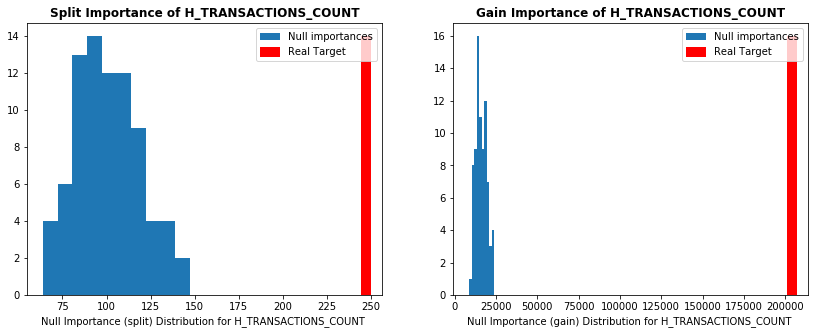

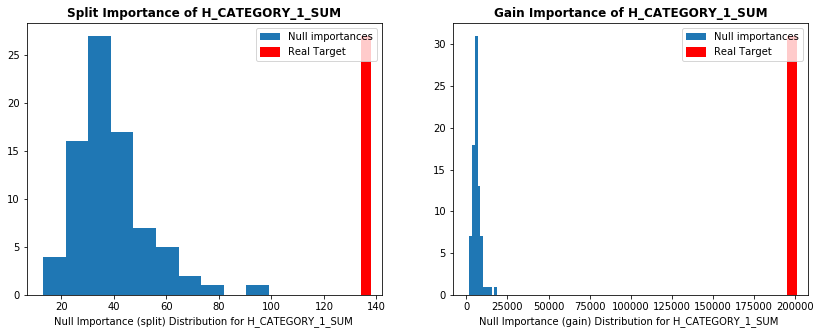

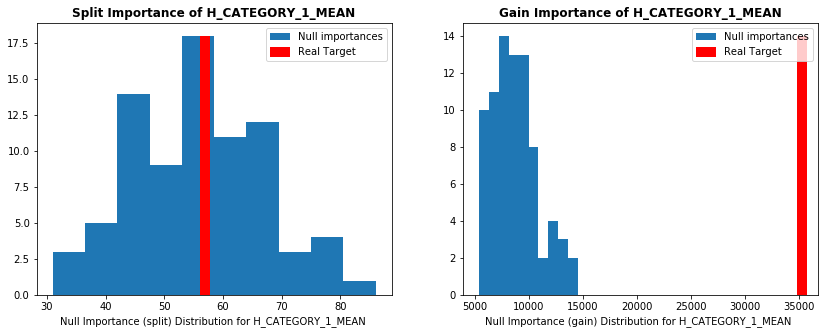

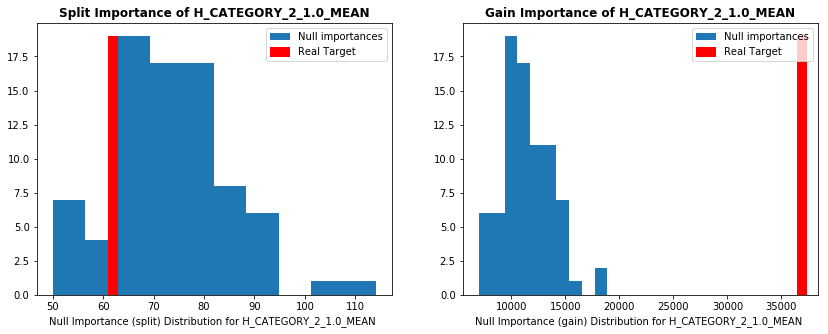

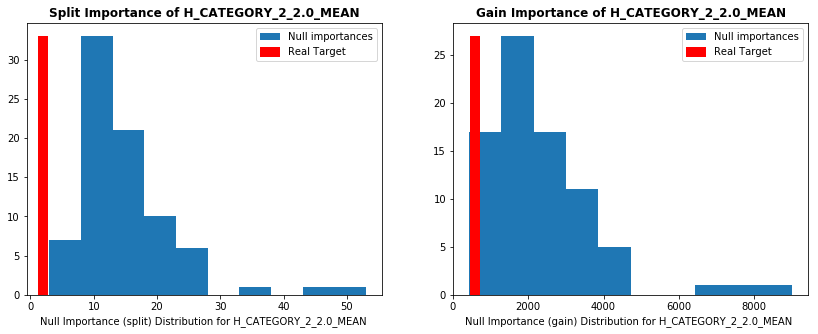

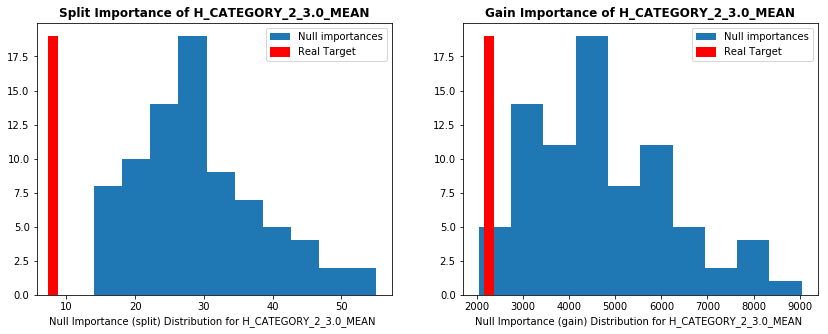

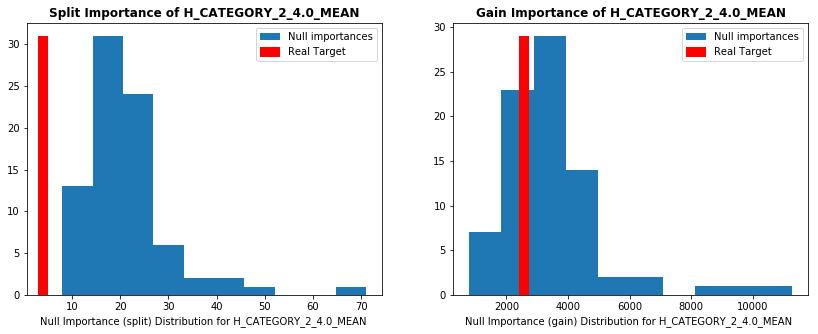

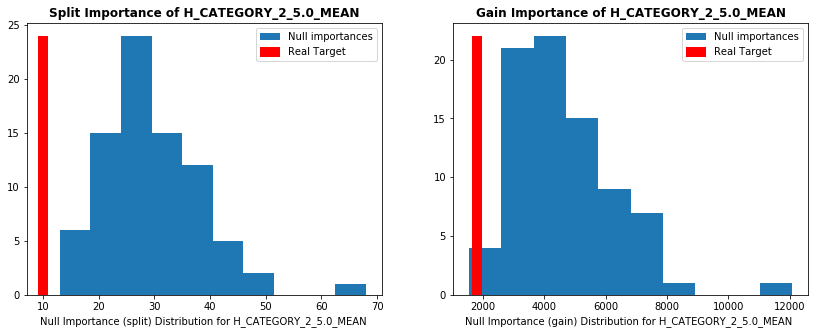

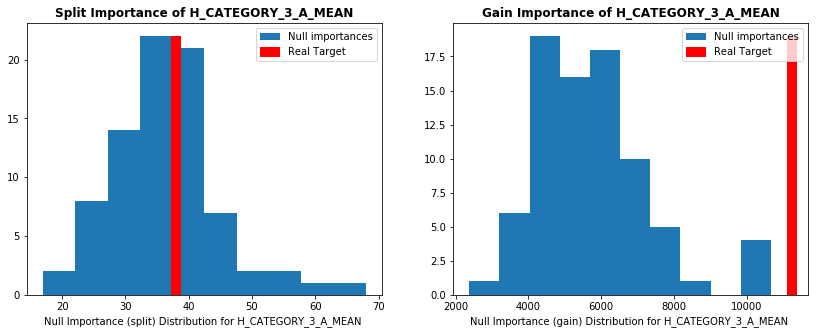

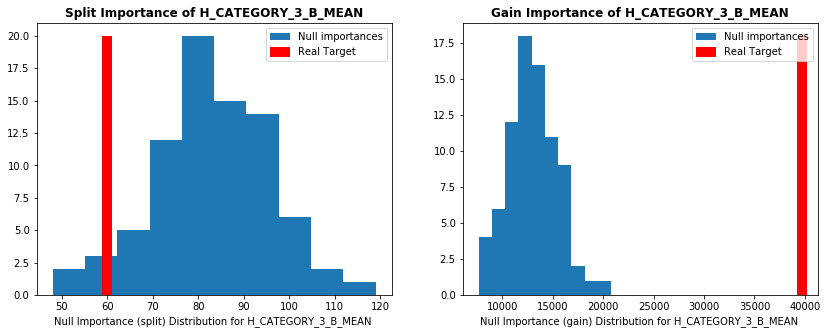

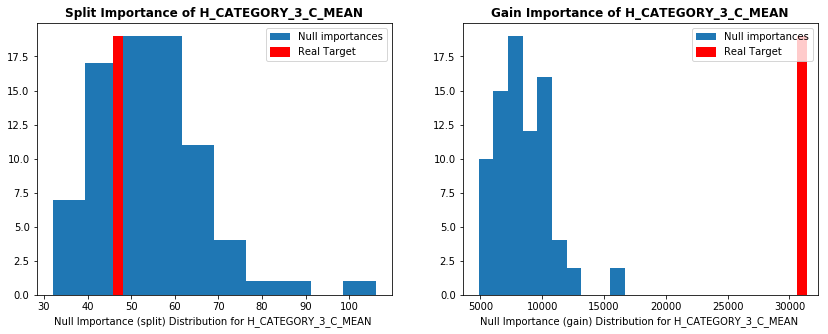

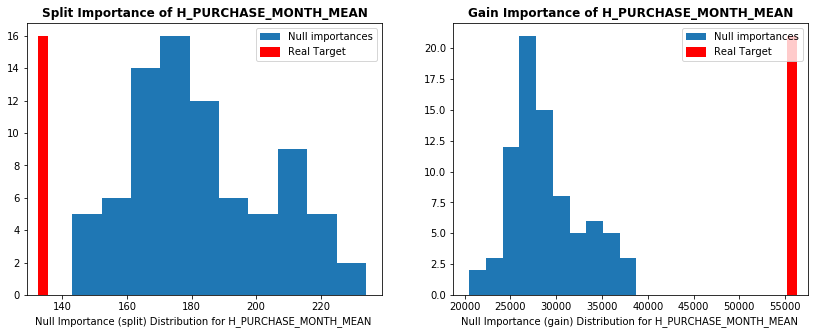

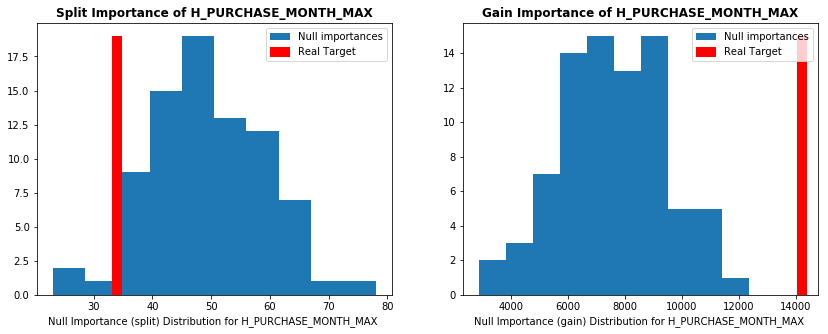

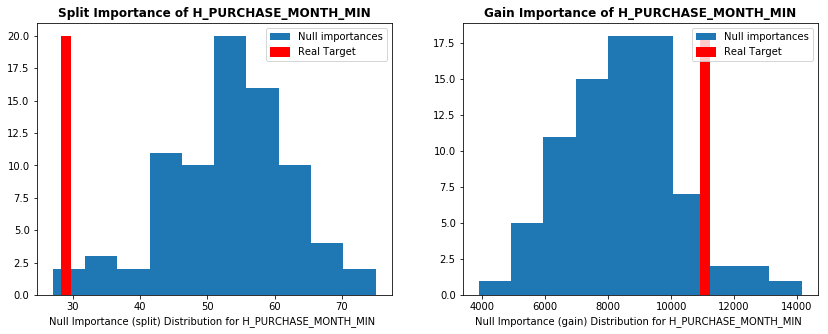

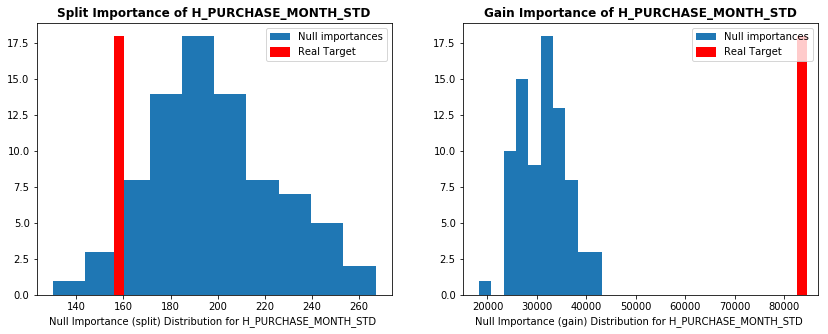

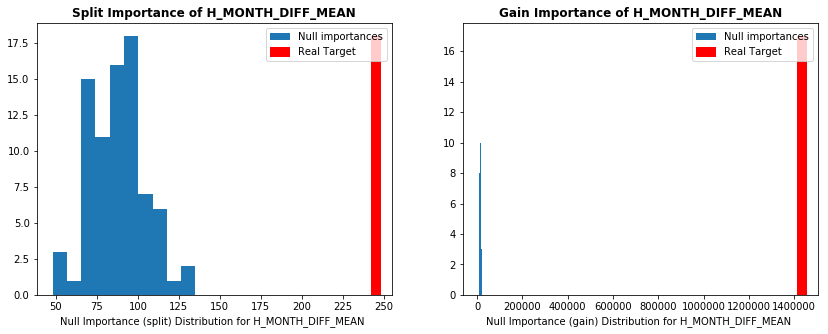

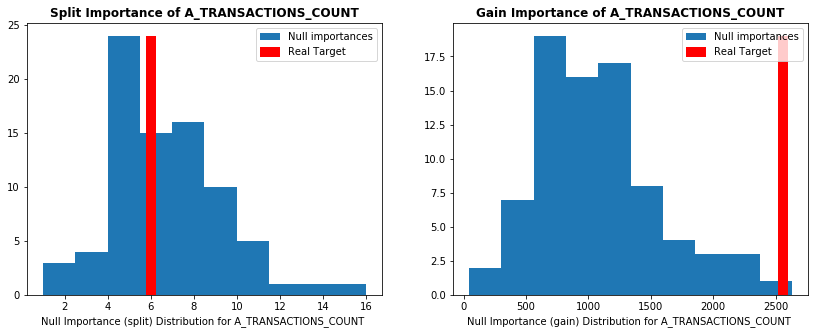

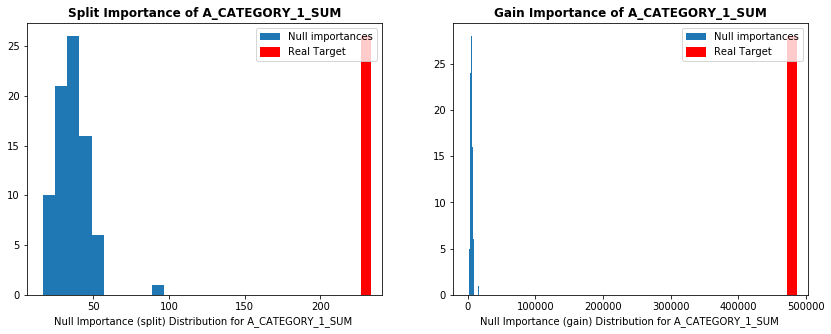

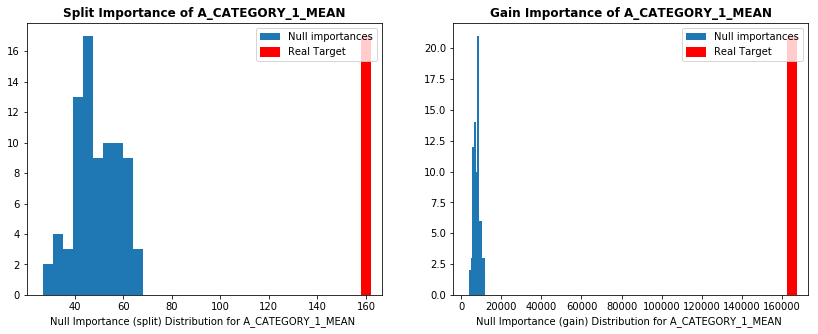

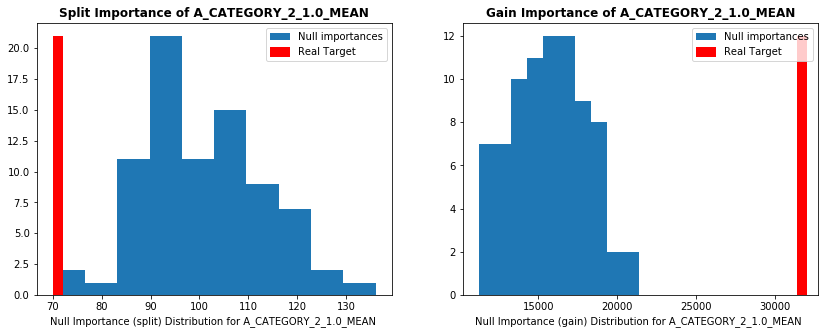

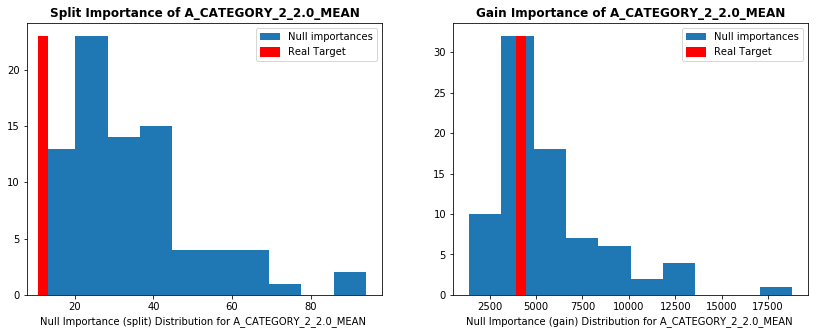

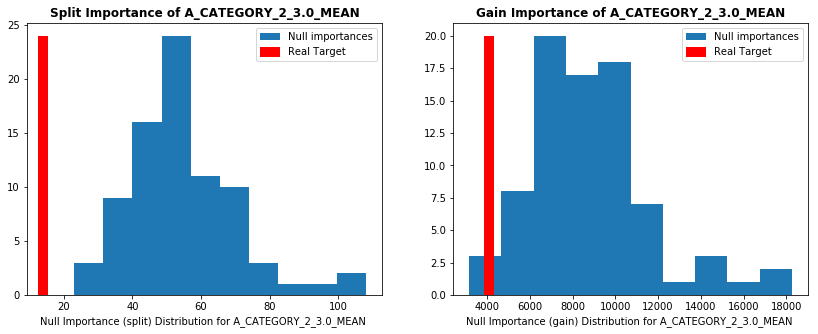

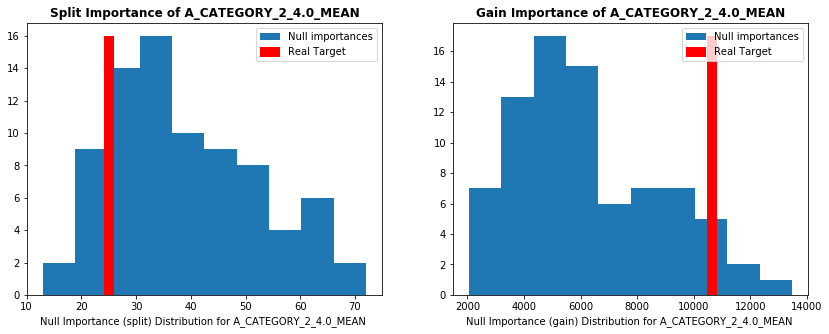

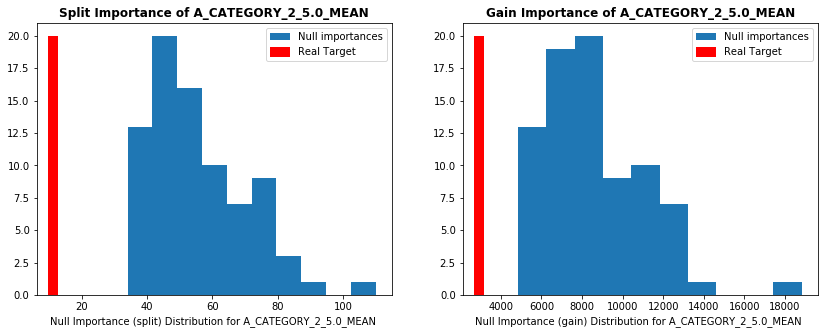

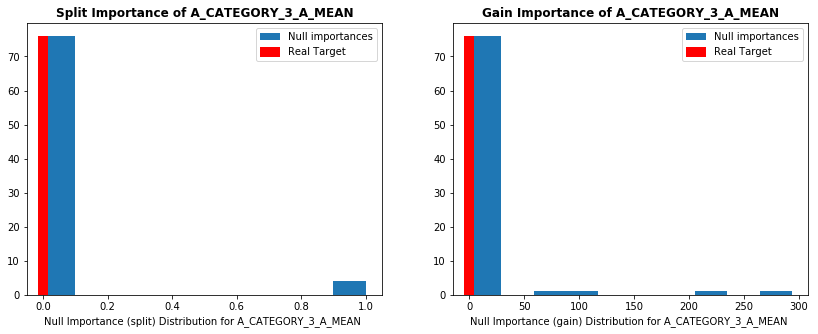

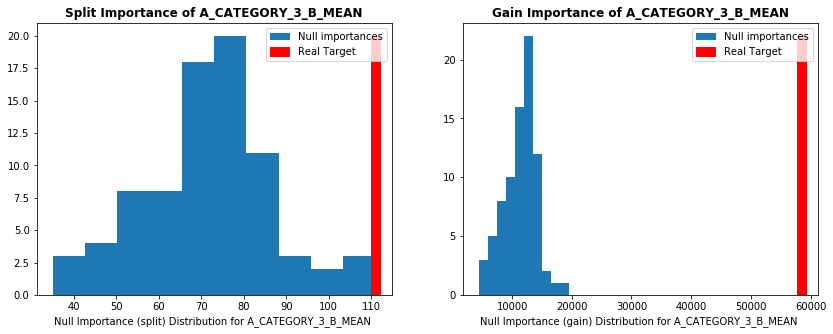

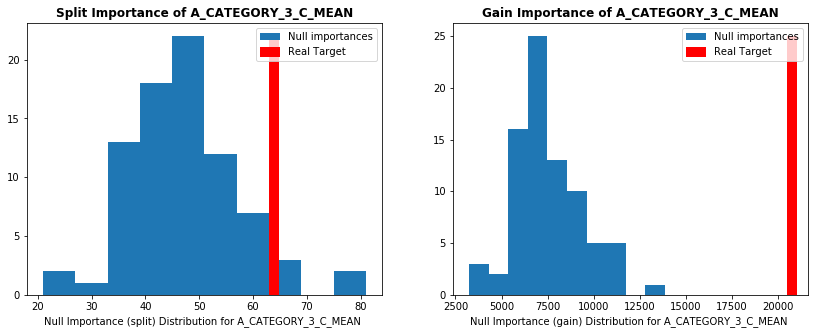

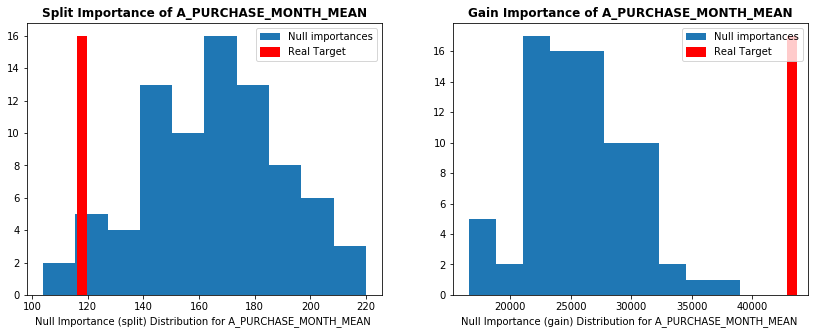

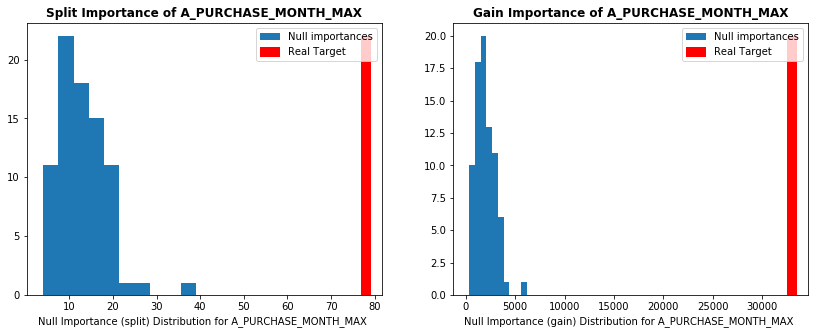

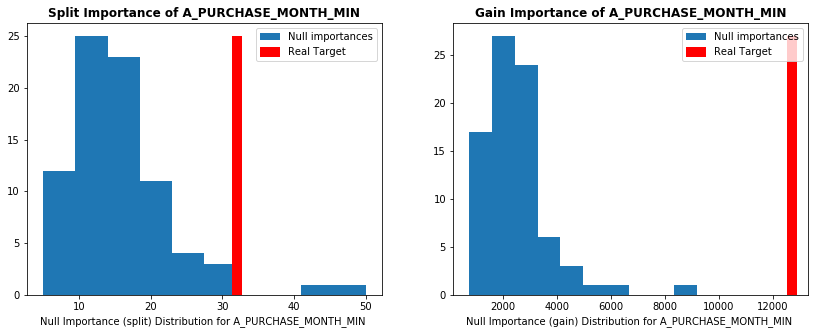

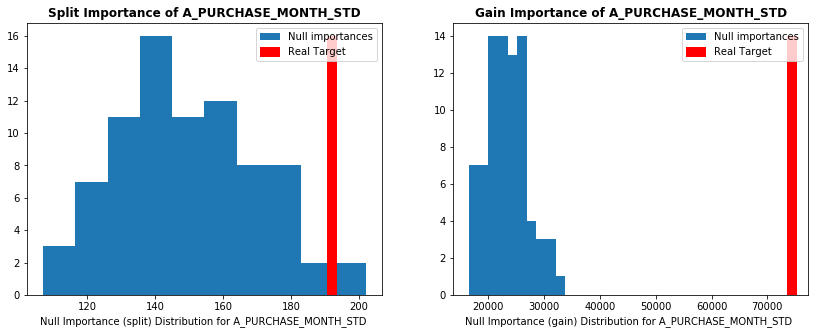

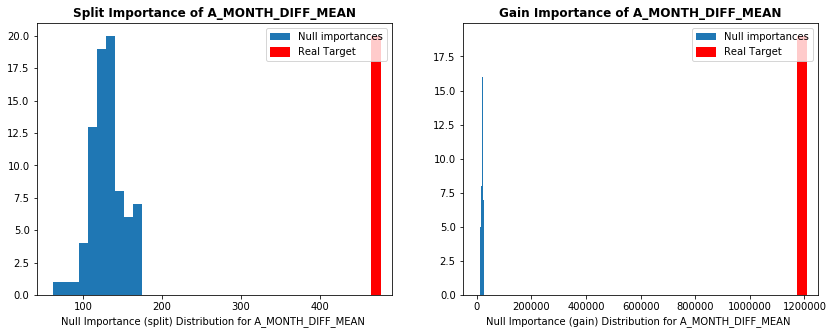

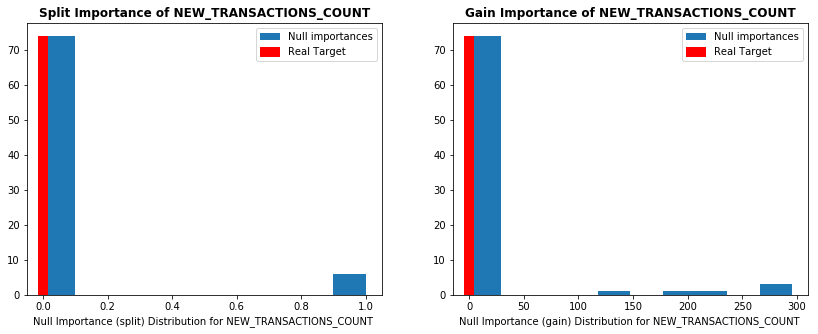

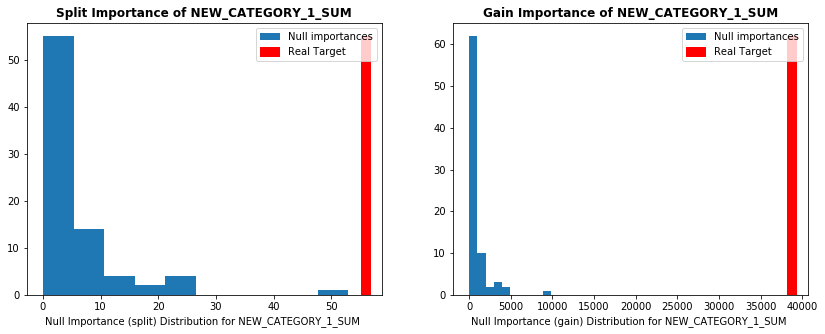

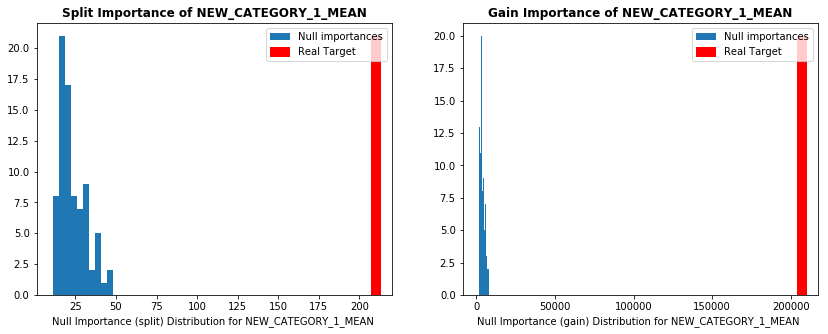

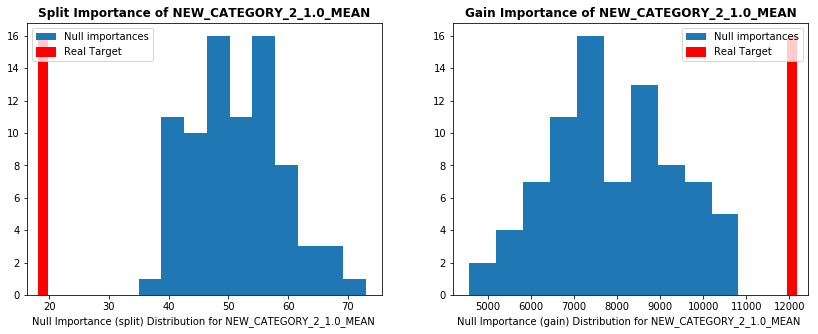

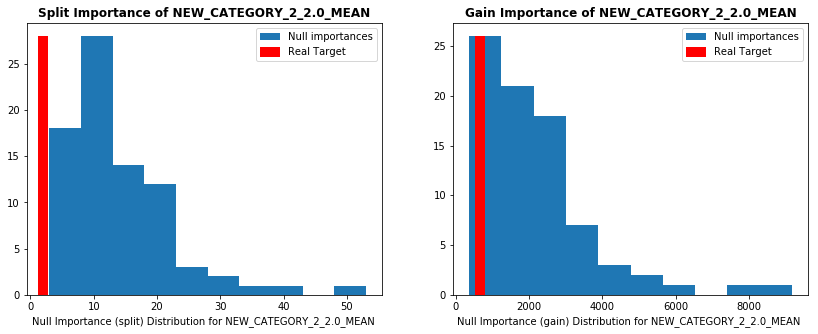

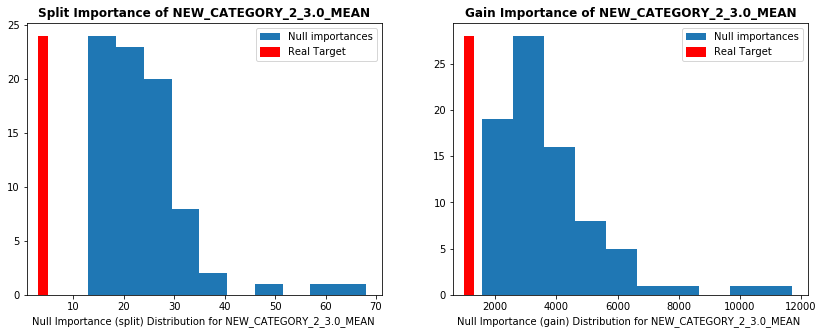

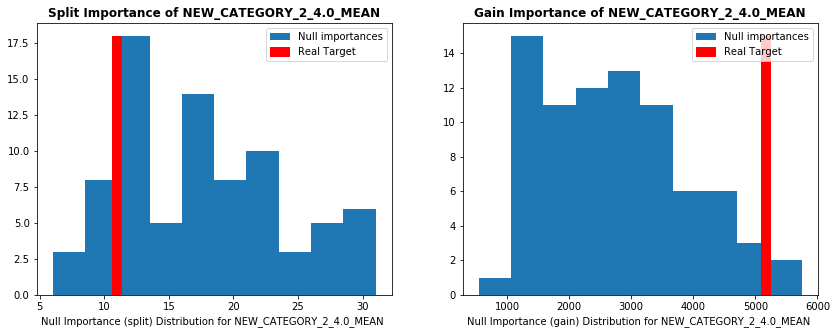

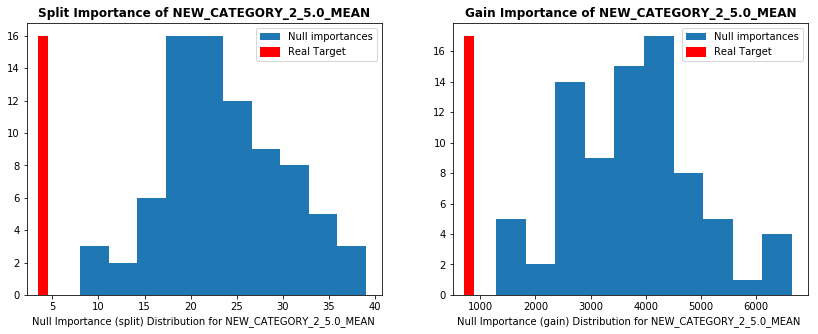

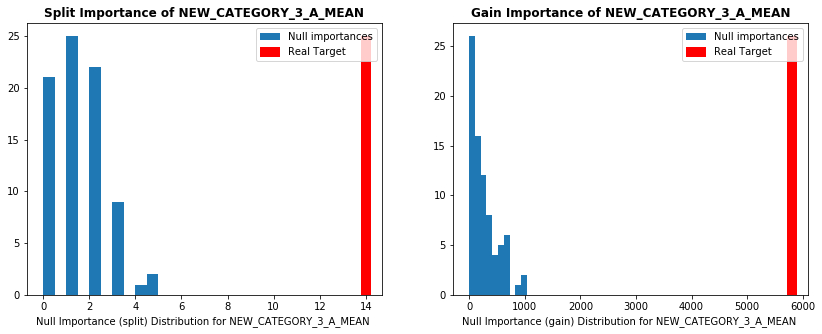

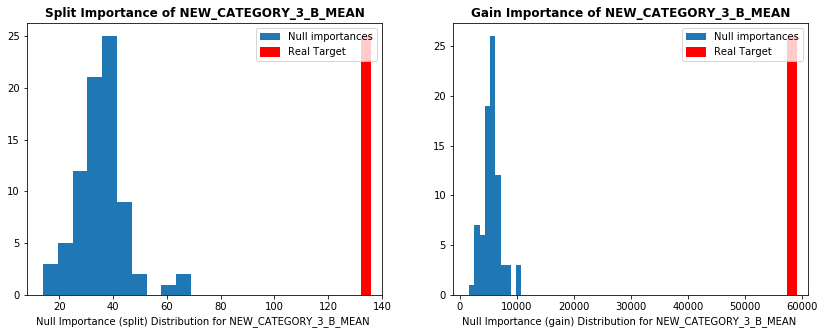

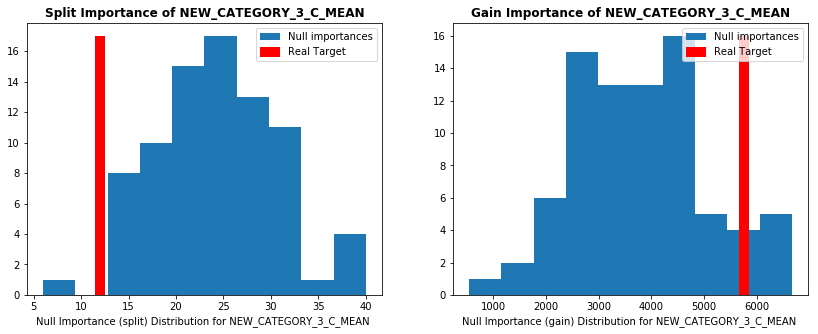

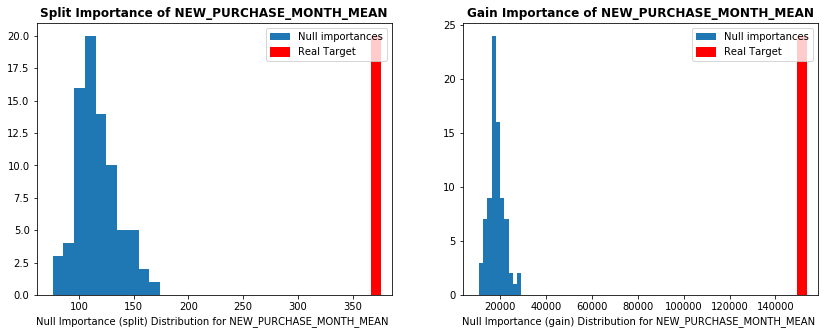

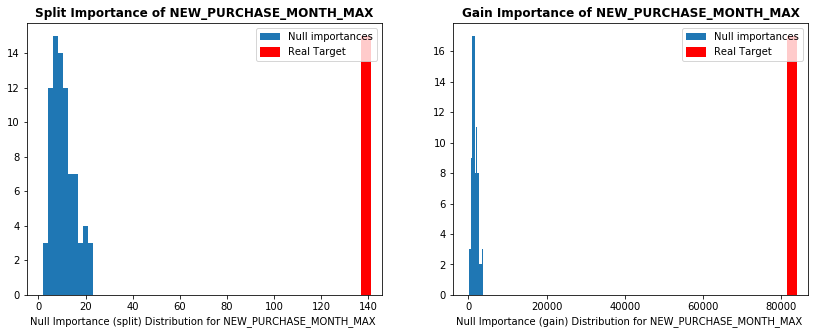

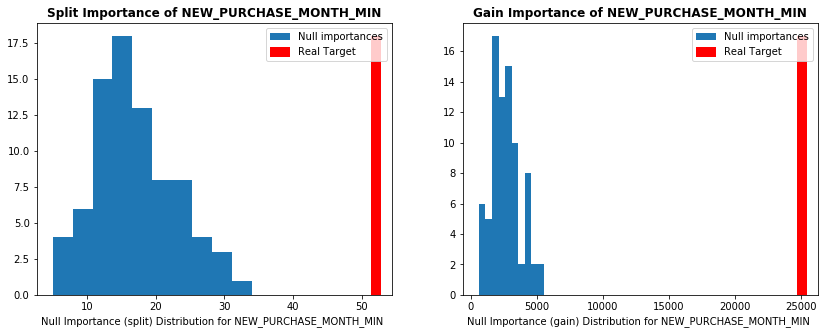

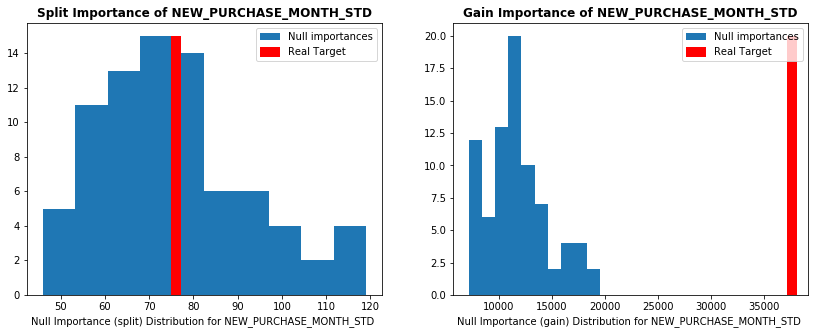

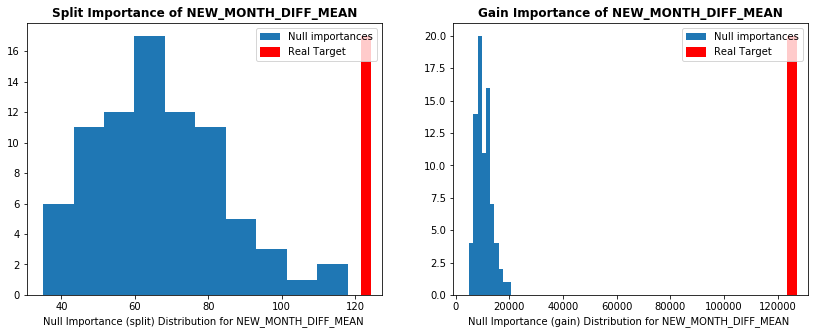

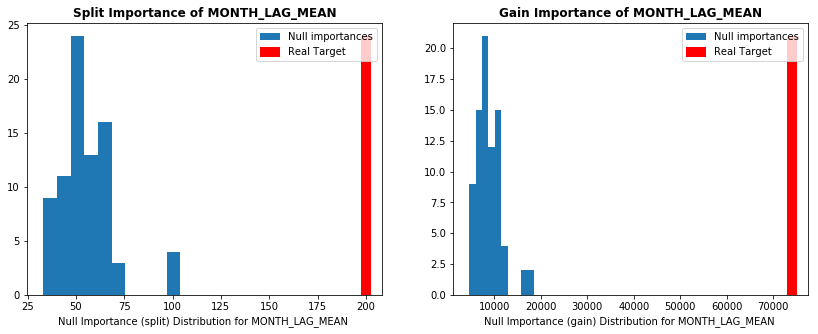

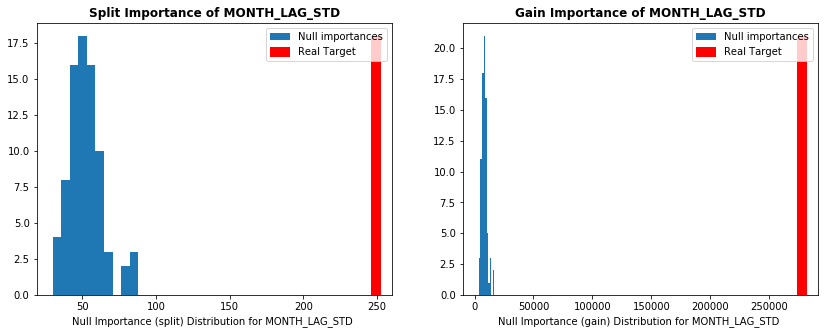

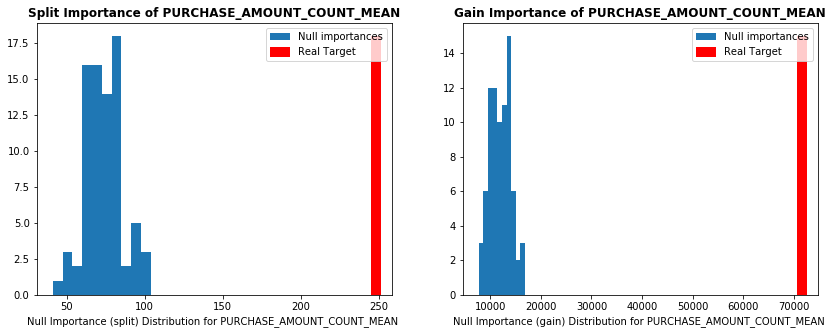

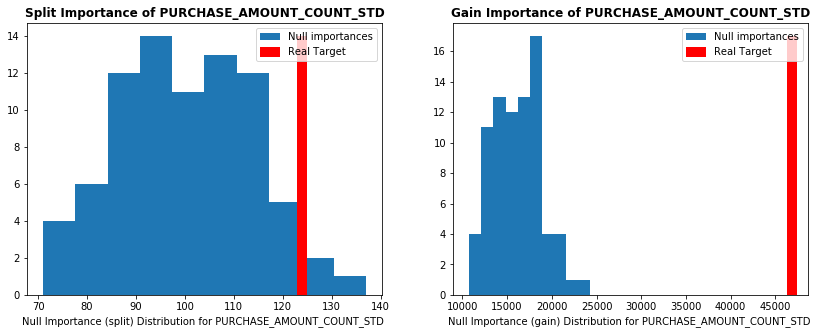

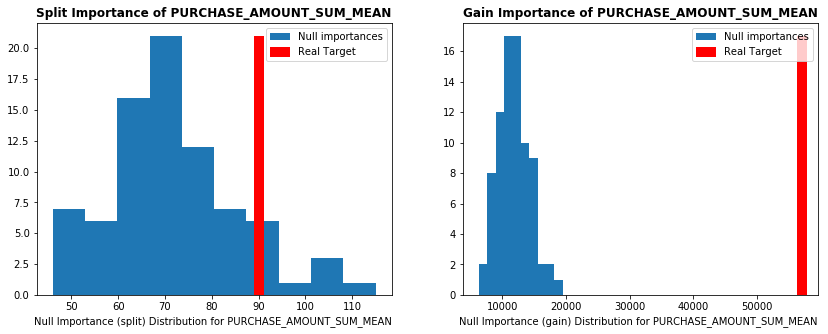

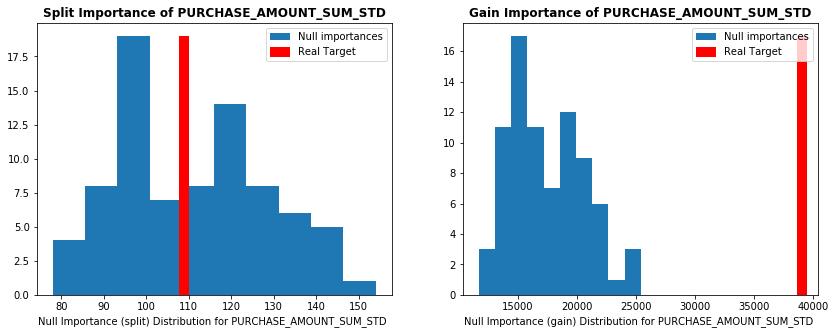

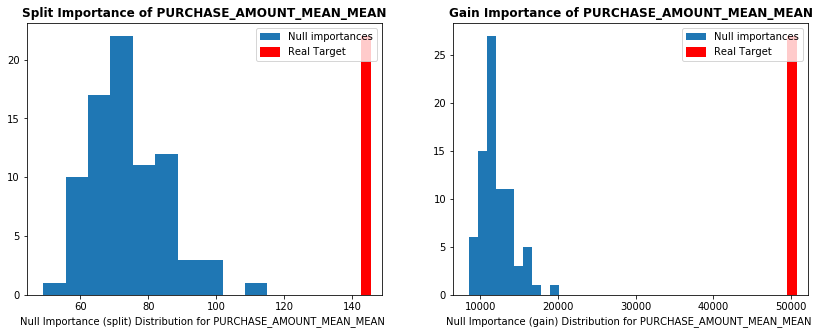

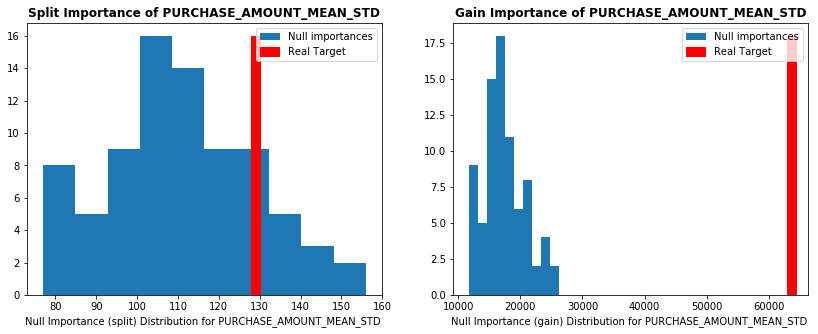

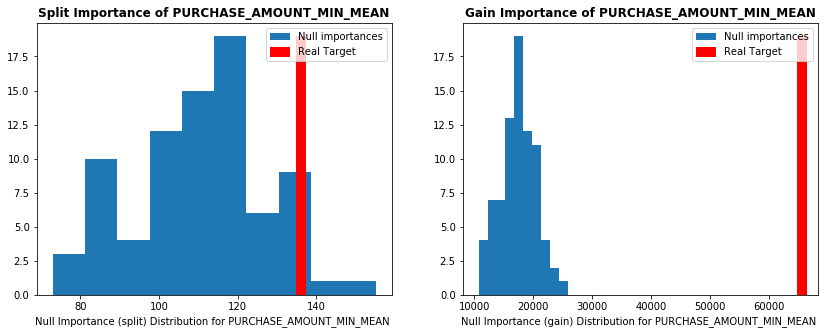

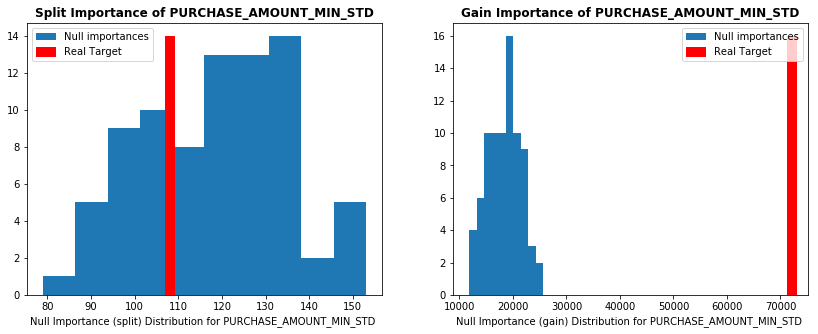

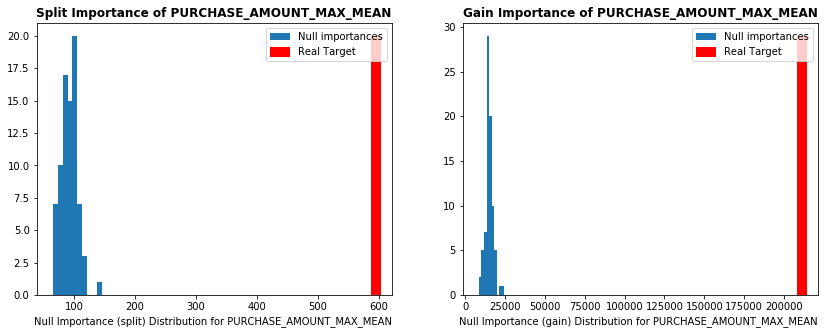

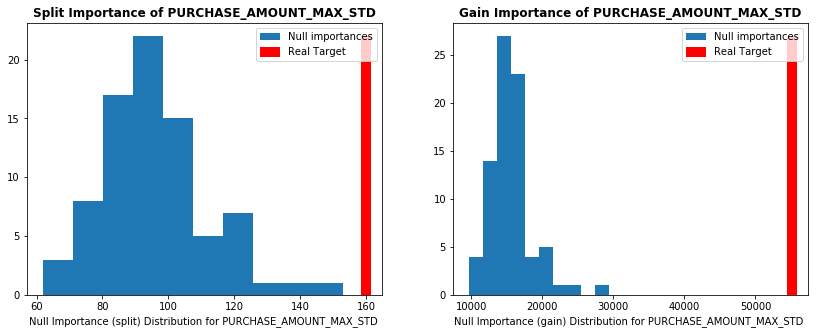

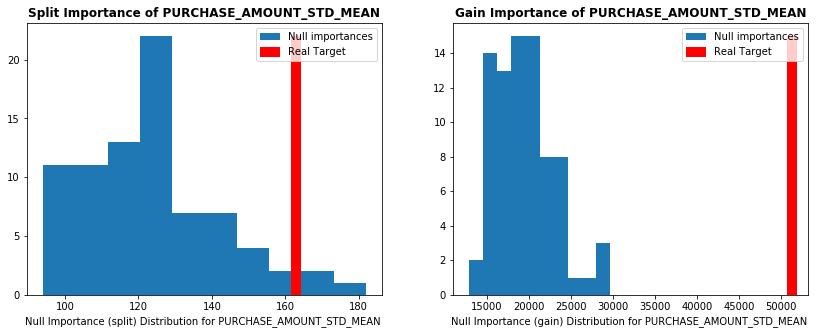

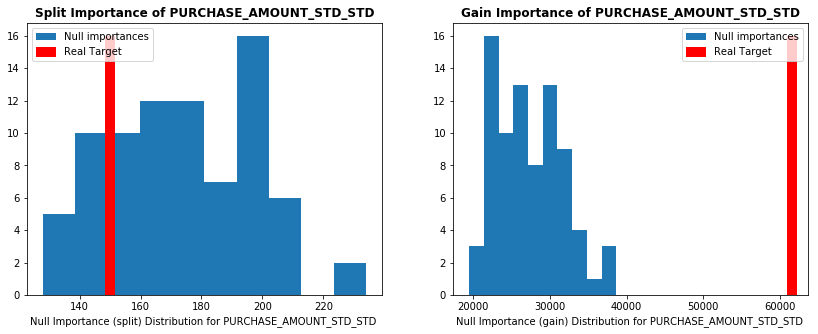

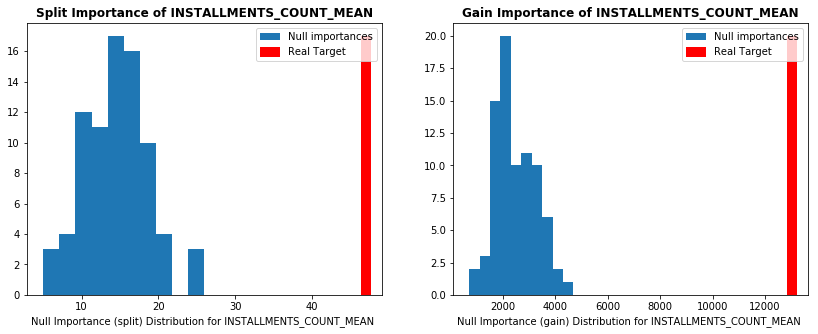

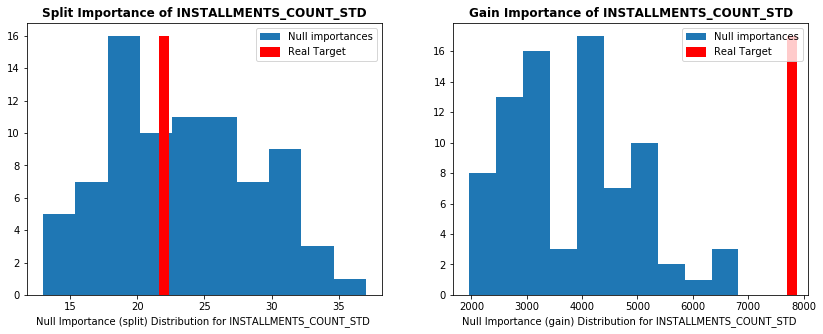

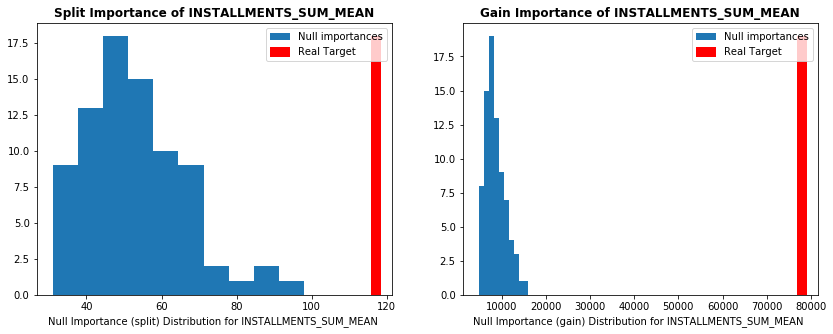

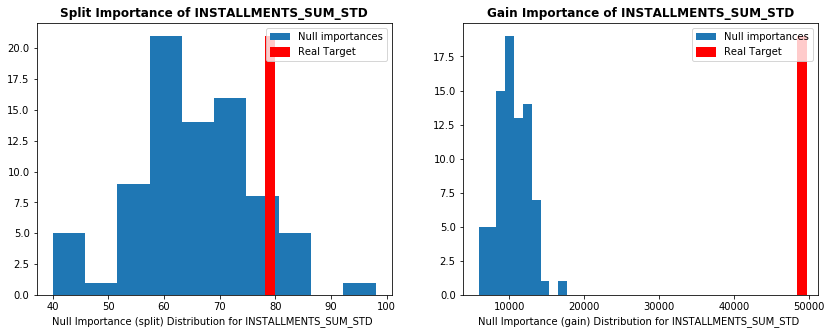

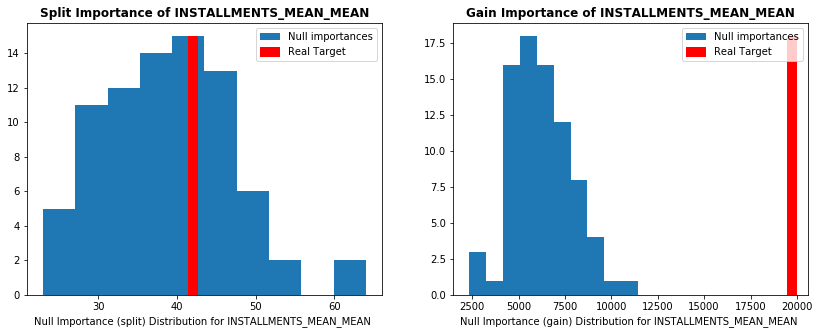

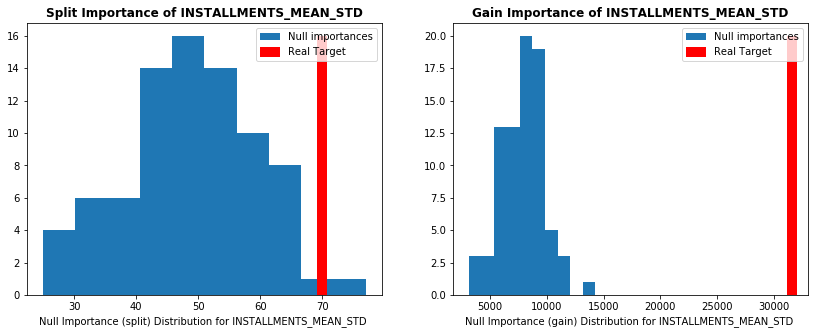

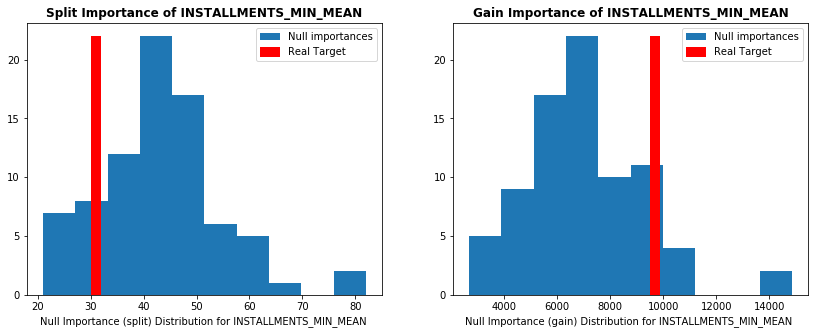

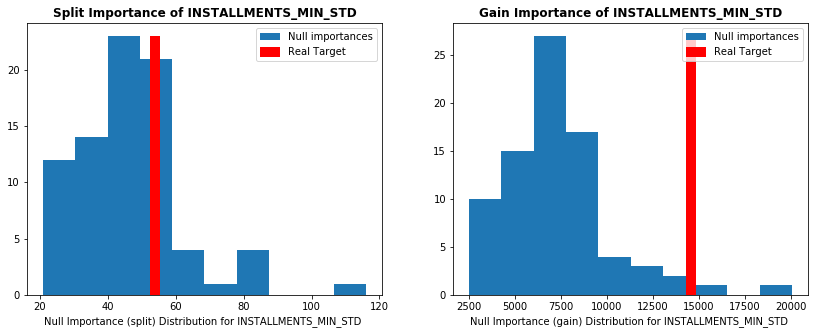

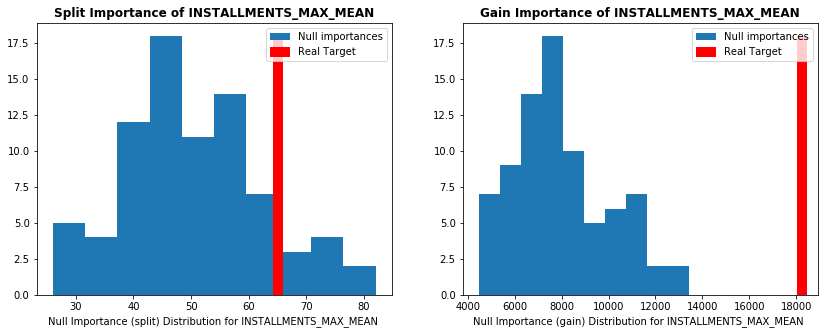

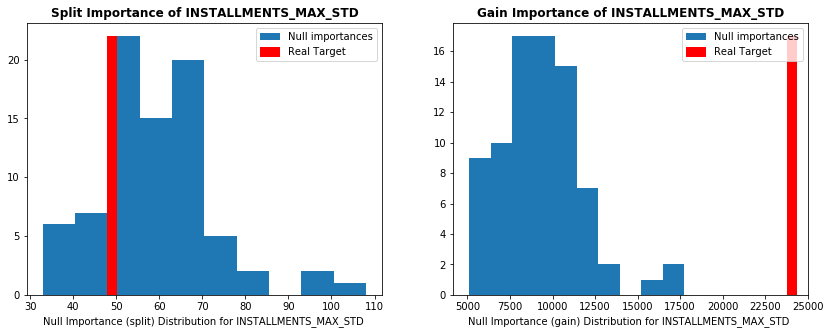

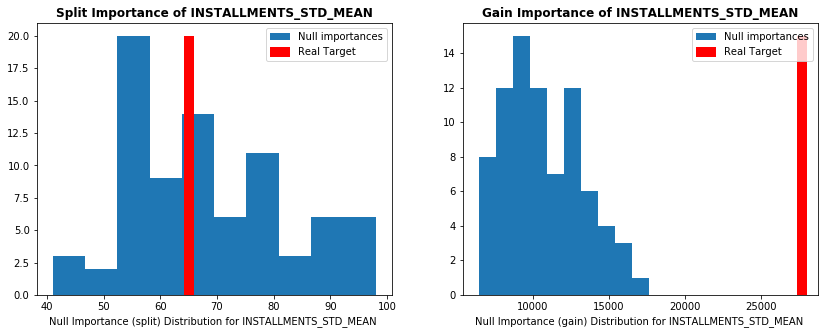

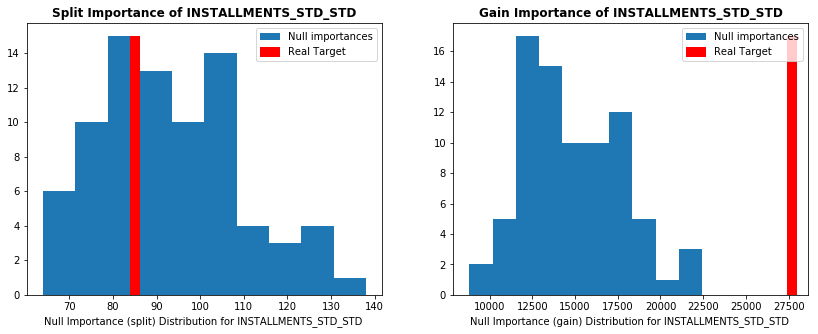

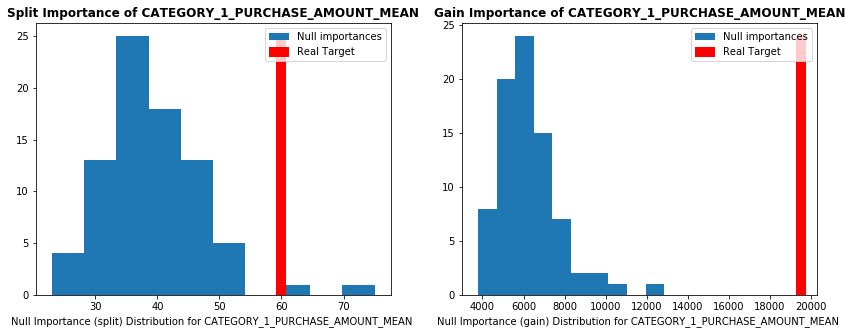

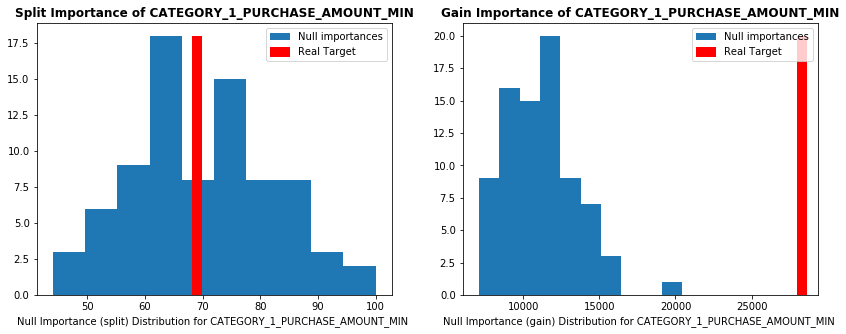

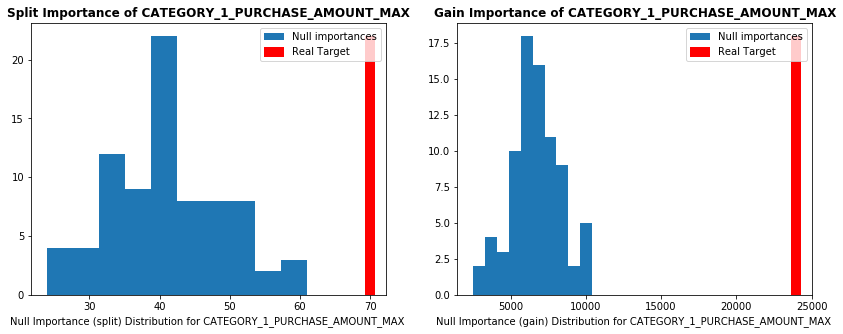

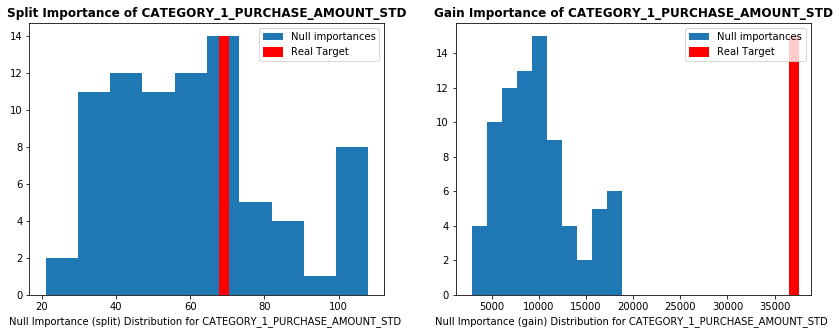

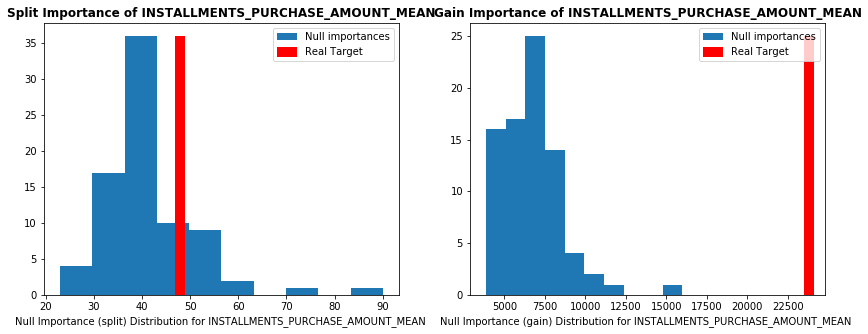

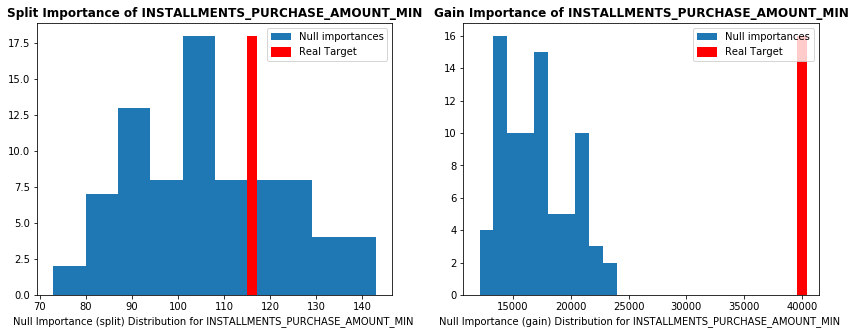

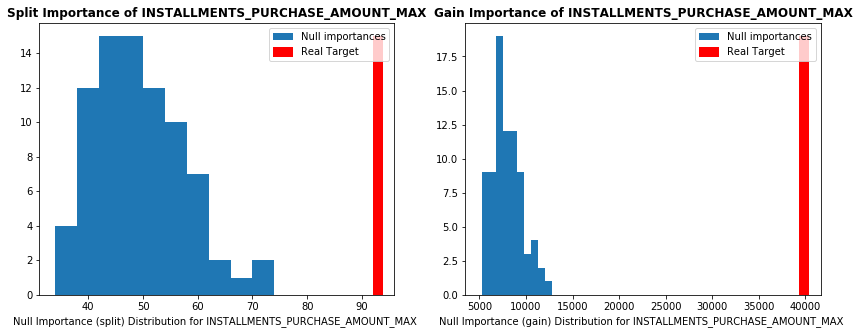

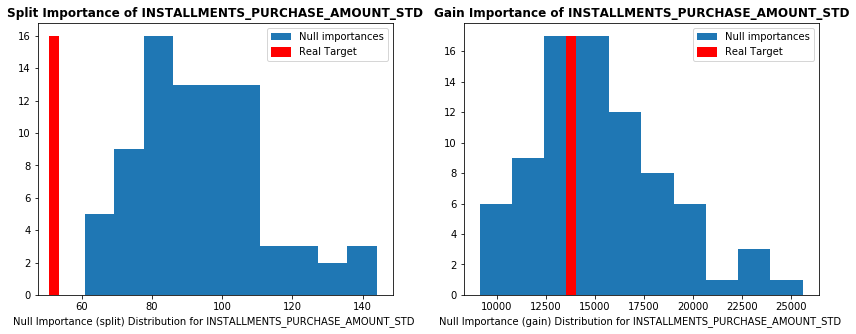

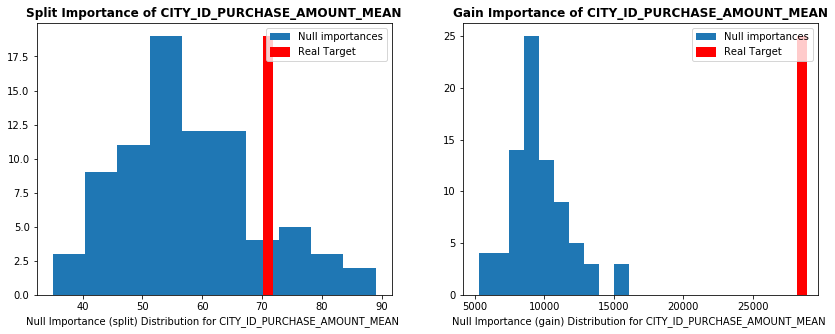

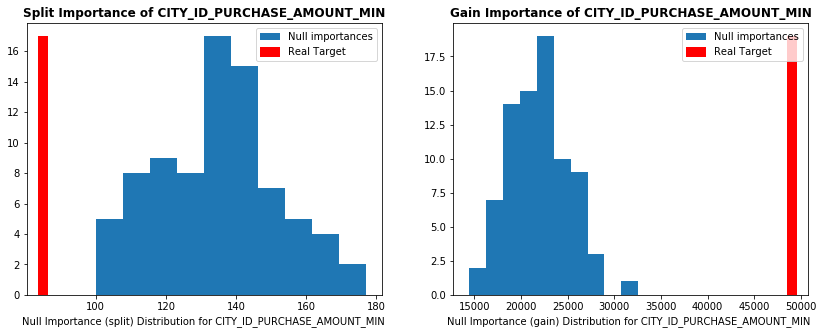

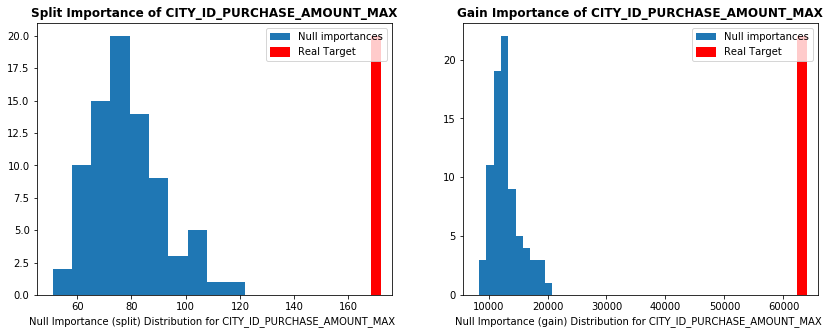

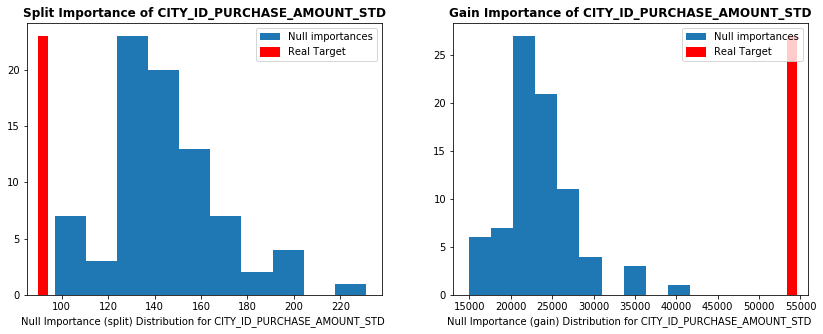

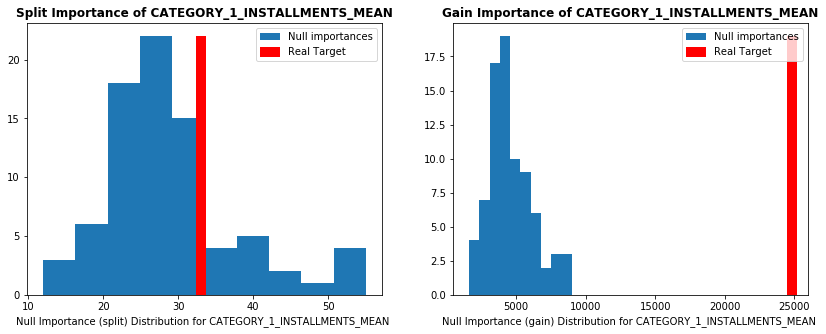

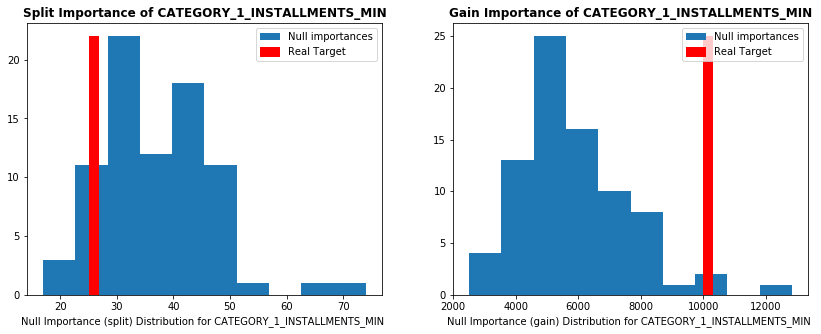

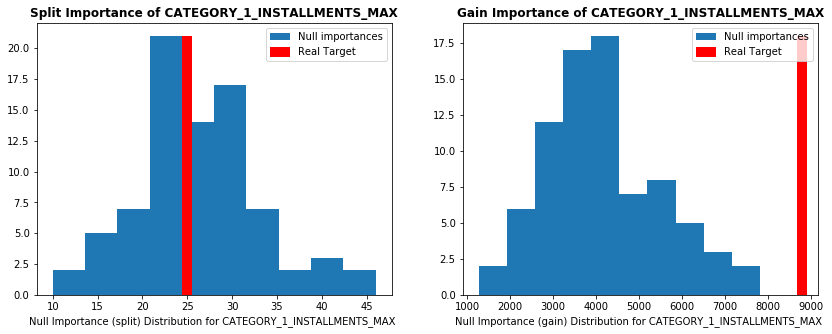

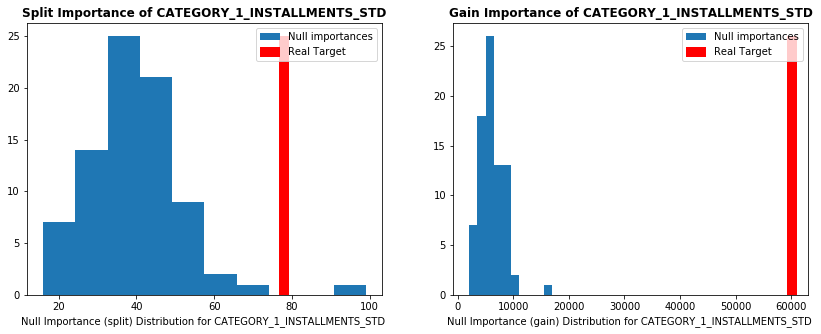

In [19]:
for i in [x for x in list(train.columns.values) if x not in ['target', 'object_id','first_active_month'] ]:
    display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_=i)